# Deriving and testing Principal Components


In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")

### Loading data

In [2]:
from feature_utils import load_season_data

START_YEAR = 2017
END_YEAR = 2022
LEAGUE = 'Premier League'

seasons = [f"{year}-{year+1}" for year in range(START_YEAR, END_YEAR)]

data = {season: load_season_data(LEAGUE, season).query("pos != 'GK'") for season in seasons}

----
----
----

### Using the 2017-2018 season as a training set for dimensionality reduction

Only considering players with at least >= 5.0 90s

In [3]:
MIN_90S = 5.0
X_train = data['2017-2018']
X_train = X_train[X_train['90s'] >= MIN_90S]
X_train = X_train.iloc[:, 6:]
X_train.shape

(365, 52)

### Feature correlation clustering

Clusters: 9


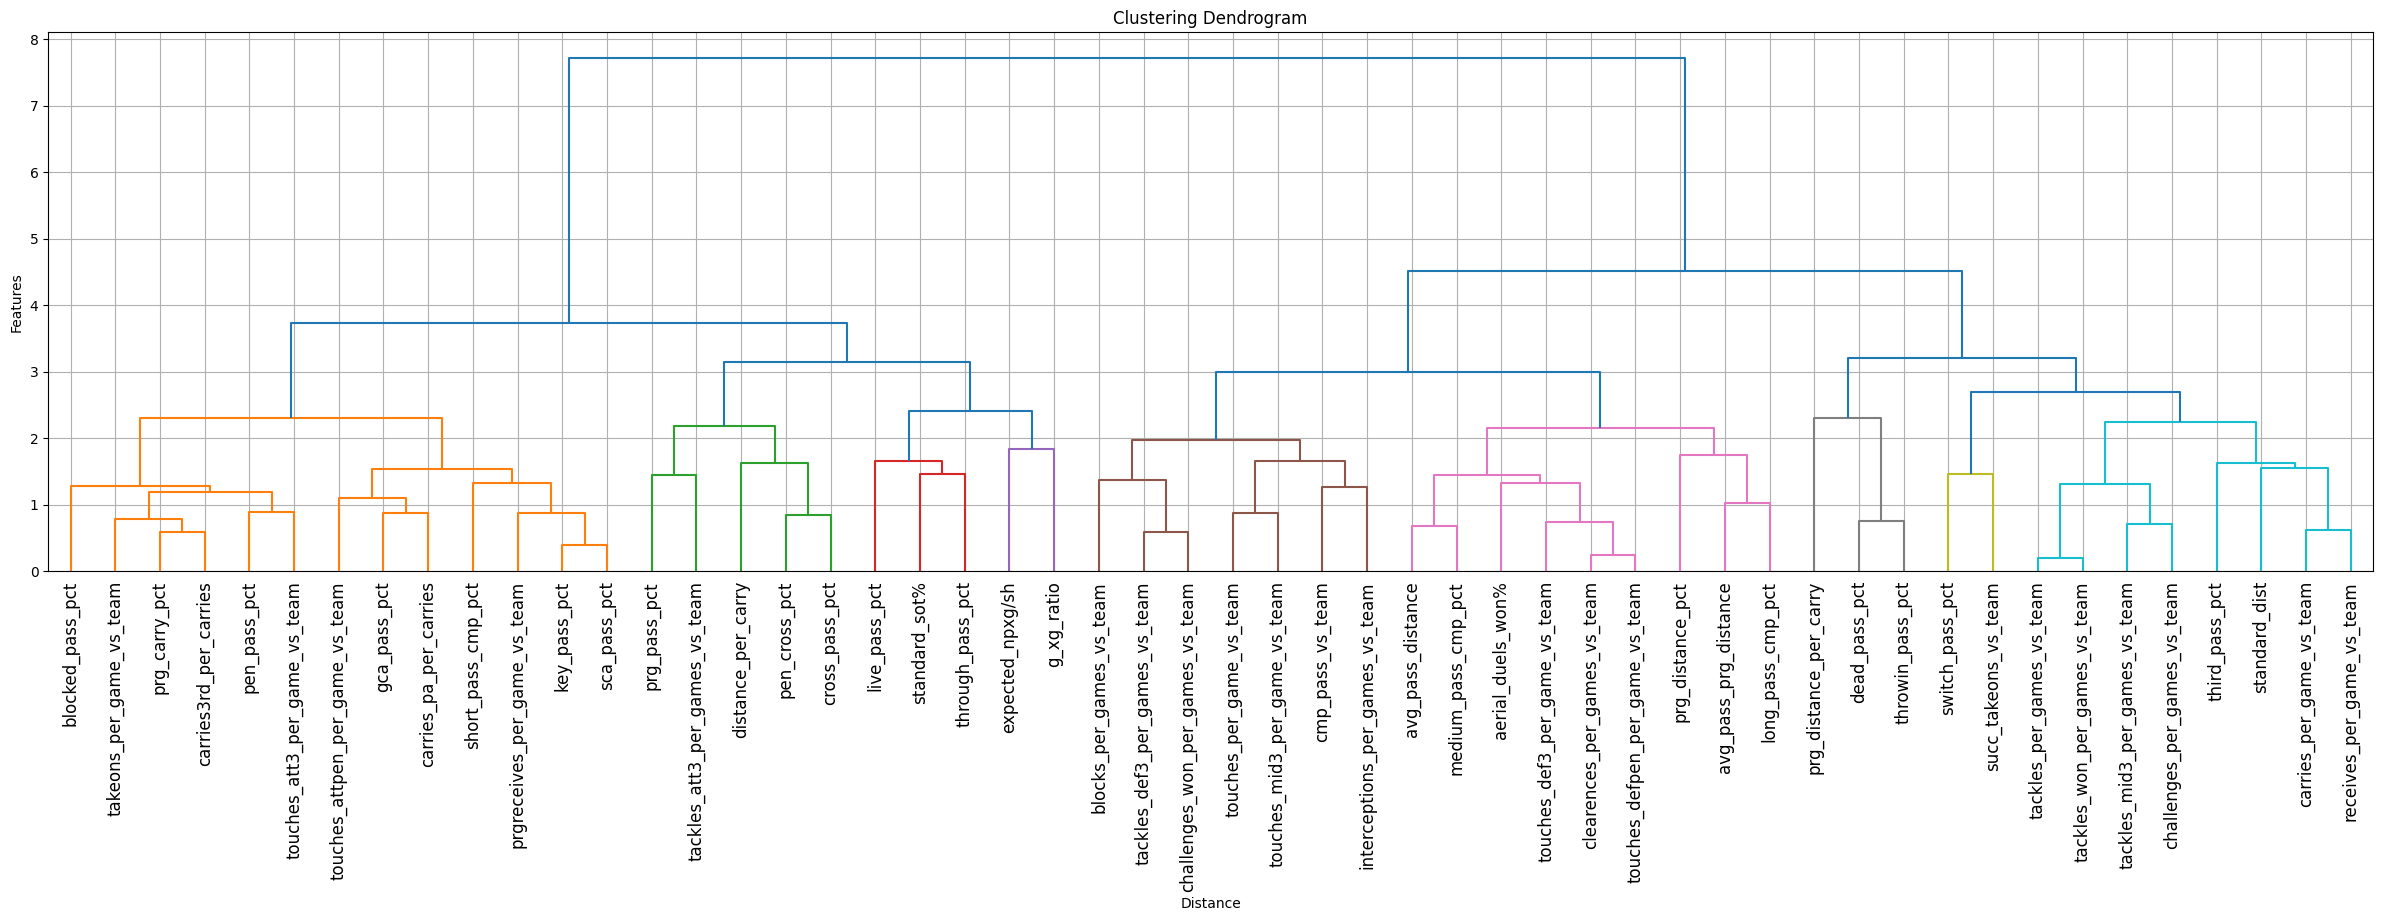

In [4]:
import scipy.cluster.hierarchy as spc

threshold = 0.3

pdist = spc.distance.pdist(X_train.corr().values)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, threshold * pdist.max(), 'distance')
print("Clusters:", max(idx))

plt.figure(figsize=(30, 7))
dendrogram = spc.dendrogram(linkage, labels=X_train.columns, orientation='top', color_threshold=threshold * pdist.max())

plt.xlabel('Distance')
plt.ylabel('Features')
plt.title('Clustering Dendrogram')
plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis labels by 90 degrees
plt.grid()
plt.show()

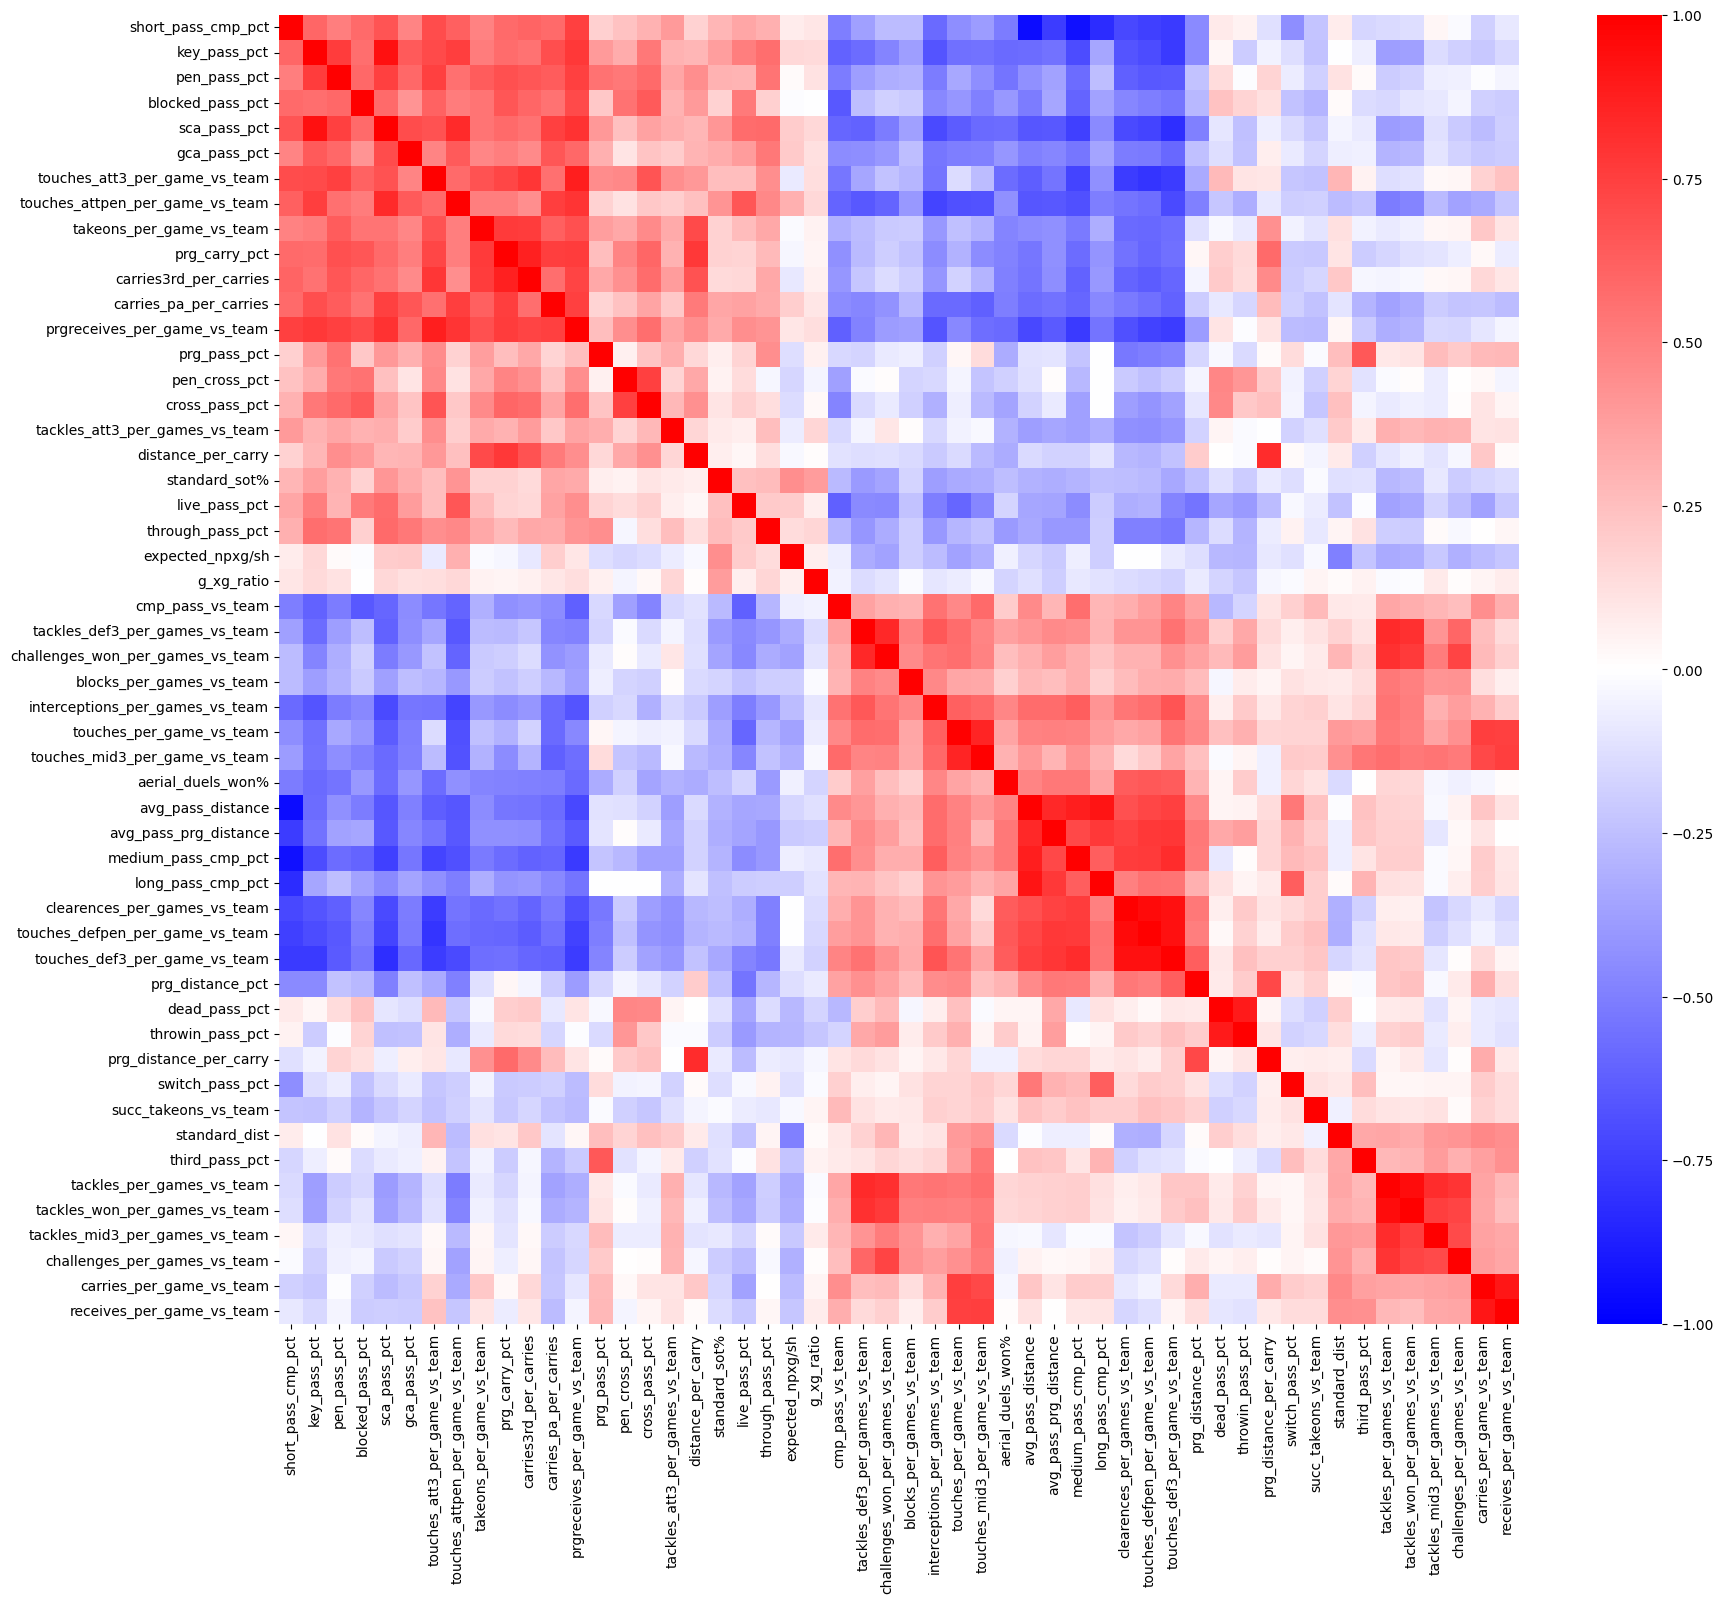

In [5]:
clustered_features = [feature[0] for feature in sorted(list(zip(X_train.columns, idx)), key=lambda x: x[1])]

plt.figure(figsize=(20, 17))
sns.heatmap(X_train.corr().loc[clustered_features, clustered_features], cmap='bwr', vmin=-1, vmax=1)
plt.show()

### Running power transform to normalize features 

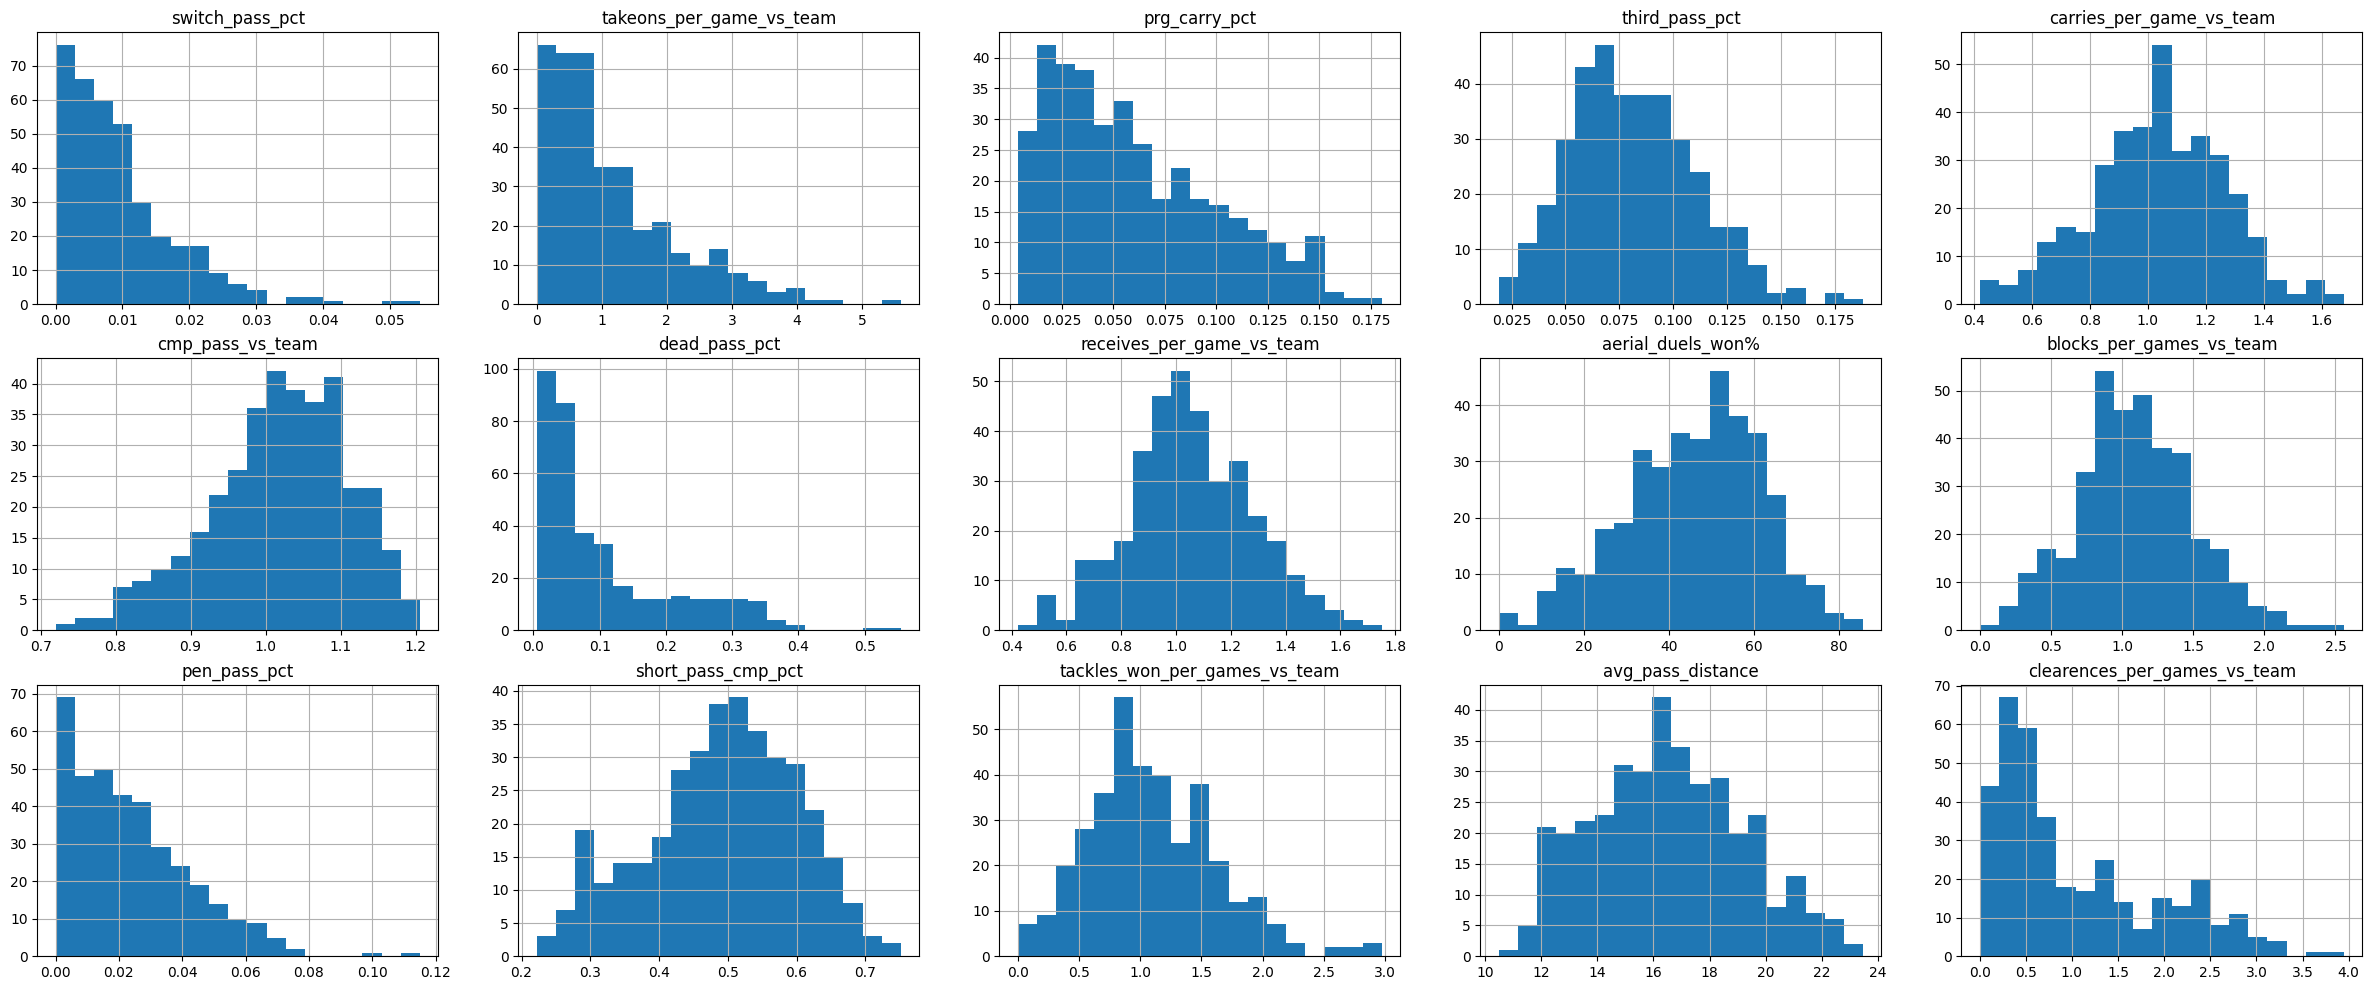

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(30, 12))

np.random.seed(42)

example_features = np.random.choice(X_train.columns, 15, replace=False)
for n, feature in enumerate(example_features):
    row, col = n // 5, n % 5
    ax[row, col].set_title(feature)
    X_train[feature].hist(bins=np.linspace(min(X_train[feature]), max(X_train[feature]), 20), ax=ax[row, col])

plt.show()

### Running power transform to normalize features 

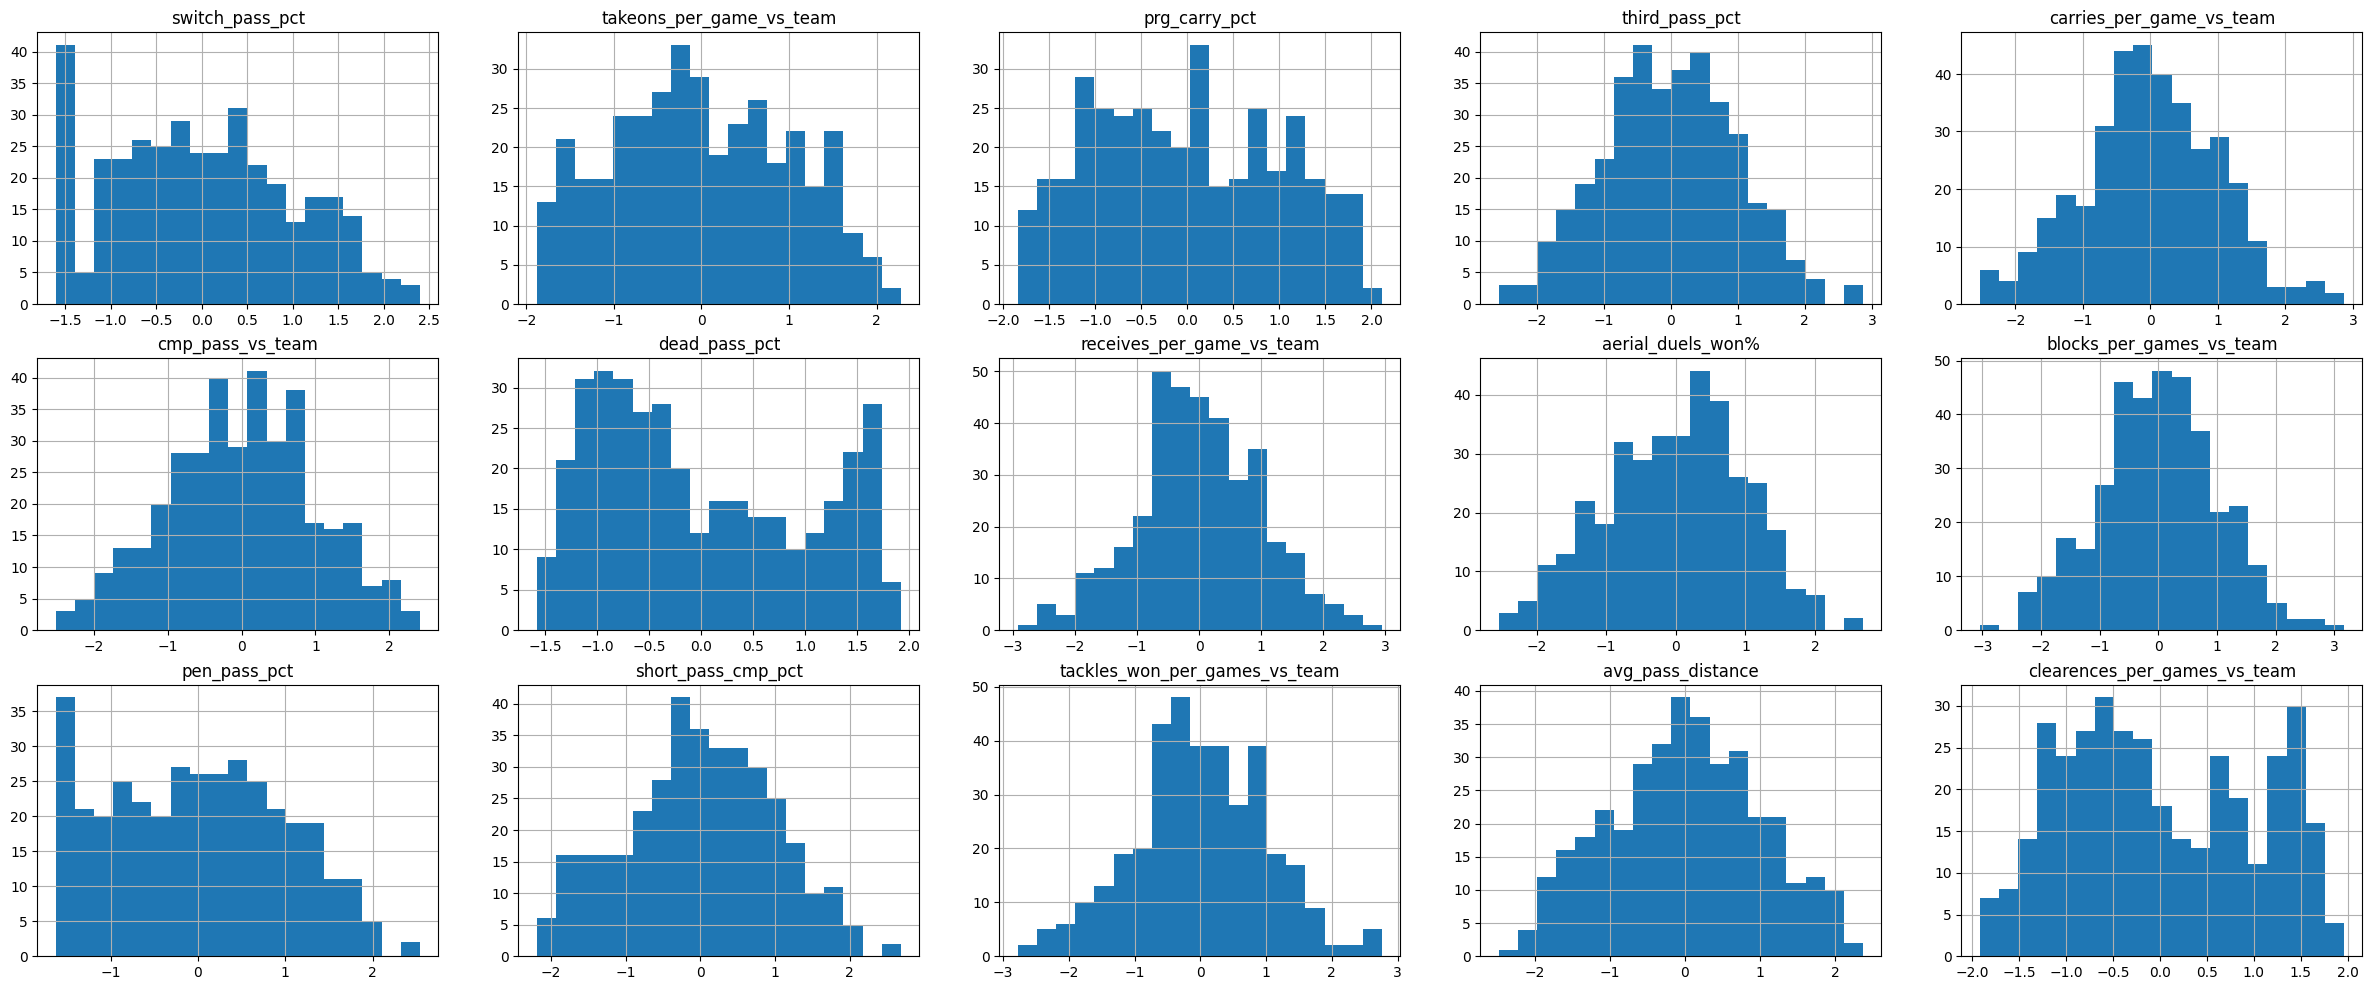

In [7]:
from sklearn.preprocessing import PowerTransformer

power_transform = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transform.fit_transform(X_train)
X_train_transformed = pd.DataFrame(index=X_train.index, columns=X_train.columns, data=X_train_transformed)

fig, ax = plt.subplots(3, 5, figsize=(30, 12))

for n, feature in enumerate(example_features):
    row, col = n // 5, n % 5
    ax[row, col].set_title(feature)
    X_train_transformed[feature].hist(bins=np.linspace(min(X_train_transformed[feature]), max(X_train_transformed[feature]), 20), ax=ax[row, col])

plt.show()

### PCA on transformed feature space

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_decomposed = pca.fit_transform(X_train_transformed)
X_train_decomposed = pd.DataFrame(index=X_train.index, columns=(f"PC{i}" for i in range(1, len(X_train.columns) + 1)), data=X_train_decomposed)
X_train_decomposed.head()

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                      
Lewis Dunk    -5.804140  2.404634  0.800532  1.847484 -1.601471  2.094635  \
Shane Duffy   -5.807754  5.538861  1.467966  1.875430 -0.157802  0.871009   
Dale Stephens -5.244210 -2.135661 -3.370358  0.338821 -0.289224  1.124220   
Davy Pröpper  -2.635550 -0.970048 -2.903316  0.727381  1.278239  1.962631   
Pascal Groß    4.097675 -1.700355 -0.868732  1.773204  3.085346  0.275960   

                    PC7       PC8       PC9      PC10  ...      PC43   
player                                                 ...             
Lewis Dunk     0.230850 -0.667829  1.575141  0.225785  ...  0.053615  \
Shane Duffy   -0.734689 -0.365638  2.128857 -0.146485  ...  0.082407   
Dale Stephens -1.748157 -0.534626  0.364836 -0.437793  ... -0.060406   
Davy Pröpper  -2.206678 -0.047555  0.148866  0.007991  ...  0.097802   
Pascal Groß    1.516159 -0.583313  0.383208 -1.304944  ... -0.162552   

                   PC44      PC45      PC46      PC47      PC48      PC49   
player                                                                      
Lewis Dunk    -0.181148  0.238172  0.036535  0.122763 -0.051712 -0.009316  \
Shane Duffy    0.018907  0.340028 -0.049647  0.270003  0.127022 -0.095131   
Dale Stephens  0.027882 -0.087848  0.076683  0.060630 -0.122312 -0.060582   
Davy Pröpper   0.028969 -0.050379  0.157288 -0.319292 -0.017777  0.053862   
Pascal Groß    0.230369 -0.169639  0.136034 -0.060740 -0.031993  0.022852   

                   PC50      PC51      PC52  
player                                       
Lewis Dunk     0.076950  0.126958  0.108479  
Shane Duffy    0.071891 -0.044526  0.036804  
Dale Stephens -0.001940 -0.004210 -0.011153  
Davy Pröpper  -0.028922 -0.016006  0.023593  
Pascal Groß   -0.205291 -0.025743  0.104307  

[5 rows x 52 columns]

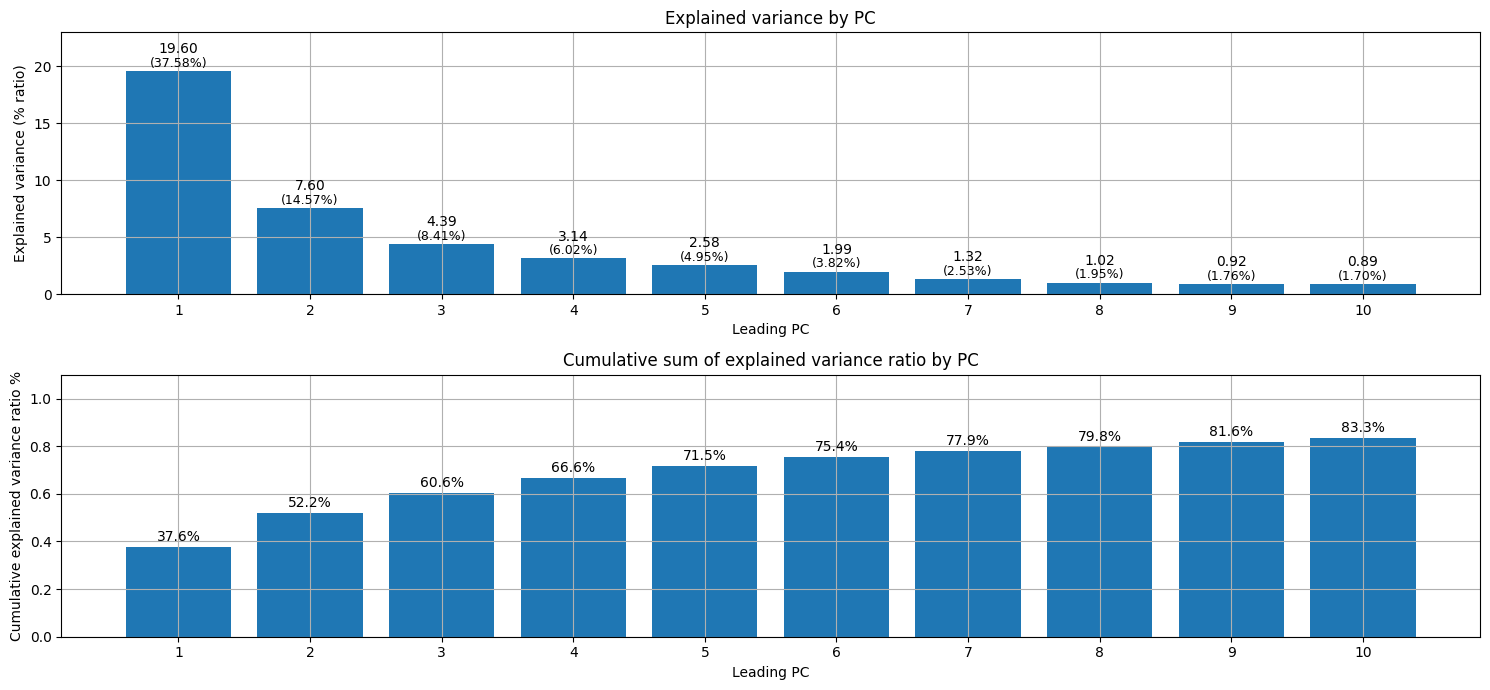

In [9]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
CUTOFF = 10

fig, ax = plt.subplots(2, 1, figsize=(15, 7), tight_layout=True)

# First subplot: Explained variance with % label underneath
ax[0].set_title("Explained variance by PC")
bars = ax[0].bar(x=np.arange(len(explained_variance[:CUTOFF])) + 1, height=explained_variance[:CUTOFF])
ax[0].set_xticks(np.arange(len(explained_variance[:CUTOFF])) + 1)
ax[0].set_xlabel("Leading PC")
ax[0].set_ylabel("Explained variance (% ratio)")
ax[0].grid()
ax[0].set_ylim(0, 23)

# Add both value and percentage labels above each bar
for idx, bar in enumerate(bars):
    height = bar.get_height()
    perc = explained_variance_ratio[idx] * 100
    # Absolute value
    ax[0].text(bar.get_x() + bar.get_width() / 2, height + 1.3, f"{height:.2f}", ha='center', va='bottom')
    # Percentage, a bit below the absolute value
    ax[0].text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"({perc:.2f}%)", ha='center', va='bottom', fontsize=9)

# Second subplot: Cumulative explained variance ratio
ax[1].set_title("Cumulative sum of explained variance ratio by PC")
bars1 = ax[1].bar(x=np.arange(len(explained_variance_ratio[:CUTOFF])) + 1, height=np.cumsum(explained_variance_ratio)[:CUTOFF])
ax[1].set_xticks(np.arange(len(explained_variance_ratio[:CUTOFF])) + 1)
ax[1].set_xlabel("Leading PC")
ax[1].set_ylabel("Cumulative explained variance ratio %")
ax[1].grid()
ax[1].set_ylim(0, 1.1)
# Add labels above each bar
for bar in bars1:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height + 0.025, f"{height*100:.1f}%", ha='center')

plt.show()

### Plotting 8 biggest PCs ~80% of variance

{'sca_pass_pct': 0.21, 'prgreceives_per_game_vs_team': 0.21, 'key_pass_pct': 0.21, 'carries_pa_per_carries': 0.2, 'touches_attpen_per_game_vs_team': 0.19, 'avg_pass_distance': -0.18, 'clearences_per_games_vs_team': -0.19, 'medium_pass_cmp_pct': -0.19, 'touches_defpen_per_game_vs_team': -0.2, 'touches_def3_per_game_vs_team': -0.21}


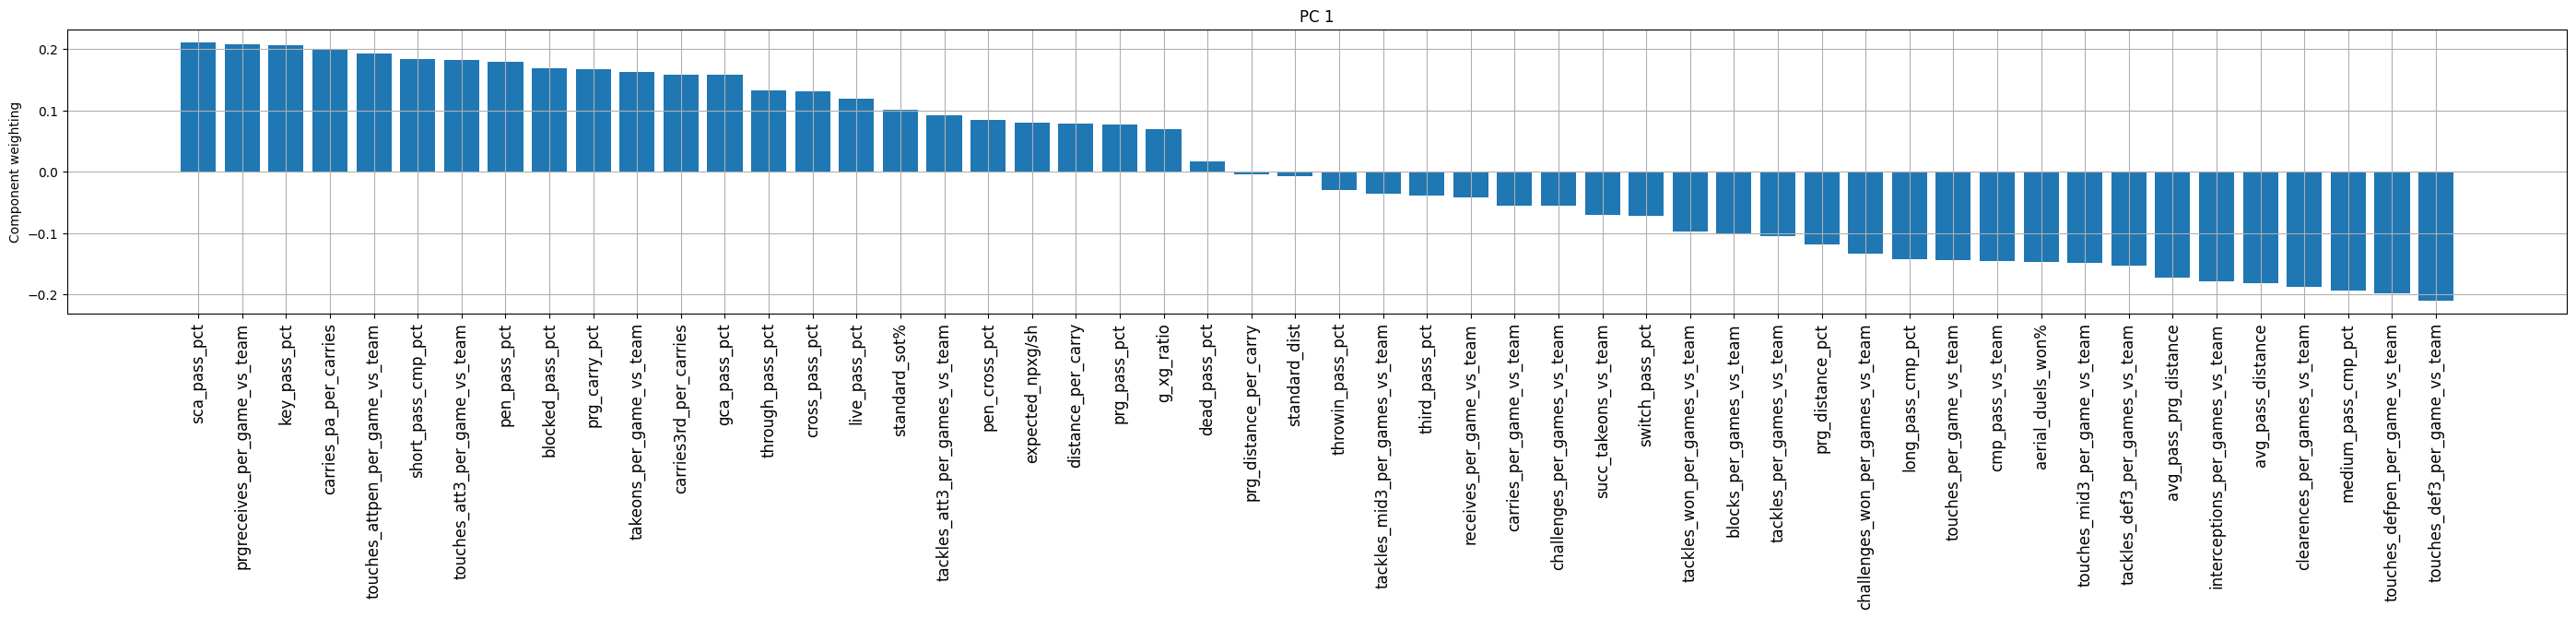

{'expected_npxg/sh': 0.21, 'live_pass_pct': 0.12, 'touches_attpen_per_game_vs_team': 0.09, 'clearences_per_games_vs_team': 0.08, 'touches_defpen_per_game_vs_team': 0.08, 'carries_per_game_vs_team': -0.23, 'standard_dist': -0.24, 'tackles_won_per_games_vs_team': -0.25, 'tackles_per_games_vs_team': -0.25, 'challenges_per_games_vs_team': -0.26}


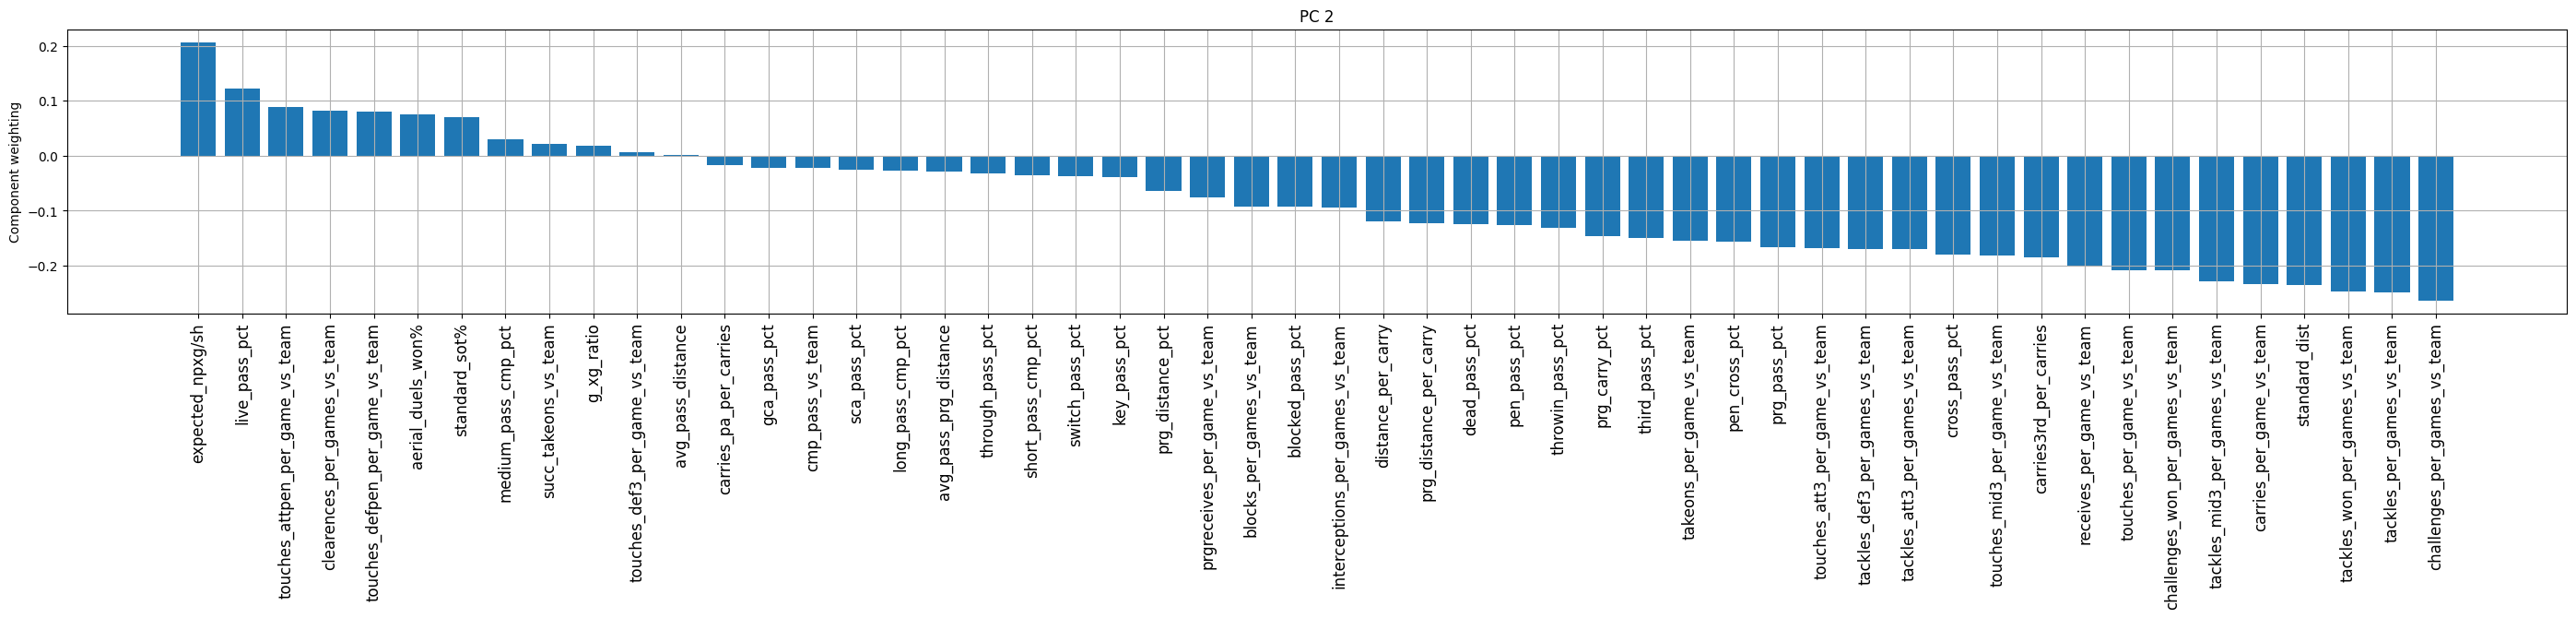

{'throwin_pass_pct': 0.36, 'dead_pass_pct': 0.31, 'pen_cross_pct': 0.25, 'cross_pass_pct': 0.21, 'prg_distance_per_carry': 0.21, 'touches_mid3_per_game_vs_team': -0.19, 'through_pass_pct': -0.2, 'receives_per_game_vs_team': -0.2, 'third_pass_pct': -0.21, 'tackles_mid3_per_games_vs_team': -0.21}


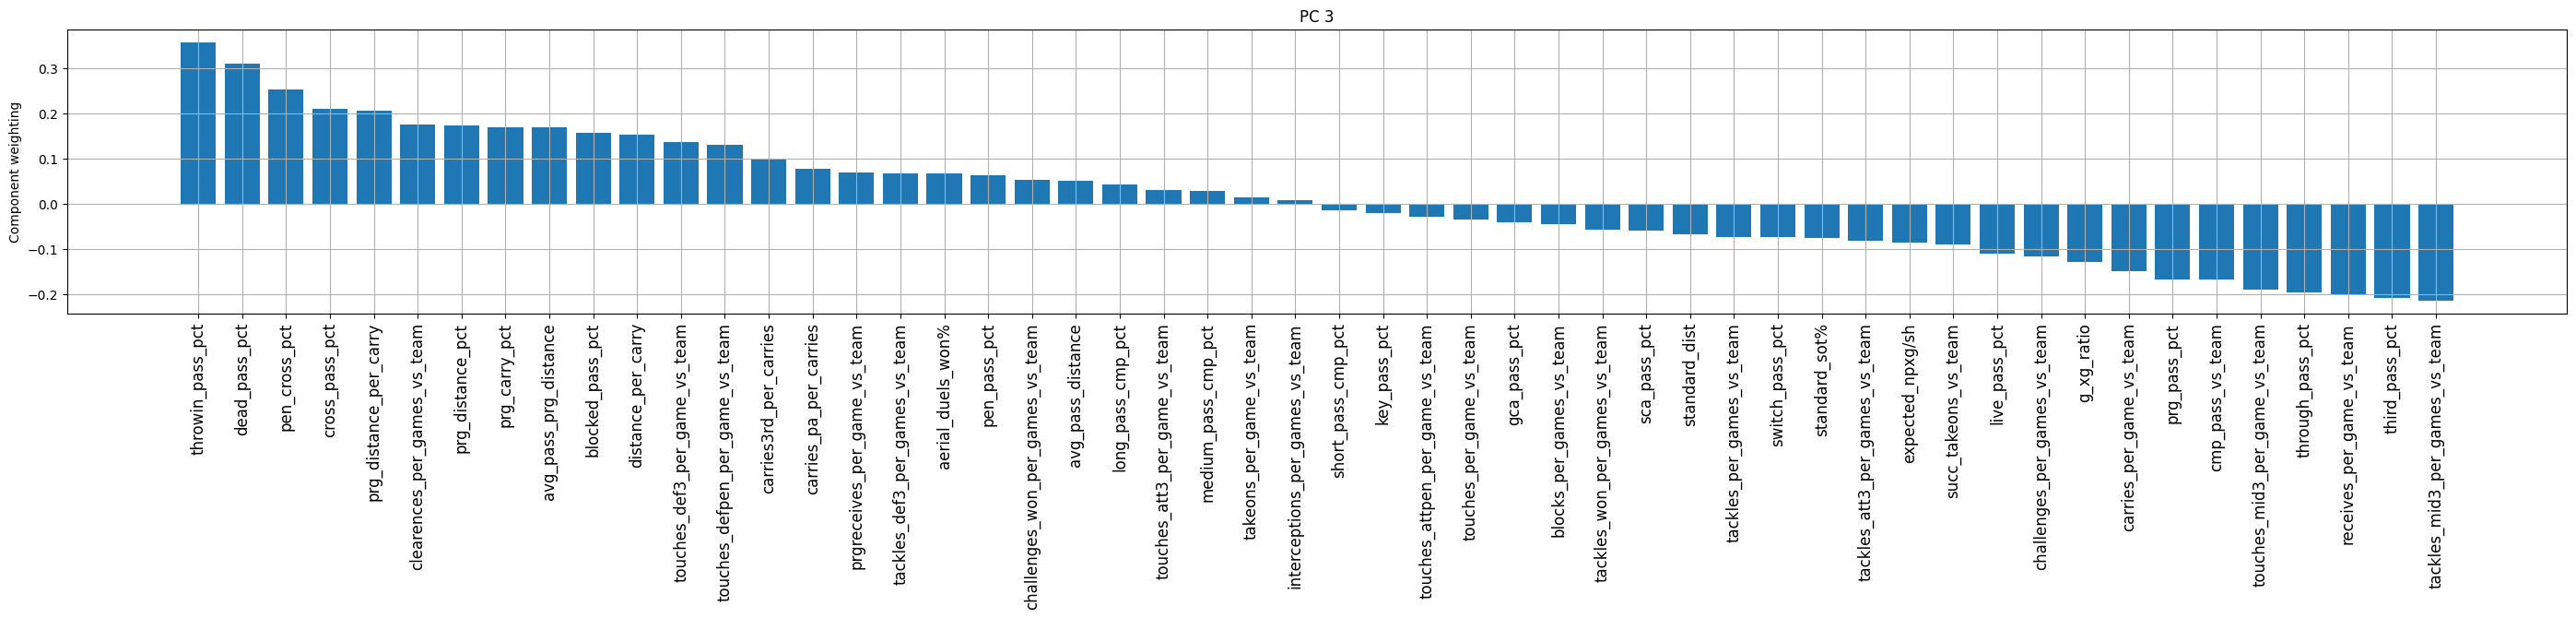

{'switch_pass_pct': 0.3, 'long_pass_cmp_pct': 0.29, 'prg_distance_per_carry': 0.27, 'distance_per_carry': 0.26, 'avg_pass_distance': 0.25, 'tackles_mid3_per_games_vs_team': -0.18, 'challenges_won_per_games_vs_team': -0.18, 'tackles_won_per_games_vs_team': -0.2, 'tackles_per_games_vs_team': -0.21, 'short_pass_cmp_pct': -0.23}


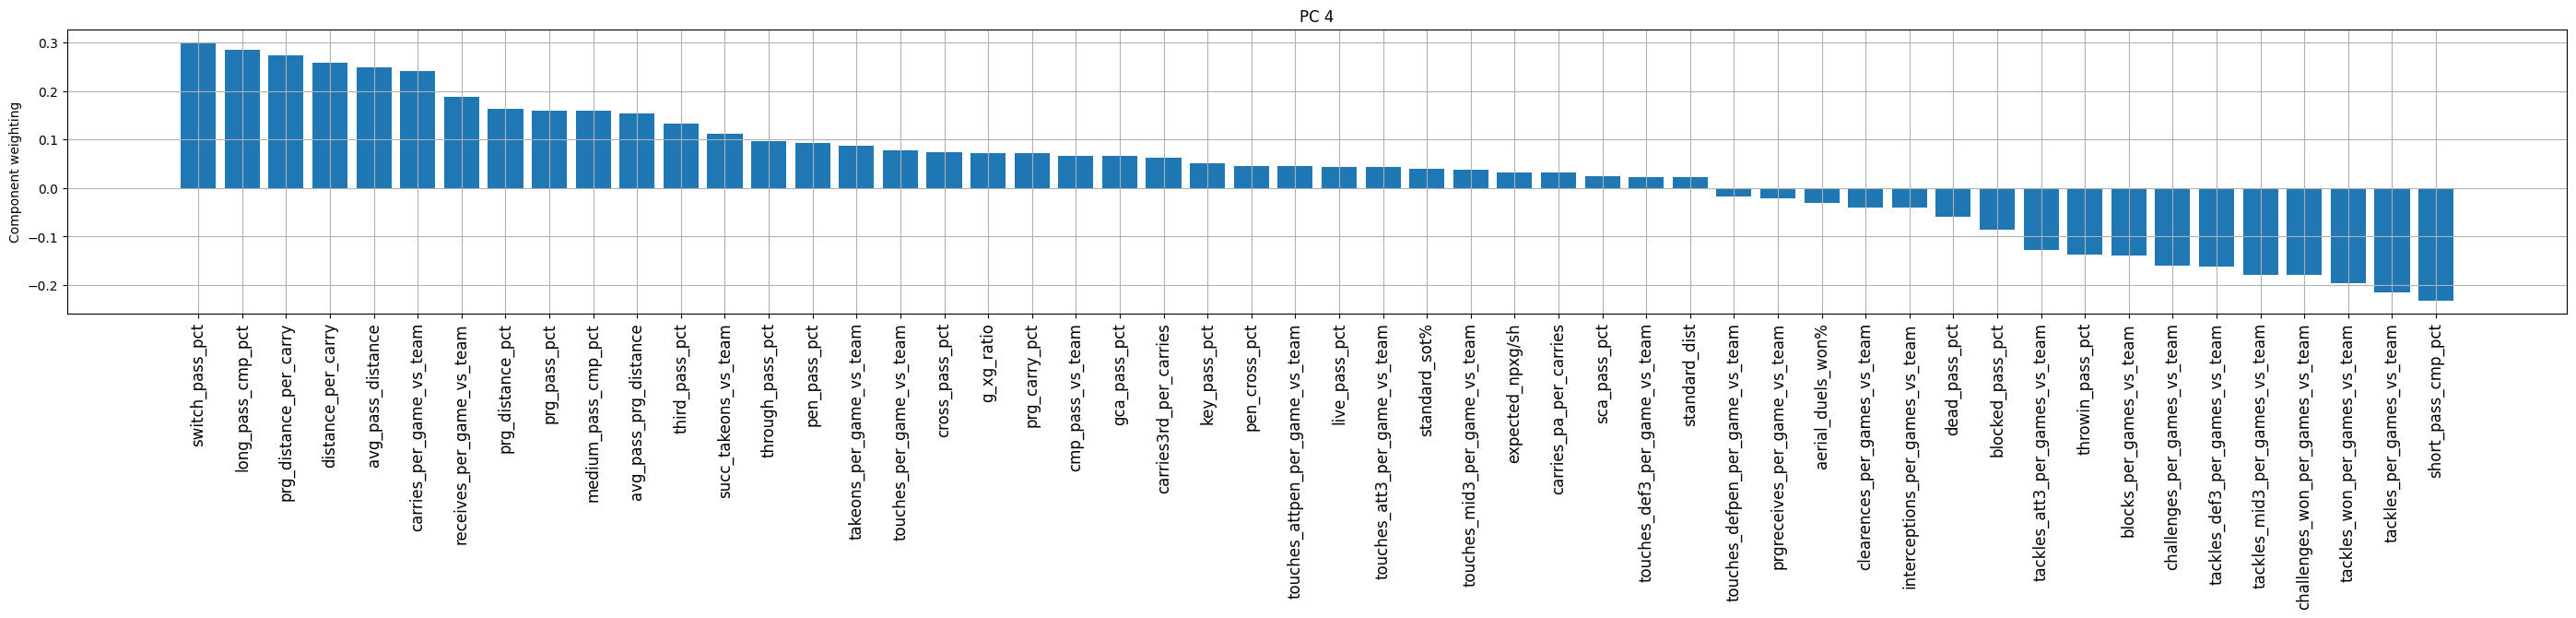

{'dead_pass_pct': 0.29, 'third_pass_pct': 0.27, 'long_pass_cmp_pct': 0.21, 'prg_pass_pct': 0.18, 'pen_cross_pct': 0.17, 'prg_carry_pct': -0.18, 'cmp_pass_vs_team': -0.19, 'prg_distance_pct': -0.27, 'distance_per_carry': -0.34, 'prg_distance_per_carry': -0.4}


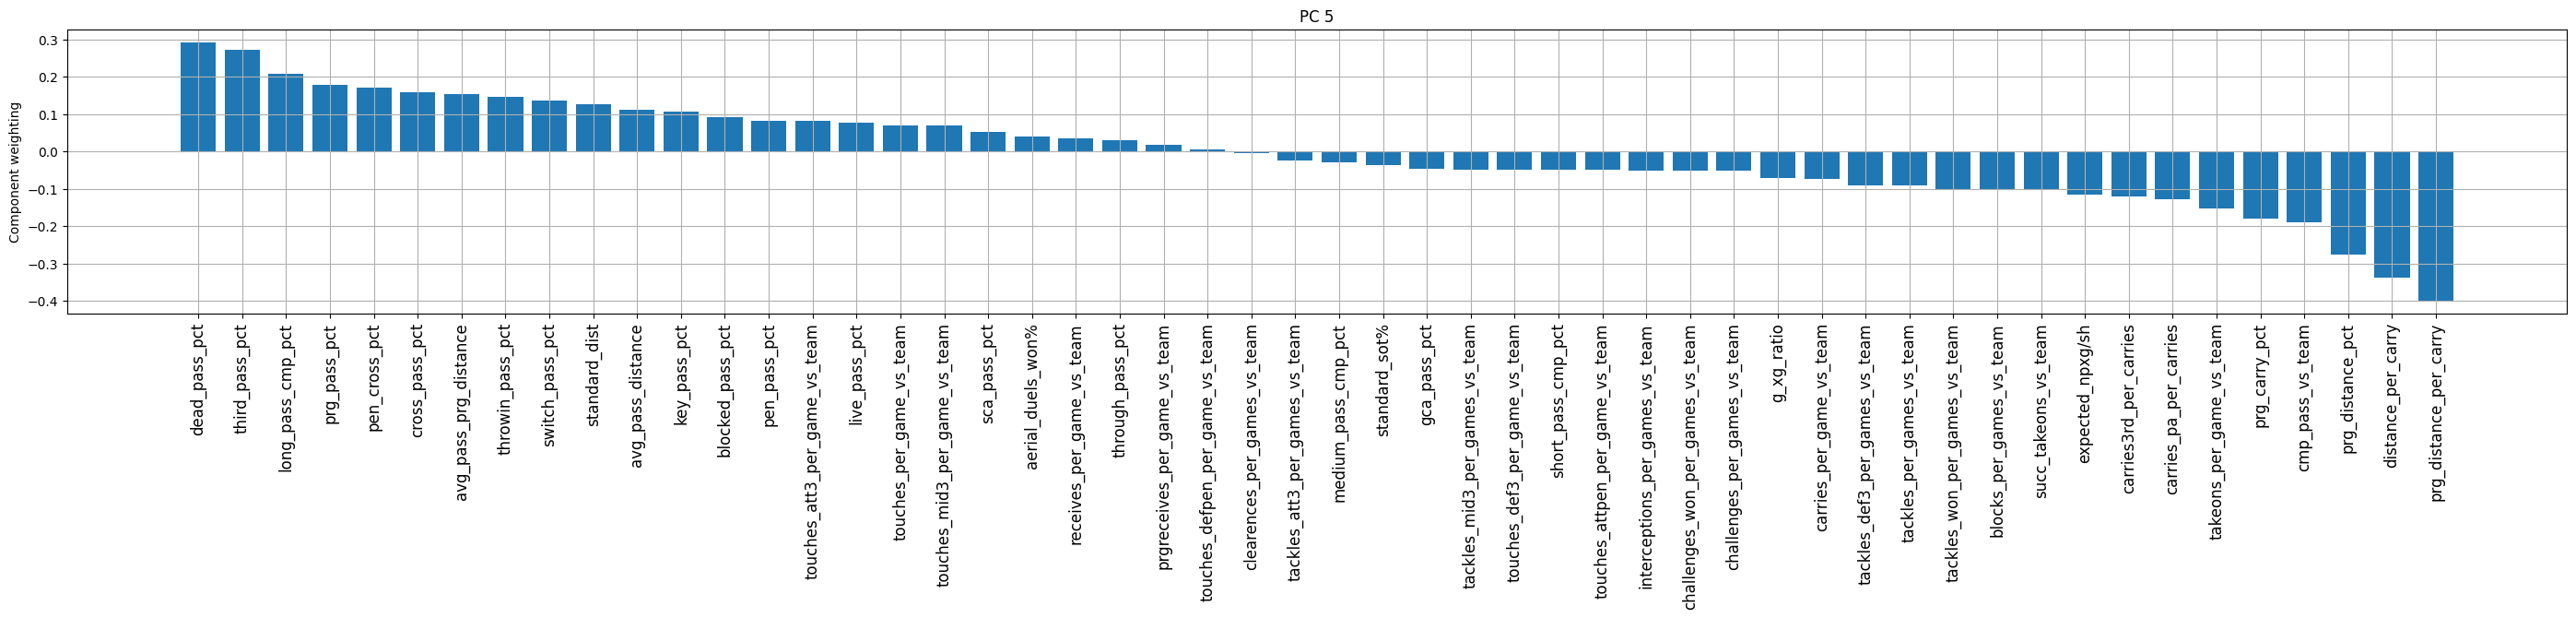

{'live_pass_pct': 0.3, 'long_pass_cmp_pct': 0.24, 'blocks_per_games_vs_team': 0.24, 'switch_pass_pct': 0.22, 'tackles_won_per_games_vs_team': 0.21, 'short_pass_cmp_pct': -0.16, 'touches_mid3_per_game_vs_team': -0.2, 'touches_per_game_vs_team': -0.24, 'carries_per_game_vs_team': -0.25, 'receives_per_game_vs_team': -0.33}


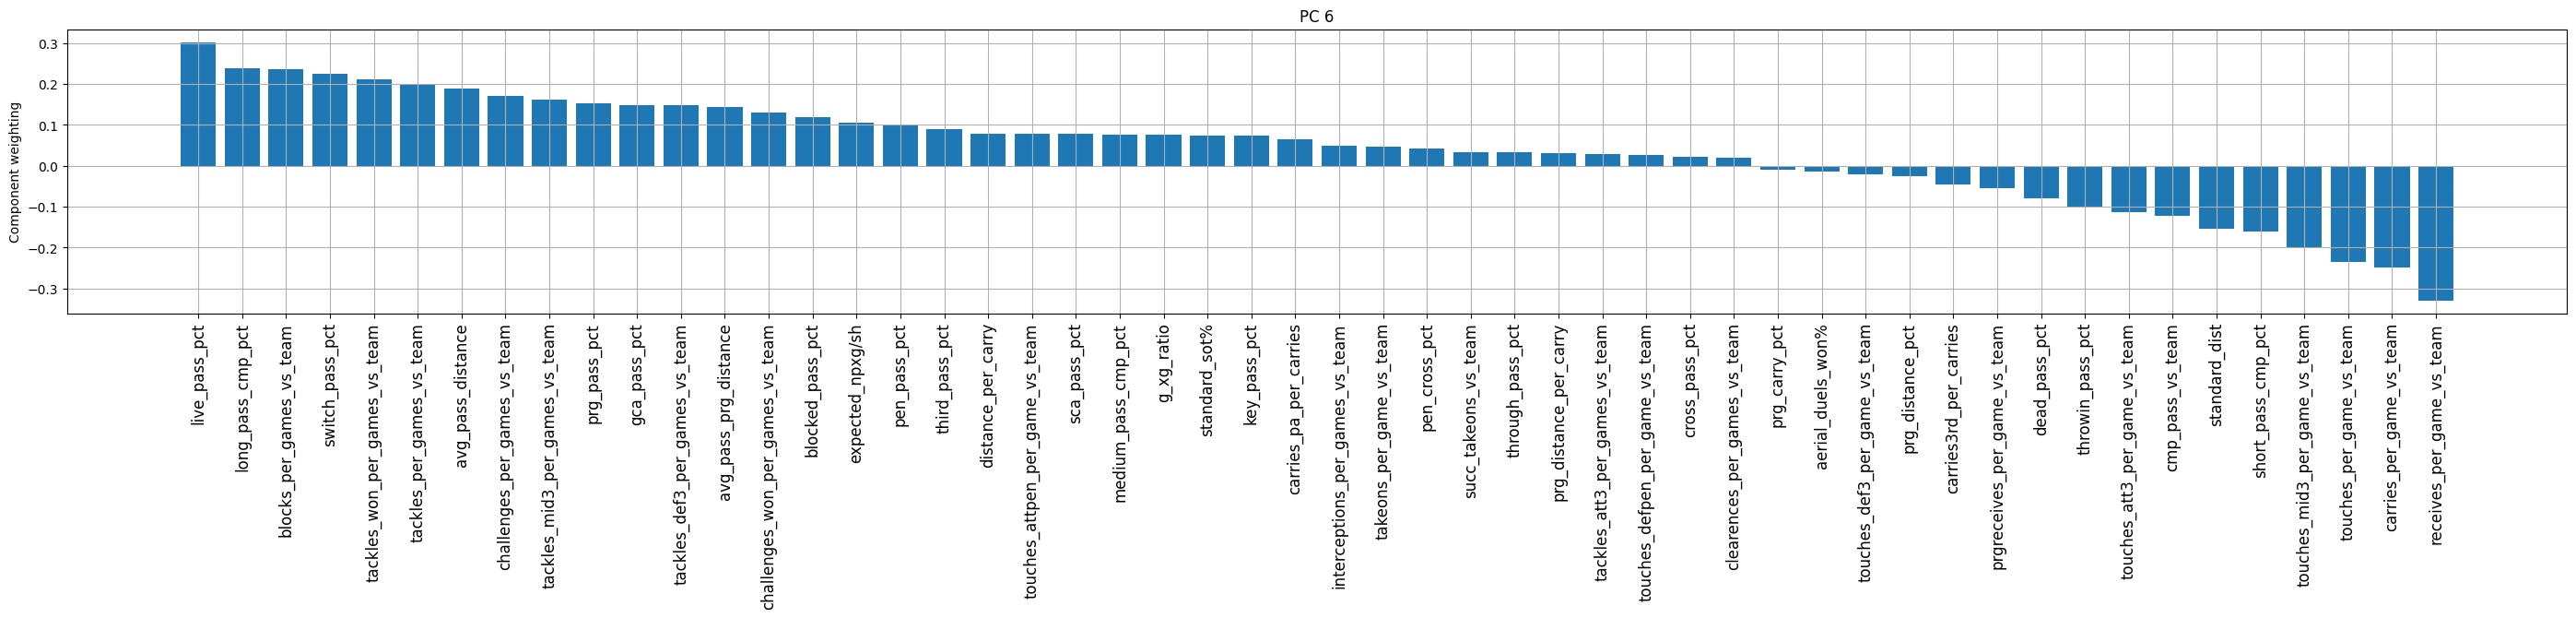

{'g_xg_ratio': 0.6, 'standard_sot%': 0.57, 'expected_npxg/sh': 0.24, 'touches_per_game_vs_team': 0.15, 'dead_pass_pct': 0.14, 'standard_dist': -0.09, 'prg_pass_pct': -0.11, 'takeons_per_game_vs_team': -0.11, 'distance_per_carry': -0.12, 'live_pass_pct': -0.16}


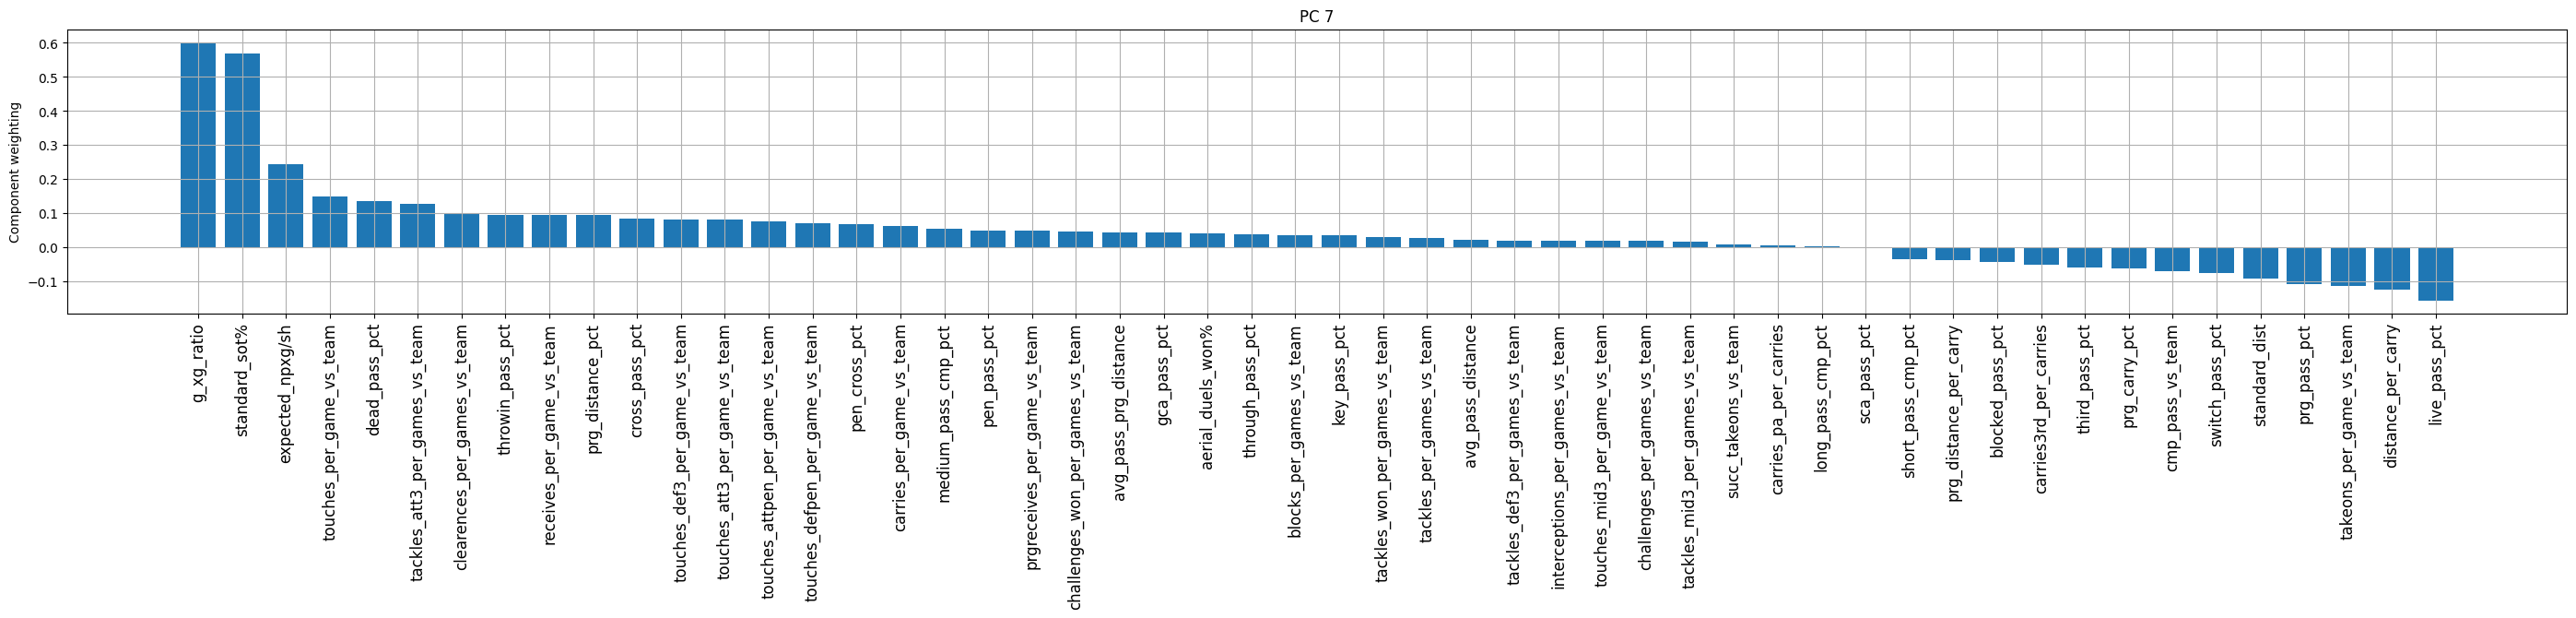

{'succ_takeons_vs_team': 0.41, 'third_pass_pct': 0.34, 'aerial_duels_won%': 0.27, 'prg_pass_pct': 0.25, 'live_pass_pct': 0.23, 'through_pass_pct': -0.12, 'long_pass_cmp_pct': -0.15, 'switch_pass_pct': -0.24, 'standard_dist': -0.26, 'cmp_pass_vs_team': -0.27}


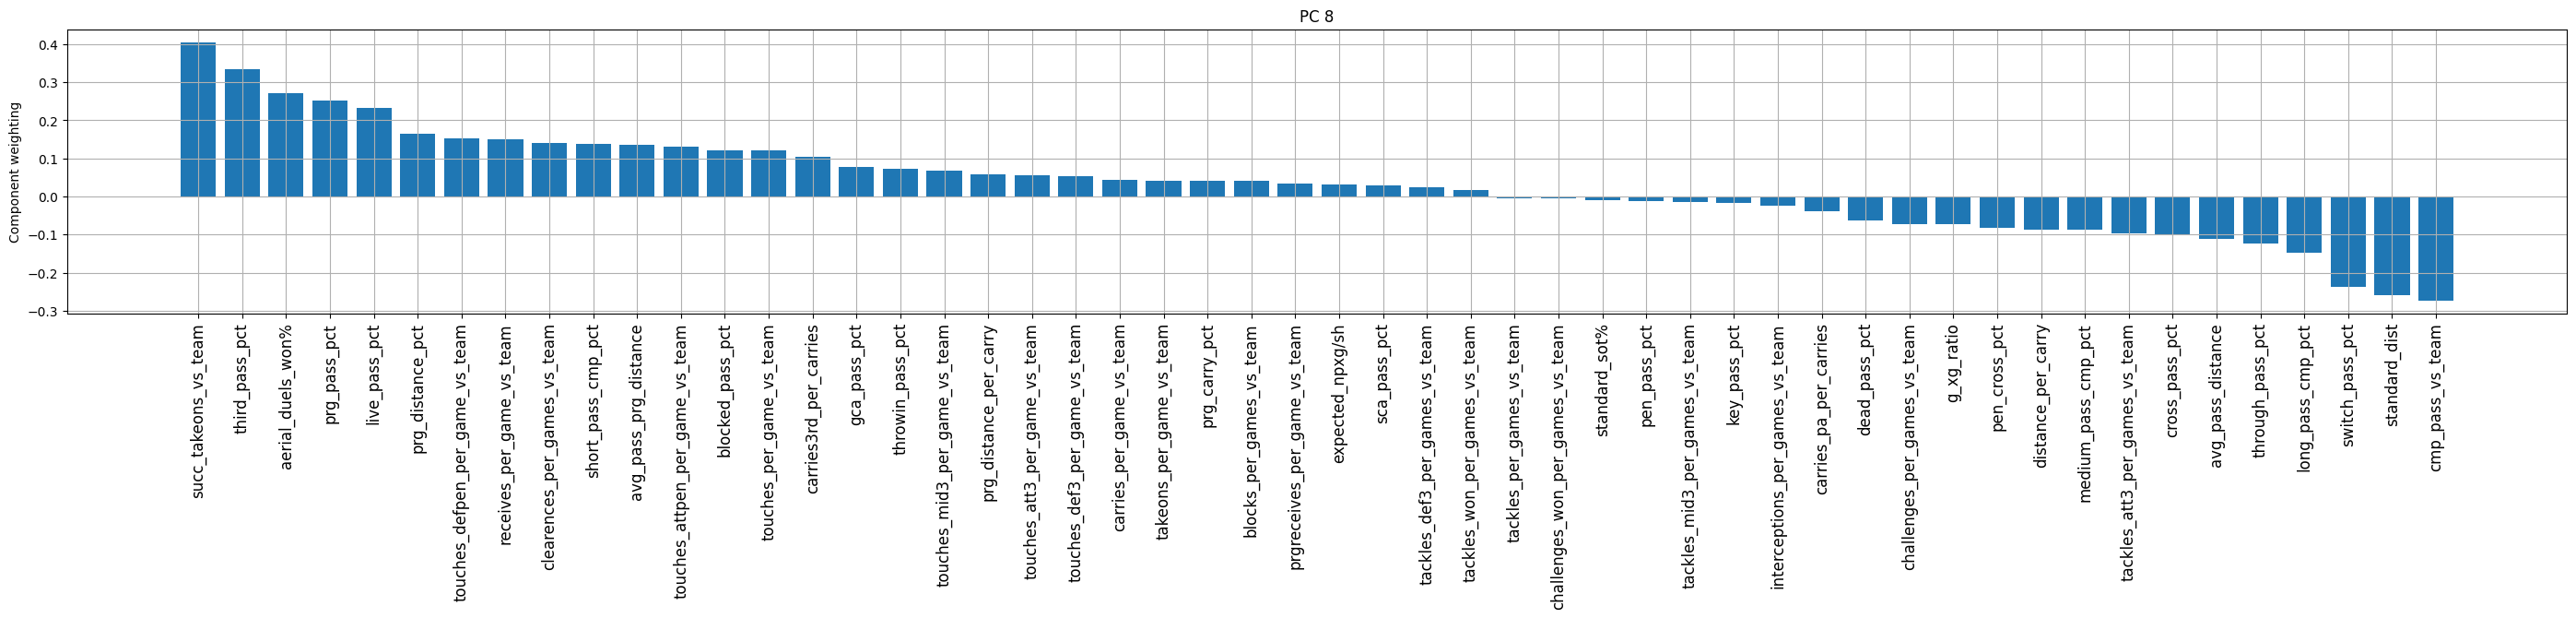

In [10]:
for n in range(8):
    pc_components = pca.components_[n]
    sorted_features, sorted_values = zip(*sorted(list(zip(X_train.columns, pc_components)), key=lambda x: x[1], reverse=True))
    print(dict(zip(sorted_features[:5] + sorted_features[-5:], np.round(sorted_values[:5] + sorted_values[-5:], 2))))

    plt.figure(figsize=(35, 4))
    plt.title(f"PC {n+1}")
    plt.bar(x=np.arange(len(pc_components)), height=sorted_values)
    plt.xticks(np.arange(len(pc_components)), sorted_features, rotation=90, fontsize=12)
    # plt.xticklabels(sorted_features, rotation=90, fontsize=12)
    plt.ylabel("Component weighting")
    plt.grid()
    plt.show()

----
----
----

## Investigation of the meaning behind each PC

In [11]:
# Postion colors
pos_color_map = {'GK': 'dodgerblue', 'DF': 'green', 'DF,MF': 'lime', 'MF,DF': 'greenyellow', 'MF': 'yellow', 'MF,FW': 'gold', 'FW,MF': 'orange', 'FW': 'red', 'FW,DF': 'peru', 'DF,FW': 'olivedrab',}
pc_scatter_df = pd.merge(data['2017-2018'][['team', 'pos']], X_train_decomposed, right_index=True, left_index=True)
pc_scatter_df = pc_scatter_df[~pc_scatter_df.index.duplicated(keep='first')]

# Create a legend
legend_labels = list(pos_color_map.keys())  # List of position labels
unique_colors = list(pos_color_map.values())  # List of unique colors

### PC1 vs PC2

This scatter plot shows clearly that 

PC1 -> _offence vs defence_ 

PC2 -> _forward play vs creativity_ or rather _athelticism vs agility_

Why is that?

It really isn't obvious from the major components of the PC2, yet agile players with more creative stance tend to have more carries, intercept more balls, and have more touches per game.

Forward playing, athletic players will carry the ball into the penalty area, have more key passes, have larger distance per carry and win more areal duels.

It comes as no surprise to see that the type of strong, atheletic player is either a Centre Back (CB) or Centre Forward (FW). 
It is uncommon for other positions such as Full Backs (FB), Centre Midefields (CM) to be athletic. They tend to be creative, agile, quick and good with dribbling.

One can argue that this below demonstrates a *professional football player manifold*, showing which kind of characteristic is associated with which position.

In [12]:
def analyse_pcs(pc_a, pc_b, _pc_scatter_df=pc_scatter_df, lim=None, size=50, first_black=False):
    pc_a_components = pca.components_[pc_a-1]
    pc_b_components = pca.components_[pc_b-1]

    sorted_features_a, sorted_values_a = zip(*sorted(list(zip(X_train.columns, pc_a_components)), key=lambda x: x[1], reverse=True))
    sorted_features_b, sorted_values_b = zip(*sorted(list(zip(X_train.columns, pc_b_components)), key=lambda x: x[1], reverse=True))

    scatter_colors = list(map(lambda x: pos_color_map[x], _pc_scatter_df['pos']))
    if first_black:
        scatter_colors[0] = 'black'

    print(f"Top features PC{pc_a}:", sorted_features_a[:10])
    print(f"Bottom features PC{pc_a}:", sorted_features_a[::-1][:10])
    print("")
    print(f"Top features PC{pc_b}:", sorted_features_b[:10])
    print(f"Bottom features PC{pc_b}:", sorted_features_b[::-1][:10])

    plt.figure(figsize=(12, 8))
    plt.title(f"Scatterplot of PC{pc_a} vs PC{pc_b} with postions")
    plt.scatter(x=_pc_scatter_df[f'PC{pc_a}'], y=_pc_scatter_df[f'PC{pc_b}'], c=scatter_colors, s=size, alpha=0.7)
    plt.xlabel(f"PC{pc_a}")
    plt.ylabel(f"PC{pc_b}")
    if lim is not None:
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)
    plt.grid()
    # Create a legend
    legend_labels = list(pos_color_map.keys())  # List of position labels
    unique_colors = list(pos_color_map.values())  # List of unique colors

    # Plot a scatterplot for each unique color and label
    legend_handles = []
    for color in unique_colors:
        legend_handles.append(plt.scatter([], [], c=color))

    # Add legend to the plot
    plt.legend(legend_handles, legend_labels, title='Positions')
    plt.show()

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('challenges_per_games_vs_team', 'tackles_per_games_vs_team', 'tackles_won_per_games_vs_team', 'standard_dist', 'carries_per_game_vs_team', 'tackles_mid3_p

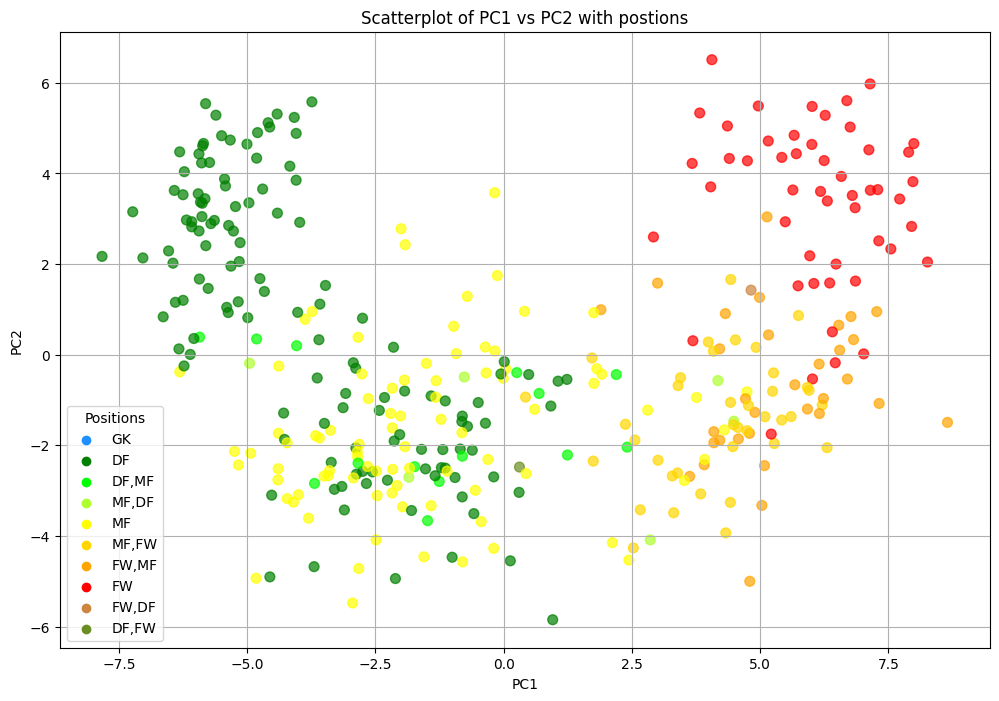

In [13]:
analyse_pcs(pc_a=1, pc_b=2)

In [14]:
def show_players(pc, latex=False):
    for pos in ('DF', 'MF', 'FW'):
        if latex:
            print(pc_scatter_df[pc_scatter_df['pos'] == pos].sort_values(f'PC{pc}')[['team', 'pos', f'PC{pc}']].head().round(2).to_latex(bold_rows=True))
            print(pc_scatter_df[pc_scatter_df['pos'] == pos].sort_values(f'PC{pc}')[['team', 'pos', f'PC{pc}']].tail().round(2).sort_values(f'PC{pc}', ascending=False).to_latex(bold_rows=True))

        else:
            display(pc_scatter_df[pc_scatter_df['pos'] == pos].sort_values(f'PC{pc}')[['team', 'pos', f'PC{pc}']].head())
            display(pc_scatter_df[pc_scatter_df['pos'] == pos].sort_values(f'PC{pc}')[['team', 'pos', f'PC{pc}']].tail())


In [15]:
show_players(1)

team pos       PC1
player                                            
Aleksandar Dragović   Leicester City  DF -7.826489
Davinson Sánchez           Tottenham  DF -7.228512
Joël Matip                 Liverpool  DF -7.030504
Shkodran Mustafi             Arsenal  DF -6.634671
Vincent Kompany      Manchester City  DF -6.529698

team pos       PC1
player                                     
Héctor Bellerín       Arsenal  DF  0.489330
Ryan Bertrand     Southampton  DF  0.921051
Arthur Masuaku       West Ham  DF  0.956968
Martin Olsson    Swansea City  DF  1.062431
Séamus Coleman        Everton  DF  1.234435

team pos       PC1
player                                     
Claudio Yacob       West Brom  MF -6.312314
Dale Stephens        Brighton  MF -5.244210
Jonathan Hogg    Huddersfield  MF -5.168058
Ben Watson            Watford  MF -4.929853
Ander Herrera  Manchester Utd  MF -4.823283

team pos       PC1
player                                               
Will Hughes                     Watford  MF  3.523680
Ruben Loftus-Cheek       Crystal Palace  MF  3.760855
Jóhann Berg Guðmundsson         Burnley  MF  3.919242
João Mário                     West Ham  MF  4.301093
Aaron Lennon                    Burnley  MF  4.743610

team pos       PC1
player                                      
Joselu           Newcastle Utd  FW  2.920737
Andy Carroll          West Ham  FW  3.675221
Juan Mata       Manchester Utd  FW  3.689822
Charlie Austin     Southampton  FW  3.822959
Wilfried Bony     Swansea City  FW  4.036767

team pos       PC1
player                                      
Jamie Vardy     Leicester City  FW  7.894879
Mohamed Salah        Liverpool  FW  7.952764
Sergio Agüero  Manchester City  FW  7.977948
Romelu Lukaku   Manchester Utd  FW  7.995982
Oumar Niasse           Everton  FW  8.262369

To further support this claim, present players with smallest and biggest PC2 values per position

In [16]:
show_players(2)

team pos       PC2
player                                            
Arthur Masuaku              West Ham  DF -5.850321
Aaron Wan-Bissaka     Crystal Palace  DF -4.942309
Oleksandr Zinchenko  Manchester City  DF -4.905122
Kyle Naughton           Swansea City  DF -4.679531
Ben Chilwell          Leicester City  DF -4.550557

team pos       PC2
player                                        
Scott Dann        Crystal Palace  DF  5.235842
Chris Smalling    Manchester Utd  DF  5.284649
Eliaquim Mangala         Everton  DF  5.310166
Shane Duffy             Brighton  DF  5.538861
Wes Morgan        Leicester City  DF  5.578642

team pos       PC2
player                                     
Mikel Merino    Newcastle Utd  MF -5.481584
Ander Herrera  Manchester Utd  MF -4.935335
Lewis Cook        Bournemouth  MF -4.719047
Cesc Fàbregas         Chelsea  MF -4.573522
Robbie Brady          Burnley  MF -4.533719

team pos       PC2
player                                           
Sam Clucas             Swansea City  MF  1.286531
Georginio Wijnaldum       Liverpool  MF  1.745393
Matty James          Leicester City  MF  2.424637
Marouane Fellaini    Manchester Utd  MF  2.778455
Andy King            Leicester City  MF  3.573564

team pos       PC2
player                                       
Theo Walcott            Everton  FW -1.753422
Roberto Firmino       Liverpool  FW -0.536351
Yannick Bolasie         Everton  FW -0.179779
Anthony Martial  Manchester Utd  FW  0.016819
Juan Mata        Manchester Utd  FW  0.306418

team pos       PC2
player                                      
Chris Wood             Burnley  FW  5.477749
Peter Crouch        Stoke City  FW  5.487687
Manolo Gabbiadini  Southampton  FW  5.605526
Andre Gray             Watford  FW  5.974913
Sam Vokes              Burnley  FW  6.508723

### PC1 vs PC3

PC3 -> _centre play vs wing_play_

That is without a doubt most obvious one. Carrying ball into the top 3rd, throw-ins%, pen area crosses, cross_pass_pct, progression per carry will by far be easier for wingers.

On the other hand, players in the centre will have a lot of passes, bigger through pass pct and better xG per shot (as they shoot from in front of the goal, duh.)

Also - notice the diagonal nature of Defenders. That makes perfect sense, as those playing on the wings will always have higher attacking involvement.

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC3: ('throwin_pass_pct', 'dead_pass_pct', 'pen_cross_pct', 'cross_pass_pct', 'prg_distance_per_carry', 'clearences_per_games_vs_team', 'prg_distance_pct', 'prg_carry_pct', 'avg_pass_prg_distance', 'blocked_pass_pct')
Bottom features PC3: ('tackles_mid3_per_games_vs_team', 'third_pass_pct', 'receives_per_game_vs_team', 'through_pass_pct', 'touches_mid3_per_game_vs_team', 'cmp_pass_vs_team', 'prg_pass_pct', 'carries_p

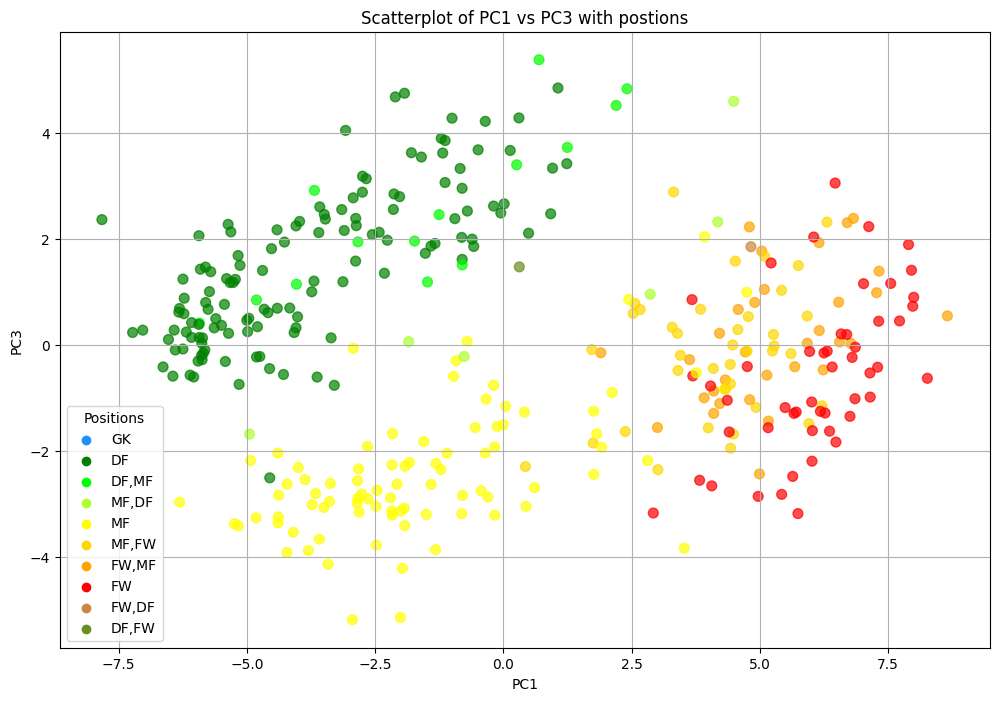

team pos       PC3
player                                            
Oleksandr Zinchenko  Manchester City  DF -2.505100
Fabian Delph         Manchester City  DF -0.761054
Antonio Rüdiger              Chelsea  DF -0.743170
Nacho Monreal                Arsenal  DF -0.605452
Nicolás Otamendi     Manchester City  DF -0.604352

team pos       PC3
player                                         
Scott Malone         Huddersfield  DF  4.274712
Danny Rose              Tottenham  DF  4.279911
Aaron Wan-Bissaka  Crystal Palace  DF  4.676201
Charlie Taylor            Burnley  DF  4.744781
Martin Olsson        Swansea City  DF  4.843833

team pos       PC3
player                                        
Mikel Merino       Newcastle Utd  MF -5.179826
Danny Drinkwater         Chelsea  MF -5.136873
Adrien Silva      Leicester City  MF -4.212041
Pedro Obiang            West Ham  MF -4.133227
Étienne Capoue           Watford  MF -3.913834

team pos       PC3
player                                             
Philip Billing           Huddersfield  MF -0.061644
Sam Clucas               Swansea City  MF  0.069401
Robbie Brady                  Burnley  MF  0.858993
Aaron Lennon                  Burnley  MF  0.993669
Jóhann Berg Guðmundsson       Burnley  MF  2.039574

team pos       PC3
player                                    
Stefano Okaka        Watford  FW -3.179081
Joselu         Newcastle Utd  FW -3.168258
Peter Crouch      Stoke City  FW -2.854245
Glenn Murray        Brighton  FW -2.816623
Sam Vokes            Burnley  FW -2.656413

team pos       PC3
player                                                  
Theo Walcott                       Everton  FW  1.545226
Jamie Vardy                 Leicester City  FW  1.892250
Leroy Sané                 Manchester City  FW  2.034055
Pierre-Emerick Aubameyang          Arsenal  FW  2.230723
Yannick Bolasie                    Everton  FW  3.052105

In [17]:
analyse_pcs(pc_a=1, pc_b=3)
show_players(3)

### PC1 vs PC4

PC4 -> _on-the-ball vs off-the-ball play_

That is somewhat more sophisticated distinction, but it really shows whether a given player takes initiative in ball possession and distribute it,

or tends to rather play without the ball and either be a tough defender, or look for scoring opportunities as a poacher or a finisher.

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC4: ('switch_pass_pct', 'long_pass_cmp_pct', 'prg_distance_per_carry', 'distance_per_carry', 'avg_pass_distance', 'carries_per_game_vs_team', 'receives_per_game_vs_team', 'prg_distance_pct', 'prg_pass_pct', 'medium_pass_cmp_pct')
Bottom features PC4: ('short_pass_cmp_pct', 'tackles_per_games_vs_team', 'tackles_won_per_games_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', 'tackles_def3

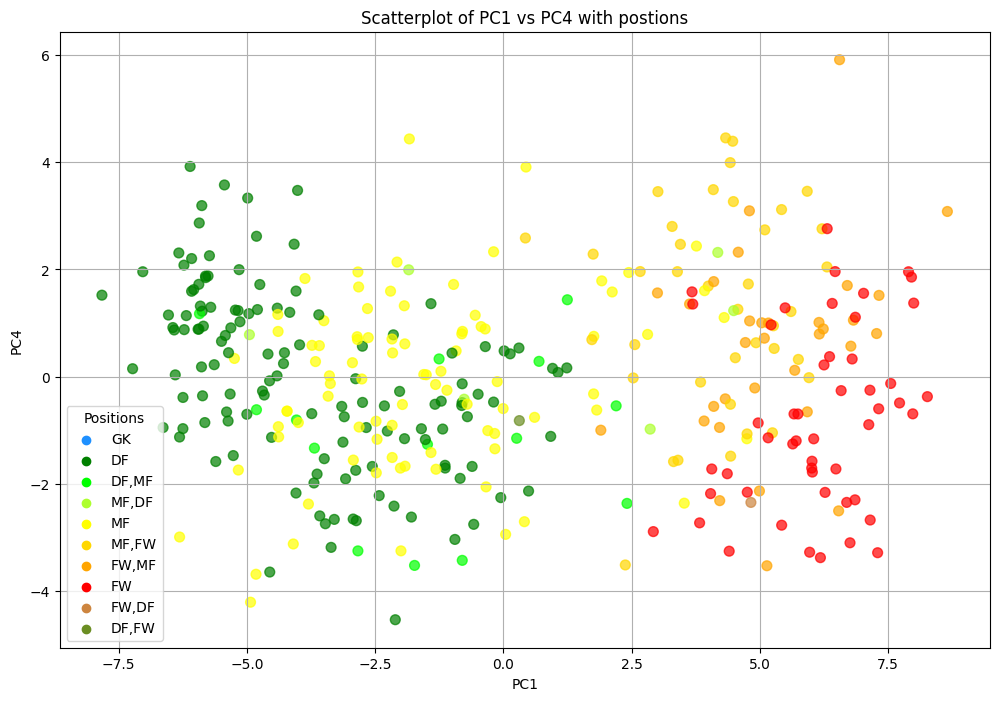

team pos       PC4
player                                            
Aaron Wan-Bissaka     Crystal Palace  DF -4.536607
Oleksandr Zinchenko  Manchester City  DF -3.647049
Danilo               Manchester City  DF -3.186559
Serge Aurier               Tottenham  DF -3.038248
Luke Shaw             Manchester Utd  DF -2.756767

team pos       PC4
player                                         
Virgil van Dijk       Southampton  DF  3.191063
José Fonte               West Ham  DF  3.331905
Harry Maguire      Leicester City  DF  3.474561
Alfie Mawson         Swansea City  DF  3.576529
Toby Alderweireld       Tottenham  DF  3.921282

team pos       PC4
player                                         
Ben Watson                Watford  MF -4.209637
Ander Herrera      Manchester Utd  MF -3.687917
Marouane Fellaini  Manchester Utd  MF -3.251431
Wilfred Ndidi      Leicester City  MF -3.122951
Claudio Yacob           West Brom  MF -2.993154

team pos       PC4
player                                          
Steven Defour              Burnley  MF  2.137774
Renato Sanches        Swansea City  MF  2.330200
Ruben Loftus-Cheek  Crystal Palace  MF  2.435776
Paul Pogba          Manchester Utd  MF  3.910598
Jonjo Shelvey        Newcastle Utd  MF  4.435550

team pos       PC4
player                                       
Gabriel Jesus   Manchester City  FW -3.378377
Jermain Defoe       Bournemouth  FW -3.286167
Shane Long          Southampton  FW -3.277069
Tomer Hemed            Brighton  FW -3.257490
Guido Carrillo      Southampton  FW -3.101042

team pos       PC4
player                                       
Andy Carroll           West Ham  FW  1.581545
Mohamed Salah         Liverpool  FW  1.856822
Jamie Vardy      Leicester City  FW  1.957004
Yannick Bolasie         Everton  FW  1.960295
Harry Kane            Tottenham  FW  2.760665

In [18]:
analyse_pcs(pc_a=1, pc_b=4)
show_players(4)

### PC2 vs PC4

I will make an exception here, and show the physicality vs on-off the ball distinction. What I have in mind here is that more athletic CBs have a lot of the ball, but more atheltic offensive players have less of it.

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('challenges_per_games_vs_team', 'tackles_per_games_vs_team', 'tackles_won_per_games_vs_team', 'standard_dist', 'carries_per_game_vs_team', 'tackles_mid3_per_games_vs_team', 'challenges_won_per_games_vs_team', 'touches_per_game_vs_team', 'receives_per_game_vs_team', 'carries3rd_per_carries')

Top features PC4: ('switch_pass_pct', 'long_pass_cmp_pct', 'prg_distance_per_carry', 'distance_per_carry', 'avg_pass_distance', 'carries_per_game_vs_team', 'receives_per_game_vs_team', 'prg_distance_pct', 'prg_pass_pct', 'medium_pass_cmp_pct')
Bottom features PC4: ('short_pass_cmp_pct', 'tackles_per_games_vs_team', 'tackles_won_per_games_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', 'tackles

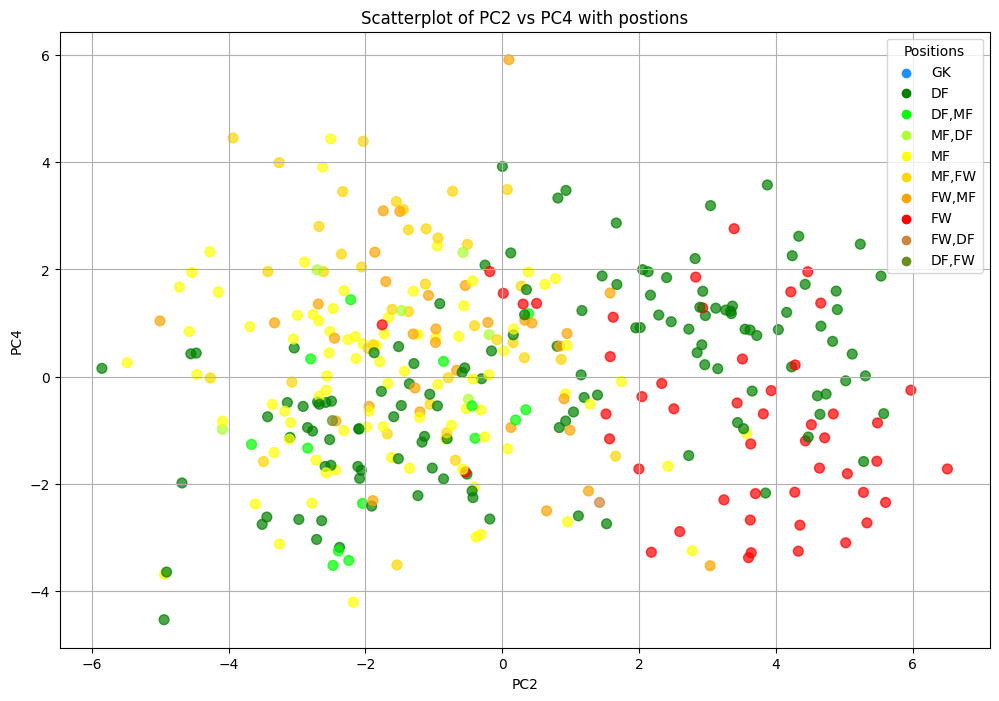

In [19]:
analyse_pcs(pc_a=2, pc_b=4)

### PC1 vs PC5

PC5 -> _passing vs possession_ ???

This is where it gets tough. It is kind of similar to PC4, but also more explicit in showing the distinction between chance creation for long dribbles and good opportunities vs long-ball passing and long shots

It is somewhat seen if we compare the types of strikers with high and low PC5 values.

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC5: ('dead_pass_pct', 'third_pass_pct', 'long_pass_cmp_pct', 'prg_pass_pct', 'pen_cross_pct', 'cross_pass_pct', 'avg_pass_prg_distance', 'throwin_pass_pct', 'switch_pass_pct', 'standard_dist')
Bottom features PC5: ('prg_distance_per_carry', 'distance_per_carry', 'prg_distance_pct', 'cmp_pass_vs_team', 'prg_carry_pct', 'takeons_per_game_vs_team', 'carries_pa_per_carries', 'carries3rd_per_carries', 'expected_npxg/sh',

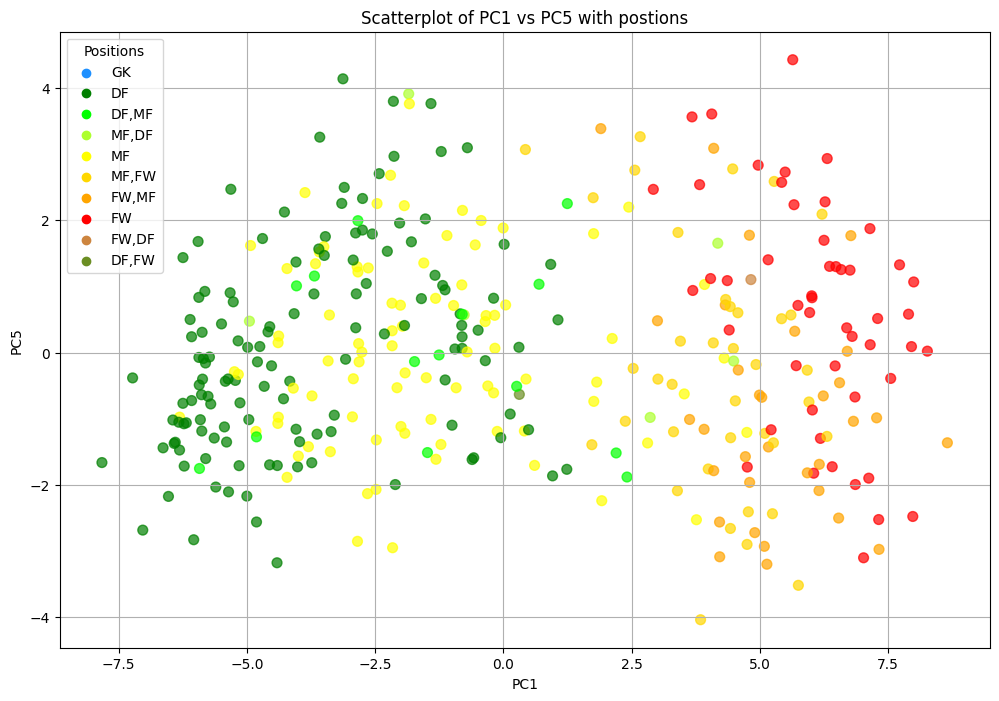

team pos       PC5
player                                         
Eliaquim Mangala          Everton  DF -3.175083
Nicolás Otamendi  Manchester City  DF -2.827170
Joël Matip              Liverpool  DF -2.681829
Ragnar Klavan           Liverpool  DF -2.558999
Vincent Kompany   Manchester City  DF -2.172672

team pos       PC5
player                                      
Cédric Soares      Southampton  DF  3.093935
Paul Dummett     Newcastle Utd  DF  3.253258
Aaron Cresswell       West Ham  DF  3.760817
Glen Johnson        Stoke City  DF  3.795116
Phil Bardsley          Burnley  DF  4.134870

team pos       PC5
player                                          
Emre Can                 Liverpool  MF -2.947899
Mario Lemina           Southampton  MF -2.851225
Ruben Loftus-Cheek  Crystal Palace  MF -2.525094
Jack Wilshere              Arsenal  MF -2.237608
Mousa Dembélé            Tottenham  MF -2.130626

team pos       PC5
player                                       
Gareth Barry          West Brom  MF  2.218865
Yohan Cabaye     Crystal Palace  MF  2.250317
Ashley Westwood         Burnley  MF  2.416427
Darren Fletcher      Stoke City  MF  2.678186
Jonjo Shelvey     Newcastle Utd  MF  3.757696

team pos       PC5
player                                                  
Anthony Martial             Manchester Utd  FW -3.099756
Raheem Sterling            Manchester City  FW -2.522197
Sergio Agüero              Manchester City  FW -2.475831
Son Heung-min                    Tottenham  FW -1.993286
Pierre-Emerick Aubameyang          Arsenal  FW -1.897215

team pos       PC5
player                                
Peter Crouch  Stoke City  FW  2.829979
Harry Kane     Tottenham  FW  2.930569
Andy Carroll    West Ham  FW  3.559722
Sam Vokes        Burnley  FW  3.603779
Troy Deeney      Watford  FW  4.423171

In [20]:
analyse_pcs(pc_a=1, pc_b=5)
show_players(5)

### PC3 vs PC5

Similar case here. Wing Full Backs prefer passing and getting rid of the ball. Wing attackers often do take-ons and dribbles into the penalty area

Top features PC3: ('throwin_pass_pct', 'dead_pass_pct', 'pen_cross_pct', 'cross_pass_pct', 'prg_distance_per_carry', 'clearences_per_games_vs_team', 'prg_distance_pct', 'prg_carry_pct', 'avg_pass_prg_distance', 'blocked_pass_pct')
Bottom features PC3: ('tackles_mid3_per_games_vs_team', 'third_pass_pct', 'receives_per_game_vs_team', 'through_pass_pct', 'touches_mid3_per_game_vs_team', 'cmp_pass_vs_team', 'prg_pass_pct', 'carries_per_game_vs_team', 'g_xg_ratio', 'challenges_per_games_vs_team')

Top features PC5: ('dead_pass_pct', 'third_pass_pct', 'long_pass_cmp_pct', 'prg_pass_pct', 'pen_cross_pct', 'cross_pass_pct', 'avg_pass_prg_distance', 'throwin_pass_pct', 'switch_pass_pct', 'standard_dist')
Bottom features PC5: ('prg_distance_per_carry', 'distance_per_carry', 'prg_distance_pct', 'cmp_pass_vs_team', 'prg_carry_pct', 'takeons_per_game_vs_team', 'carries_pa_per_carries', 'carries3rd_per_carries', 'expected_npxg/sh', 'succ_takeons_vs_team')


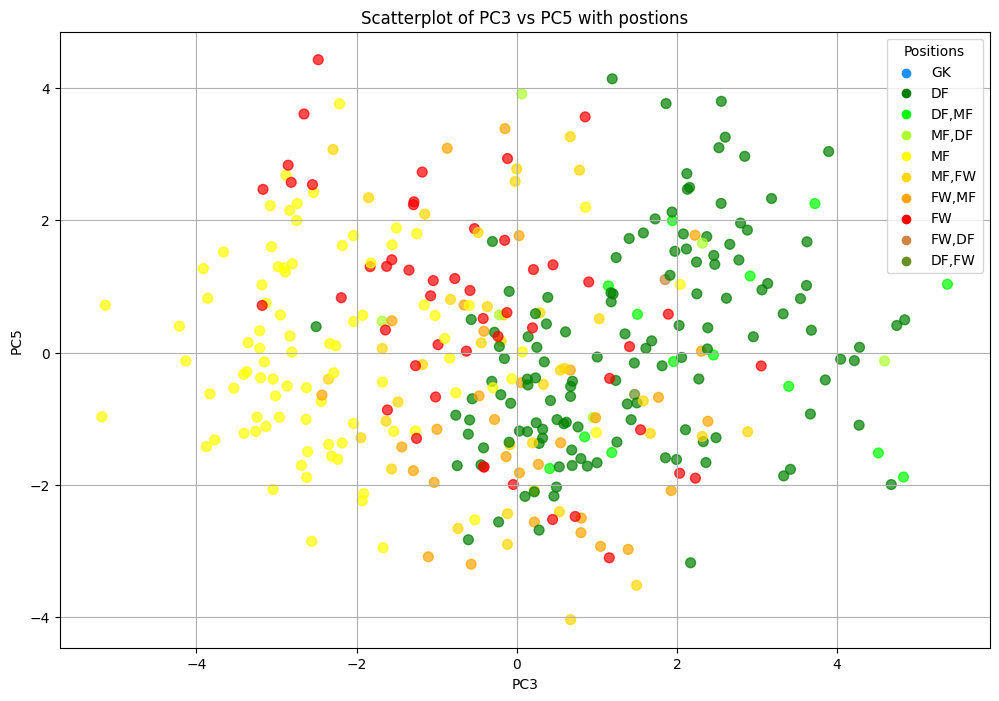

In [21]:
analyse_pcs(pc_a=3, pc_b=5)

### PC1 vs PC6

PC6 -> _defensive work rate in midfield_ ???

Again, cannot be too sure about the actual distinction here, but it appears that players with high PC6 work a lot towards intercepting the ball attcking and mid 3rds. 

When that happens, they either try to quickly pass the ball to the nearest colleague 
(high short passes %), give a through ball (high through ball %) or shoot on goal (high shooting distance).

On the other hand, players that dribble a lot, cross, have good scoring opportunities (finishers) will not work a lot to get the ball back after a loss.

NOTE: Notice how g_xg_ratio negatively contributes by a lot. My conspiracy theory says that xG is rigged and high g_xg ratio shows the opportunities were better than xg would suggest.

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC6: ('live_pass_pct', 'long_pass_cmp_pct', 'blocks_per_games_vs_team', 'switch_pass_pct', 'tackles_won_per_games_vs_team', 'tackles_per_games_vs_team', 'avg_pass_distance', 'challenges_per_games_vs_team', 'tackles_mid3_per_games_vs_team', 'prg_pass_pct')
Bottom features PC6: ('receives_per_game_vs_team', 'carries_per_game_vs_team', 'touches_per_game_vs_team', 'touches_mid3_per_game_vs_team', 'short_pass_cmp_pct', 's

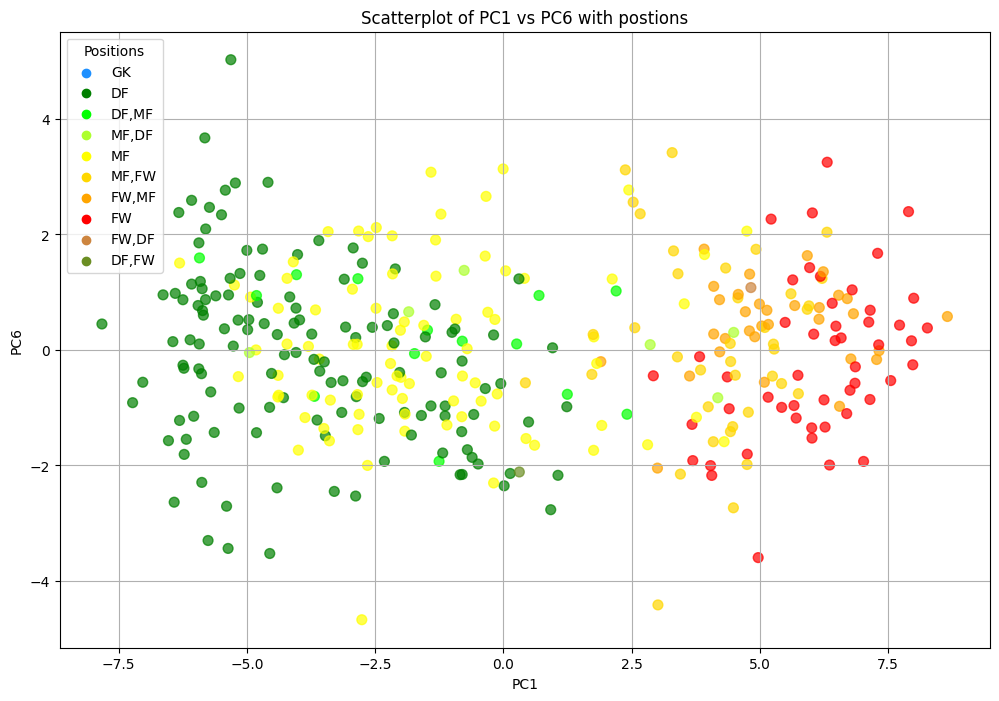

team pos       PC6
player                                            
Oleksandr Zinchenko  Manchester City  DF -3.525062
Daniel Amartey        Leicester City  DF -3.437192
Aymeric Laporte      Manchester City  DF -3.299996
Ryan Bertrand            Southampton  DF -2.766683
Victor Lindelöf       Manchester Utd  DF -2.706286

team pos       PC6
player                                      
Christian Kabasele     Watford  DF  2.766423
Ahmed Hegazi         West Brom  DF  2.890640
Ryan Shawcross      Stoke City  DF  2.902539
Kevin Long             Burnley  DF  3.671956
Gareth McAuley       West Brom  DF  5.025688

team pos       PC6
player                                      
Mohamed Elneny         Arsenal  MF -4.671781
Renato Sanches    Swansea City  MF -2.303774
Mousa Dembélé        Tottenham  MF -1.999672
Jason Puncheon  Crystal Palace  MF -1.738181
Roque Mesa        Swansea City  MF -1.735120

team pos       PC6
player                                  
Leroy Fer     Swansea City  MF  2.352105
Beram Kayal       Brighton  MF  2.659155
Robbie Brady       Burnley  MF  2.770009
Badou Ndiaye    Stoke City  MF  3.077887
Sam Field        West Brom  MF  3.134379

team pos       PC6
player                                       
Peter Crouch         Stoke City  FW -3.596067
Sam Vokes               Burnley  FW -2.172905
Wilfried Bony      Swansea City  FW -2.003049
Salomón Rondón        West Brom  FW -1.993045
Anthony Martial  Manchester Utd  FW -1.930540

team pos       PC6
player                                       
Jermain Defoe       Bournemouth  FW  1.673244
Theo Walcott            Everton  FW  2.265468
Roberto Firmino       Liverpool  FW  2.373051
Jamie Vardy      Leicester City  FW  2.395392
Harry Kane            Tottenham  FW  3.250581

In [22]:
analyse_pcs(pc_a=1, pc_b=6)
show_players(6)

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('challenges_per_games_vs_team', 'tackles_per_games_vs_team', 'tackles_won_per_games_vs_team', 'standard_dist', 'carries_per_game_vs_team', 'tackles_mid3_per_games_vs_team', 'challenges_won_per_games_vs_team', 'touches_per_game_vs_team', 'receives_per_game_vs_team', 'carries3rd_per_carries')

Top features PC6: ('live_pass_pct', 'long_pass_cmp_pct', 'blocks_per_games_vs_team', 'switch_pass_pct', 'tackles_won_per_games_vs_team', 'tackles_per_games_vs_team', 'avg_pass_distance', 'challenges_per_games_vs_team', 'tackles_mid3_per_games_vs_team', 'prg_pass_pct')
Bottom features PC6: ('receives_per_game_vs_team', 'carries_per_game_vs_team', 'touches_per_game_vs_team', 'touches_mid3_per_game_vs_team', 'short_pass_cmp_pct

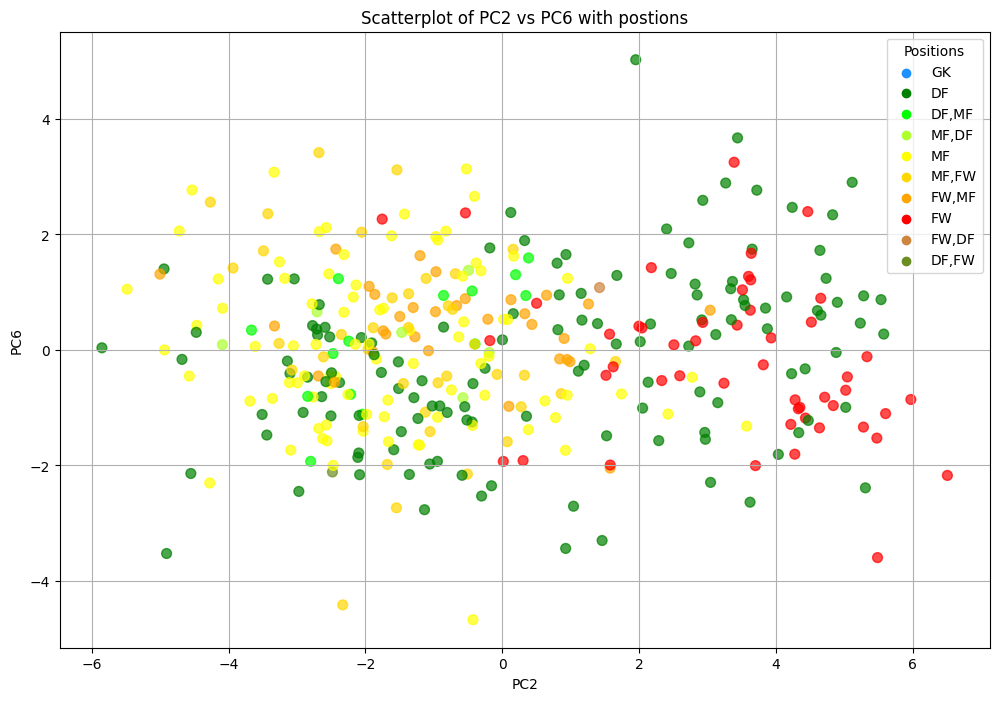

team pos       PC6
player                                            
Oleksandr Zinchenko  Manchester City  DF -3.525062
Daniel Amartey        Leicester City  DF -3.437192
Aymeric Laporte      Manchester City  DF -3.299996
Ryan Bertrand            Southampton  DF -2.766683
Victor Lindelöf       Manchester Utd  DF -2.706286

team pos       PC6
player                                      
Christian Kabasele     Watford  DF  2.766423
Ahmed Hegazi         West Brom  DF  2.890640
Ryan Shawcross      Stoke City  DF  2.902539
Kevin Long             Burnley  DF  3.671956
Gareth McAuley       West Brom  DF  5.025688

team pos       PC6
player                                      
Mohamed Elneny         Arsenal  MF -4.671781
Renato Sanches    Swansea City  MF -2.303774
Mousa Dembélé        Tottenham  MF -1.999672
Jason Puncheon  Crystal Palace  MF -1.738181
Roque Mesa        Swansea City  MF -1.735120

team pos       PC6
player                                  
Leroy Fer     Swansea City  MF  2.352105
Beram Kayal       Brighton  MF  2.659155
Robbie Brady       Burnley  MF  2.770009
Badou Ndiaye    Stoke City  MF  3.077887
Sam Field        West Brom  MF  3.134379

team pos       PC6
player                                       
Peter Crouch         Stoke City  FW -3.596067
Sam Vokes               Burnley  FW -2.172905
Wilfried Bony      Swansea City  FW -2.003049
Salomón Rondón        West Brom  FW -1.993045
Anthony Martial  Manchester Utd  FW -1.930540

team pos       PC6
player                                       
Jermain Defoe       Bournemouth  FW  1.673244
Theo Walcott            Everton  FW  2.265468
Roberto Firmino       Liverpool  FW  2.373051
Jamie Vardy      Leicester City  FW  2.395392
Harry Kane            Tottenham  FW  3.250581

In [26]:
analyse_pcs(pc_a=2, pc_b=6)
show_players(6)

### PC1 vs PC7

PC7 -> _Pure finishing ability - dead ball poachers vs live ball progressors_

Higher variance for defensive players can be explained by small amount of scoring chances during the season. Low variance for forwards stems from the opposite argument.


In [24]:
print(np.sum(pca.explained_variance_ratio_[:6]))
print(pca.explained_variance_ratio_[6])

0.7535777127389099
0.02531143956377483


Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC7: ('g_xg_ratio', 'standard_sot%', 'expected_npxg/sh', 'touches_per_game_vs_team', 'dead_pass_pct', 'tackles_att3_per_games_vs_team', 'clearences_per_games_vs_team', 'throwin_pass_pct', 'receives_per_game_vs_team', 'prg_distance_pct')
Bottom features PC7: ('live_pass_pct', 'distance_per_carry', 'takeons_per_game_vs_team', 'prg_pass_pct', 'standard_dist', 'switch_pass_pct', 'cmp_pass_vs_team', 'prg_carry_pct', 'thir

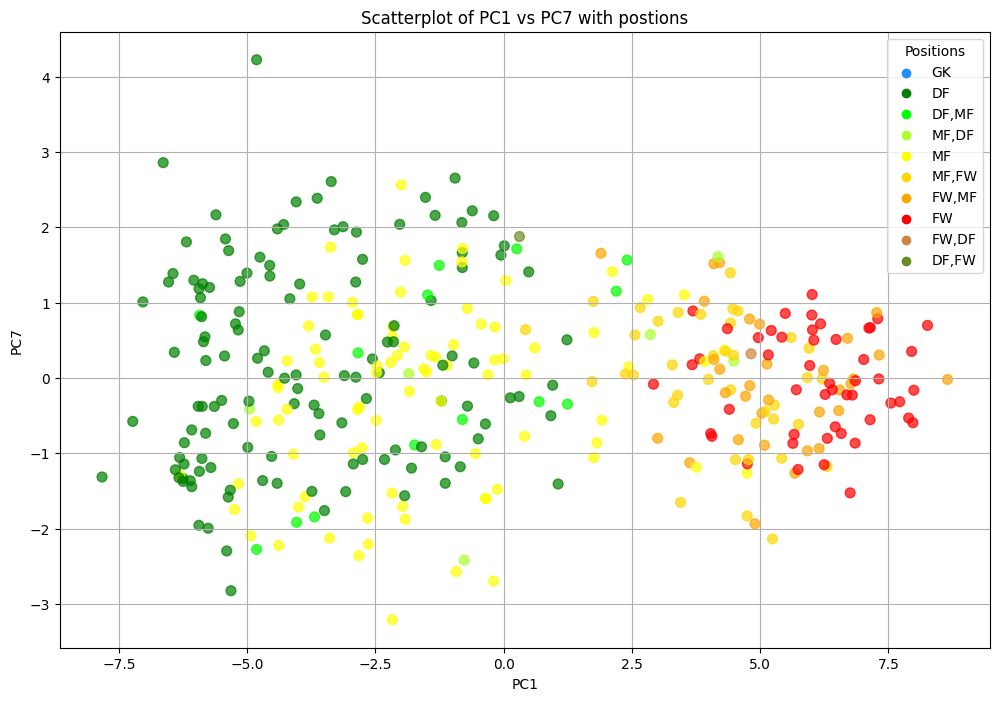

team pos       PC7
player                                            
Gareth McAuley             West Brom  DF -2.825429
Victor Lindelöf       Manchester Utd  DF -2.297537
Aymeric Laporte      Manchester City  DF -1.995723
Winston Reid                West Ham  DF -1.956757
Timothy Fosu-Mensah   Crystal Palace  DF -1.761400

team pos       PC7
player                                         
Daryl Janmaat             Watford  DF  2.397388
Danilo            Manchester City  DF  2.607399
Serge Aurier            Tottenham  DF  2.653295
Shkodran Mustafi          Arsenal  DF  2.858444
Ragnar Klavan           Liverpool  DF  4.225031

team pos       PC7
player                                           
Scott McTominay      Manchester Utd  MF -3.210477
Renato Sanches         Swansea City  MF -2.696996
Danny Williams         Huddersfield  MF -2.571933
Lewis Cook              Bournemouth  MF -2.360781
Morgan Schneiderlin         Everton  MF -2.225241

team pos       PC7
player                                           
Steven Davis            Southampton  MF  1.541986
Abdoulaye Doucouré          Watford  MF  1.560755
Cesc Fàbregas               Chelsea  MF  1.718922
Fernandinho         Manchester City  MF  1.735395
Marouane Fellaini    Manchester Utd  MF  2.563430

team pos       PC7
player                                   
Guido Carrillo  Southampton  FW -1.526044
Stefano Okaka       Watford  FW -1.215834
Saido Berahino   Stoke City  FW -1.151927
Benik Afobe     Bournemouth  FW -1.139807
Troy Deeney         Watford  FW -0.868694

team pos       PC7
player                                        
Jermain Defoe        Bournemouth  FW  0.786219
Cenk Tosun               Everton  FW  0.834793
Javier Hernández        West Ham  FW  0.856931
Juan Mata         Manchester Utd  FW  0.889012
Chris Wood               Burnley  FW  1.107203

In [25]:
analyse_pcs(pc_a=1, pc_b=7)
show_players(7)

### PC1 vs PC8

PC8 -> _Pure finishing ability_

Higher variance for defensive players can be explained by small amount of scoring chances during the season. Low variance for forwards stems from the opposite argument.

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('touches_def3_per_game_vs_team', 'touches_defpen_per_game_vs_team', 'medium_pass_cmp_pct', 'clearences_per_games_vs_team', 'avg_pass_distance', 'interceptions_per_games_vs_team', 'avg_pass_prg_distance', 'tackles_def3_per_games_vs_team', 'touches_mid3_per_game_vs_team', 'aerial_duels_won%')

Top features PC8: ('succ_takeons_vs_team', 'third_pass_pct', 'aerial_duels_won%', 'prg_pass_pct', 'live_pass_pct', 'prg_distance_pct', 'touches_defpen_per_game_vs_team', 'receives_per_game_vs_team', 'clearences_per_games_vs_team', 'short_pass_cmp_pct')
Bottom features PC8: ('cmp_pass_vs_team', 'standard_dist', 'switch_pass_pct', 'long_pass_cmp_pct', 'through_pass_pct', 'avg_pass_distance', 'cross_pass_pct', 'tackles_att3_per_game

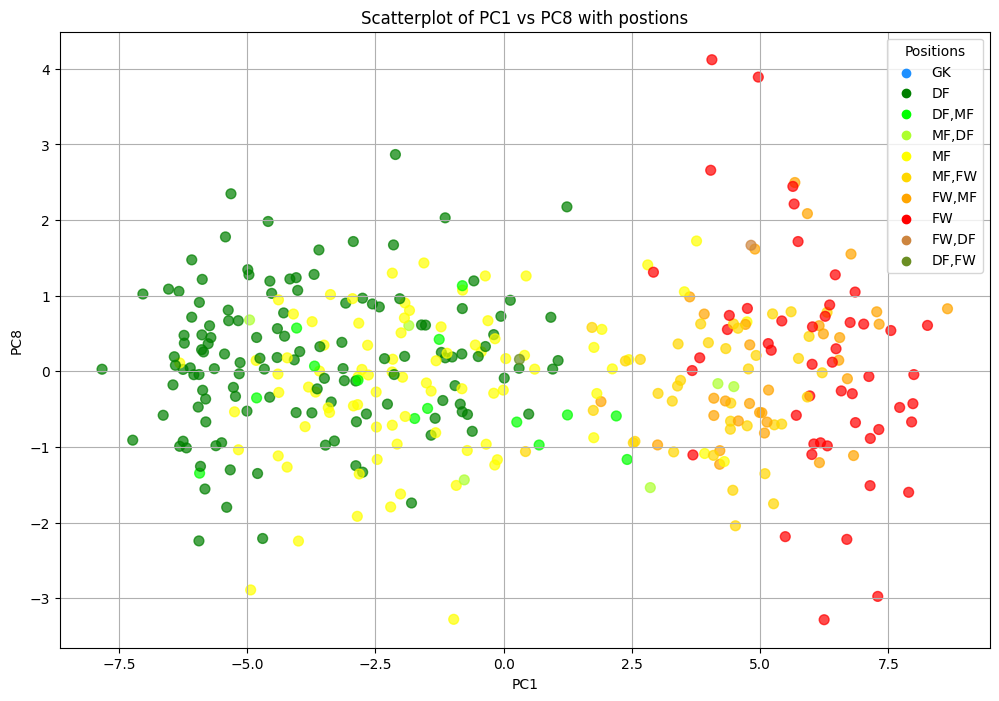

team pos       PC8
player                                          
Winston Reid              West Ham  DF -2.241306
Bruno Martins Indi      Stoke City  DF -2.209418
Victor Lindelöf     Manchester Utd  DF -1.796956
Allan Nyom               West Brom  DF -1.740105
Kevin Long                 Burnley  DF -1.555150

team pos       PC8
player                                         
Ryan Shawcross         Stoke City  DF  1.981755
Marvin Zeegelaar          Watford  DF  2.030098
Séamus Coleman            Everton  DF  2.174999
Gareth McAuley          West Brom  DF  2.348101
Aaron Wan-Bissaka  Crystal Palace  DF  2.866963

team pos       PC8
player                                     
Ki Sung-yueng    Swansea City  MF -3.278168
Ben Watson            Watford  MF -2.889517
Roque Mesa       Swansea City  MF -2.243438
Mark Noble           West Ham  MF -1.916438
Darren Fletcher    Stoke City  MF -1.792441

team pos       PC8
player                                           
Nathaniel Chalobah          Watford  MF  1.261521
Dan Gosling             Bournemouth  MF  1.298656
David Silva         Manchester City  MF  1.407809
James Milner              Liverpool  MF  1.433348
Ruben Loftus-Cheek   Crystal Palace  MF  1.723909

team pos       PC8
player                                         
Saido Berahino         Stoke City  FW -3.283436
Jermain Defoe         Bournemouth  FW -2.975211
Manolo Gabbiadini     Southampton  FW -2.221136
Javier Hernández         West Ham  FW -2.185065
Jamie Vardy        Leicester City  FW -1.598905

team pos       PC8
player                                         
Christian Benteke  Crystal Palace  FW  2.212878
Troy Deeney               Watford  FW  2.445297
Wilfried Bony        Swansea City  FW  2.658783
Peter Crouch           Stoke City  FW  3.890556
Sam Vokes                 Burnley  FW  4.120326

In [27]:
analyse_pcs(pc_a=1, pc_b=8)
show_players(8)

-----
-----
-----

## Cross-seasonal analysis

All the remaining seasons' stats will now be combined and transformed into the PC subspace accroding to a trained projection. 

That will help us establish the patterns across several seasons and determine anectodal changes in playing styles for different players

In [26]:
MIN_90S = 5.0
X_test = pd.concat(list(data.values())[1:], axis=0)
X_test = X_test[X_test['90s'] >= MIN_90S]
X_test = X_test.iloc[:, 6:]
print(X_test.shape)
display(X_test.head())

(1484, 52)


standard_sot%  standard_dist  expected_npxg/sh   
player                                                         
Lewis Dunk             20.0           14.1              0.09  \
Shane Duffy            37.8           10.6              0.08   
Davy Pröpper           13.3           15.9              0.06   
Glenn Murray           34.0           12.2              0.16   
Solly March            20.9           21.4              0.06   

              aerial_duels_won%  g_xg_ratio  cmp_pass_vs_team   
player                                                          
Lewis Dunk                 65.4    1.111111          1.159270  \
Shane Duffy                73.3    1.612903          1.052476   
Davy Pröpper               58.1    1.111111          1.100252   
Glenn Murray               49.1    1.140351          0.802355   
Solly March                21.8    0.400000          0.896502   

              avg_pass_distance  avg_pass_prg_distance  short_pass_cmp_pct   
player                                                                       
Lewis Dunk            21.626003               6.869181            0.304976  \
Shane Duffy           21.575481               8.007092            0.283688   
Davy Pröpper          17.704008               4.946557            0.436793   
Glenn Murray          12.079320               2.549575            0.665722   
Solly March           17.137124               4.392977            0.540134   

              medium_pass_cmp_pct  ...  succ_takeons_vs_team   
player                             ...                         
Lewis Dunk               0.484751  ...              0.000000  \
Shane Duffy              0.515704  ...              2.138658   
Davy Pröpper             0.425488  ...              1.266086   
Glenn Murray             0.203966  ...              0.855463   
Solly March              0.307692  ...              1.246838   

              carries_per_game_vs_team  distance_per_carry   
player                                                       
Lewis Dunk                    1.052463            5.068386  \
Shane Duffy                   0.883714            4.170300   
Davy Pröpper                  1.241804            4.977673   
Glenn Murray                  0.729714            2.926978   
Solly March                   1.118313            6.176550   

              prg_distance_per_carry  prg_distance_pct  prg_carry_pct   
player                                                                  
Lewis Dunk                  2.602018          0.513382       0.017937  \
Shane Duffy                 1.938692          0.464881       0.001362   
Davy Pröpper                2.155112          0.432956       0.032902   
Glenn Murray                0.766734          0.261954       0.024341   
Solly March                 2.749326          0.445123       0.087601   

              carries3rd_per_carries  carries_pa_per_carries   
player                                                         
Lewis Dunk                  0.012332                0.000000  \
Shane Duffy                 0.005450                0.000000   
Davy Pröpper                0.027027                0.001175   
Glenn Murray                0.028398                0.010142   
Solly March                 0.045822                0.024259   

              receives_per_game_vs_team  prgreceives_per_game_vs_team  
player                                                                 
Lewis Dunk                     1.106965                      0.062968  
Shane Duffy                    0.983014                      0.117797  
Davy Pröpper                   1.238098                      0.752793  
Glenn Murray                   0.978379                      1.790477  
Solly March                    1.063183                      2.788347  

[5 rows x 52 columns]

### Using the trained power transform to obtain transformed fature space

In [27]:
X_test_transformed = power_transform.transform(X_test)
X_test_transformed = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=X_test_transformed)
X_test_transformed.head()

standard_sot%  standard_dist  expected_npxg/sh   
player                                                         
Lewis Dunk        -0.452206      -0.670346          0.264172  \
Shane Duffy        0.655748      -1.237038          0.046616   
Davy Pröpper      -0.913783      -0.372848         -0.448669   
Glenn Murray       0.429587      -0.980061          1.370835   
Solly March       -0.392619       0.557135         -0.448669   

              aerial_duels_won%  g_xg_ratio  cmp_pass_vs_team   
player                                                          
Lewis Dunk             1.268435    0.588815          1.703450  \
Shane Duffy            1.813052    1.025157          0.294556   
Davy Pröpper           0.775425    0.588815          0.888199   
Glenn Murray           0.182671    0.617872         -2.005129   
Solly March           -1.483624   -0.340749         -1.282006   

              avg_pass_distance  avg_pass_prg_distance  short_pass_cmp_pct   
player                                                                       
Lewis Dunk             1.801461               0.785815           -1.606218  \
Shane Duffy            1.785400               1.239130           -1.762082   
Davy Pröpper           0.482813              -0.075995           -0.547010   
Glenn Murray          -1.744656              -1.419803            1.699396   
Solly March            0.278682              -0.353426            0.401015   

              medium_pass_cmp_pct  ...  succ_takeons_vs_team   
player                             ...                         
Lewis Dunk               1.117891  ...             -2.837455  \
Shane Duffy              1.398294  ...              4.078359   
Davy Pröpper             0.555605  ...              0.699159   
Glenn Murray            -1.904329  ...             -0.639056   
Solly March             -0.674204  ...              0.632662   

              carries_per_game_vs_team  distance_per_carry   
player                                                       
Lewis Dunk                    0.058061           -0.199762  \
Shane Duffy                  -0.659397           -1.122195   
Davy Pröpper                  0.884744           -0.285450   
Glenn Murray                 -1.297280           -2.765586   
Solly March                   0.343037            0.739940   

              prg_distance_per_carry  prg_distance_pct  prg_carry_pct   
player                                                                  
Lewis Dunk                 -0.072575          0.205427      -1.211724  \
Shane Duffy                -0.934870         -0.351316      -1.948908   
Davy Pröpper               -0.651622         -0.694803      -0.645154   
Glenn Murray               -2.509807         -2.247879      -0.958754   
Solly March                 0.116707         -0.565996       0.836857   

              carries3rd_per_carries  carries_pa_per_carries   
player                                                         
Lewis Dunk                 -1.330791               -1.099674  \
Shane Duffy                -1.691762               -1.099674   
Davy Pröpper               -0.627593               -0.928008   
Glenn Murray               -0.566370                0.096993   
Solly March                 0.153584                1.018261   

              receives_per_game_vs_team  prgreceives_per_game_vs_team  
player                                                                 
Lewis Dunk                     0.250017                     -1.369143  
Shane Duffy                   -0.296472                     -1.260606  
Davy Pröpper                   0.817122                     -0.260502  
Glenn Murray                  -0.317116                      0.830886  
Solly March                    0.058188                      1.581900  

[5 rows x 52 columns]

### Applying PCA transformation to test data

In [28]:
X_test_decomposed = pca.transform(X_test_transformed)
X_test_decomposed = pd.DataFrame(index=X_test.index, columns=(f"PC{i}" for i in range(1, len(X_train.columns) + 1)), data=X_test_decomposed)
print(X_test_decomposed.shape)
X_test_decomposed.head()

(1484, 52)


PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                     
Lewis Dunk   -5.463893  3.407355  0.098337  1.655838  0.152603  0.202528  \
Shane Duffy  -5.329969  5.557336 -0.101383  1.334649  0.163006  1.018262   
Davy Pröpper -1.673697 -0.592445 -3.256138  1.275981  0.859762  0.082243   
Glenn Murray  4.992386  5.336184 -2.275515 -2.581826  2.502104 -1.129063   
Solly March   4.019596 -2.607665  1.895741  0.673586  1.141252  1.794009   

                   PC7       PC8       PC9      PC10  ...      PC43      PC44   
player                                                ...                       
Lewis Dunk    0.463775 -2.460410  1.128724  2.848553  ... -0.076418 -0.113080  \
Shane Duffy   1.816731  0.877534  2.471120 -2.402824  ...  0.059399 -0.058569   
Davy Pröpper -0.933407  0.773585  0.238191 -0.191636  ...  0.077584  0.204349   
Glenn Murray -0.159742  1.238786  1.069726  0.385501  ... -0.102990  0.160801   
Solly March  -0.361773 -0.587852  2.249115 -0.779777  ...  0.055340  0.140419   

                  PC45      PC46      PC47      PC48      PC49      PC50   
player                                                                     
Lewis Dunk    0.219384 -0.067872  0.202262  0.046107 -0.074884  0.014746  \
Shane Duffy   0.001232 -0.103856 -0.043259  0.019642  0.108626  0.064976   
Davy Pröpper  0.047050  0.013147 -0.257614  0.111131  0.050336  0.003158   
Glenn Murray -0.222026  0.116058  0.086248 -0.004641  0.339392  0.270425   
Solly March   0.405553  0.092737 -0.001563 -0.162046  0.019478 -0.079737   

                  PC51      PC52  
player                            
Lewis Dunk    0.000179  0.105695  
Shane Duffy  -0.098653  0.086904  
Davy Pröpper -0.059011 -0.018953  
Glenn Murray -0.056776 -0.035975  
Solly March   0.088461  0.002579  

[5 rows x 52 columns]

### Adding season column to filter on

In [29]:
test_data = pd.concat(list(data.values())[1:], axis=0)
X_test_decomposed['season'] = test_data[test_data['90s'] >= MIN_90S]['season']
X_test_decomposed['season'].value_counts()

season
2021-2022    376
2020-2021    371
2019-2020    370
2018-2019    367
Name: count, dtype: int64

## Investigating similarity of PC maps across seasons

In [30]:
def draw_map(pc_a, pc_b):
    fig, ax = plt.subplots(2, 2, figsize=(18, 9), tight_layout=True)
    fig.suptitle(f"Scatterplot of PC{pc_a} vs PC{pc_b} with postions for seasons {seasons[1]} - {seasons[-1]}")

    for i, season in enumerate(seasons[1:]):
        row, col = i // 2, i % 2
        pc_scatter_df = pd.merge(data[season][['team', 'pos']], X_test_decomposed[X_test_decomposed['season'] == season], right_index=True, left_index=True)
        pc_scatter_df = pc_scatter_df[~pc_scatter_df.index.duplicated(keep='first')]

        ax[row, col].set_title(f"Season {season}")
        ax[row, col].scatter(x=pc_scatter_df[f'PC{pc_a}'], y=pc_scatter_df[f'PC{pc_b}'], c=list(map(lambda x: pos_color_map[x], pc_scatter_df['pos'])), s=50, alpha=0.7)
        ax[row, col].set_xlabel(f"PC{pc_a}")
        ax[row, col].set_ylabel(f"PC{pc_b}")
        ax[row, col].grid()

        # Plot a scatterplot for each unique color and label
        legend_handles = []
        for color in unique_colors:
            legend_handles.append(ax[row, col].scatter([], [], c=color))

        # Add legend to the plot
        ax[row, col].legend(legend_handles, legend_labels, title='Positions')

    plt.show()

We can conclude that these position manifolds tend to be cross-seasonally stable (at least as far as visual observations go)

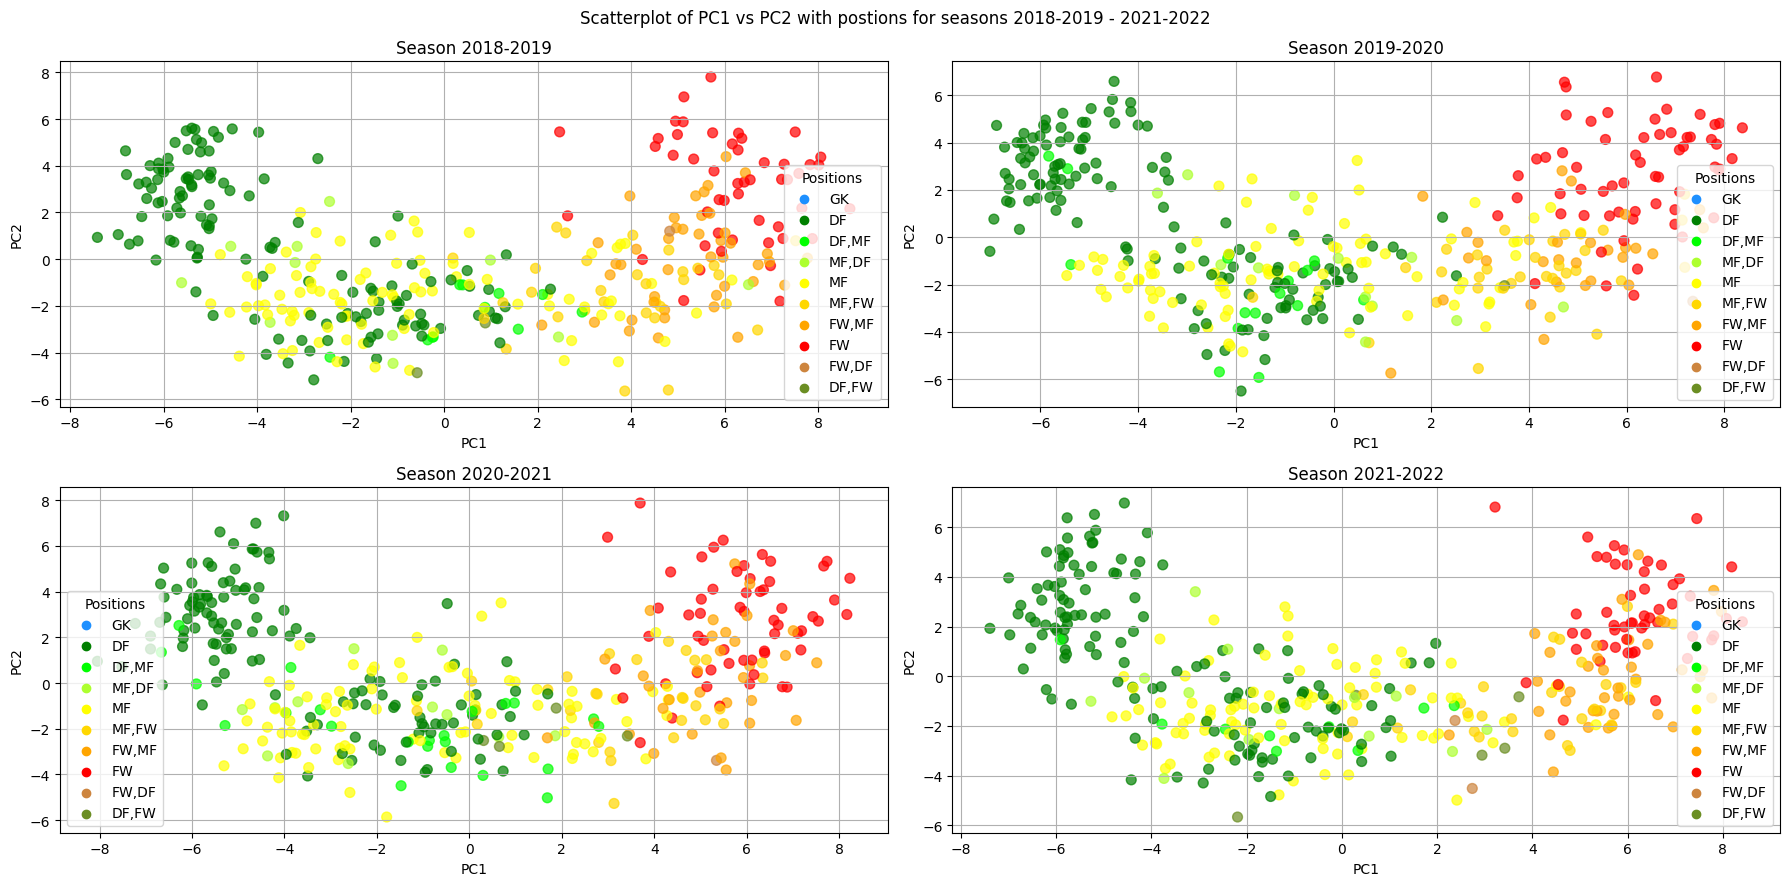

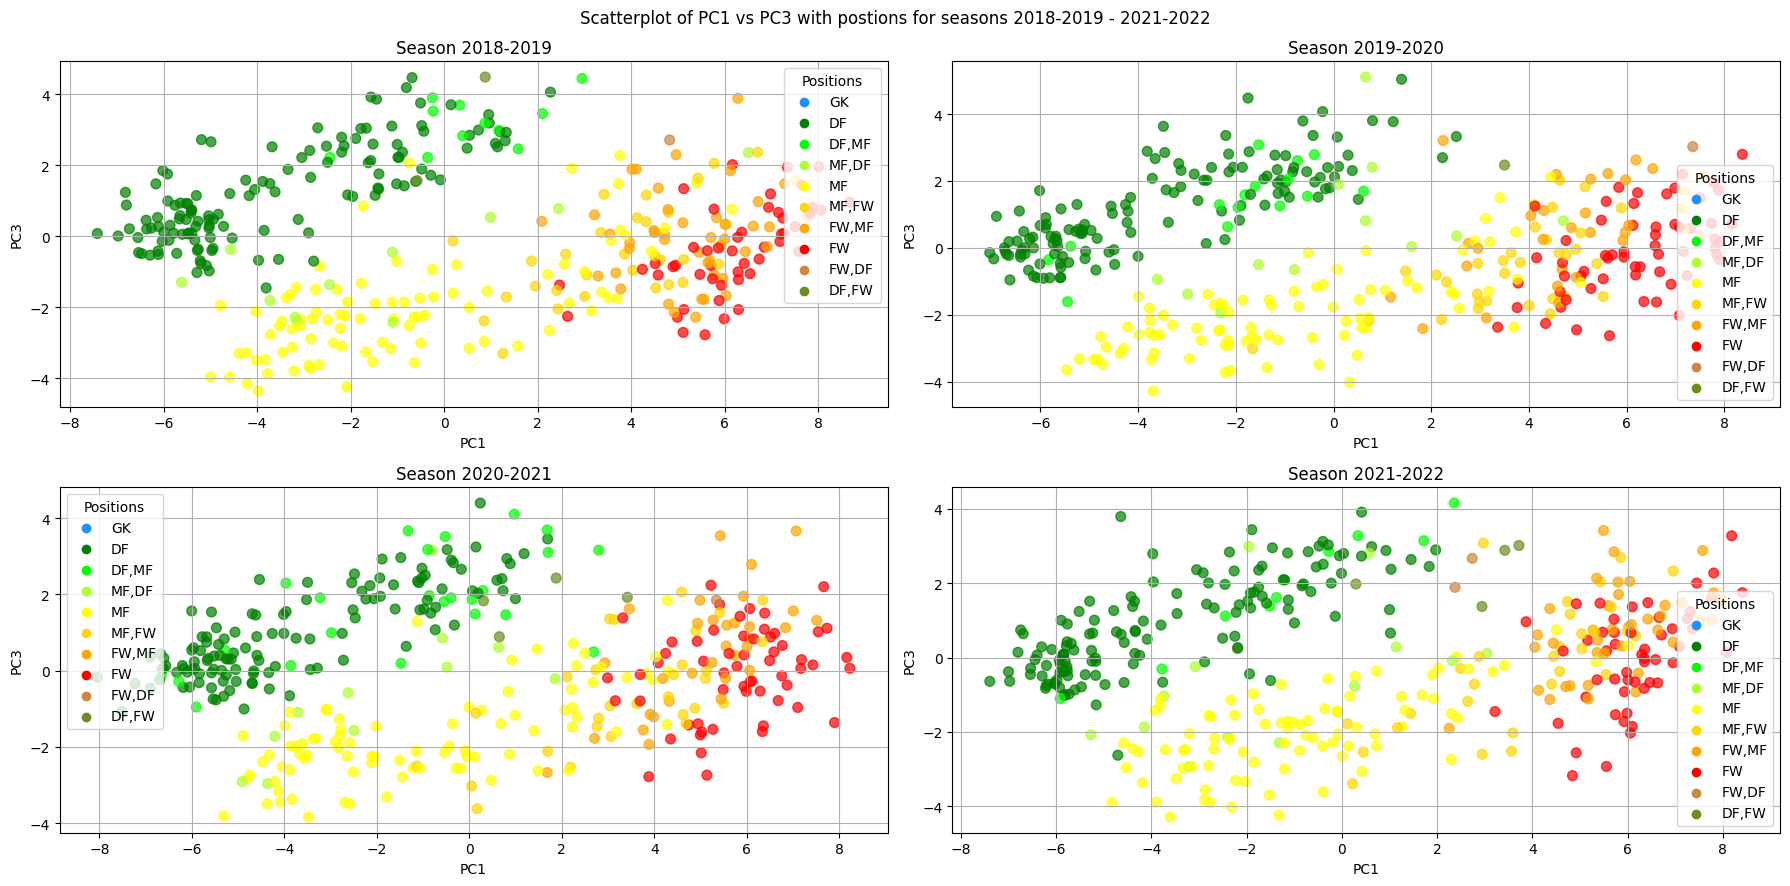

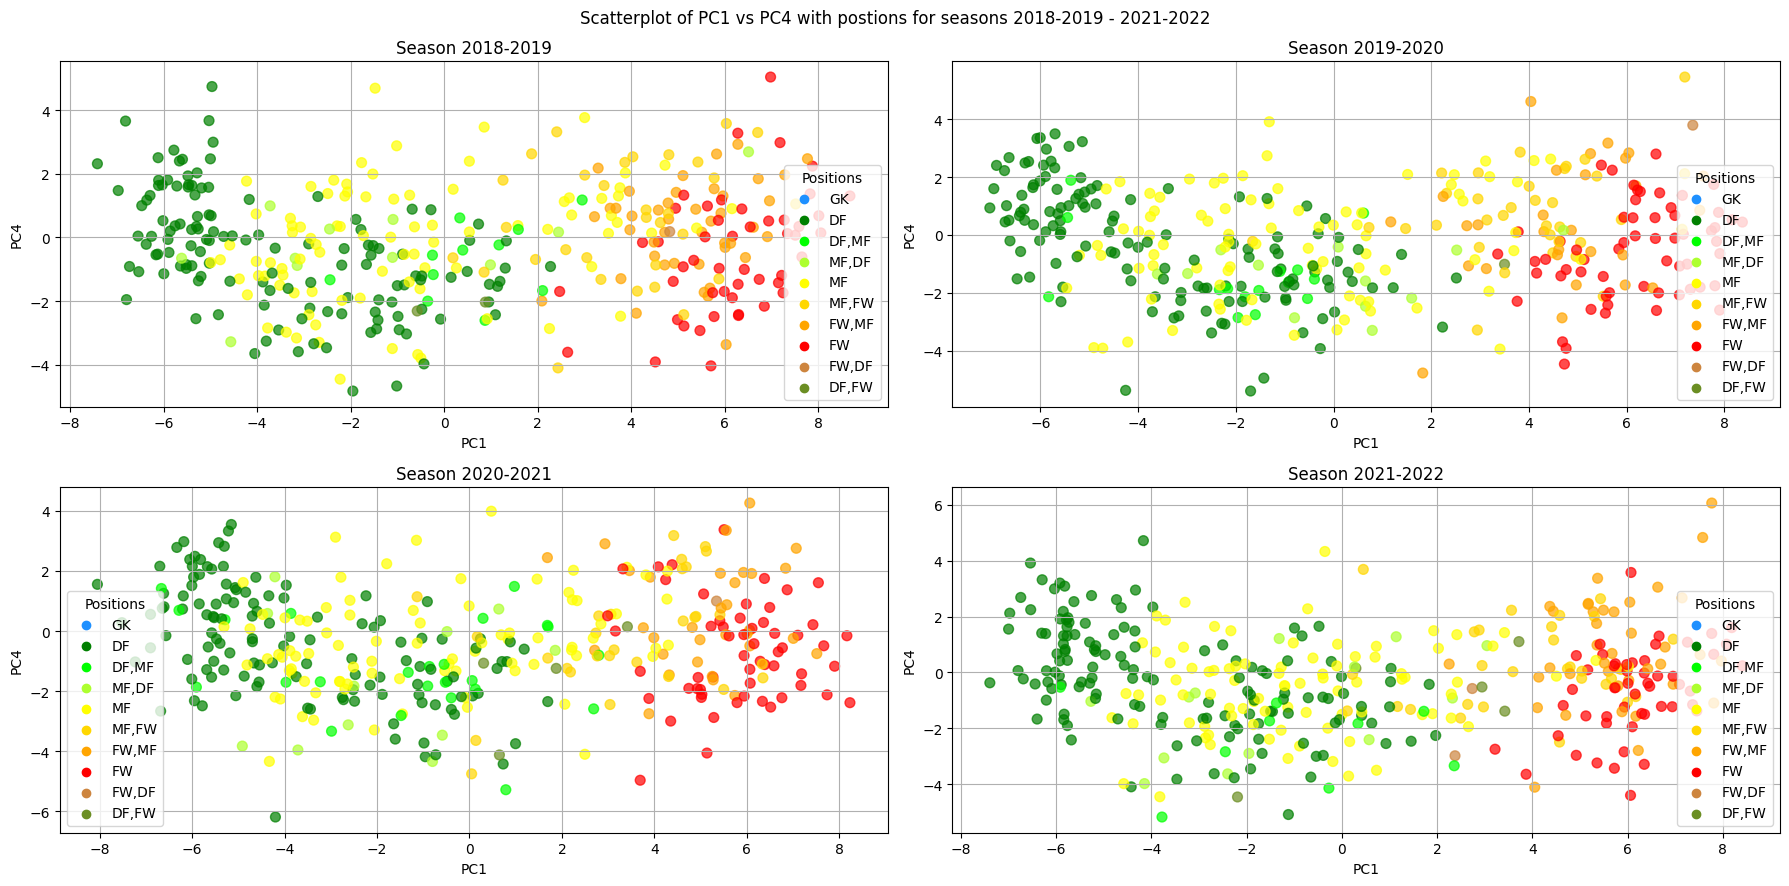

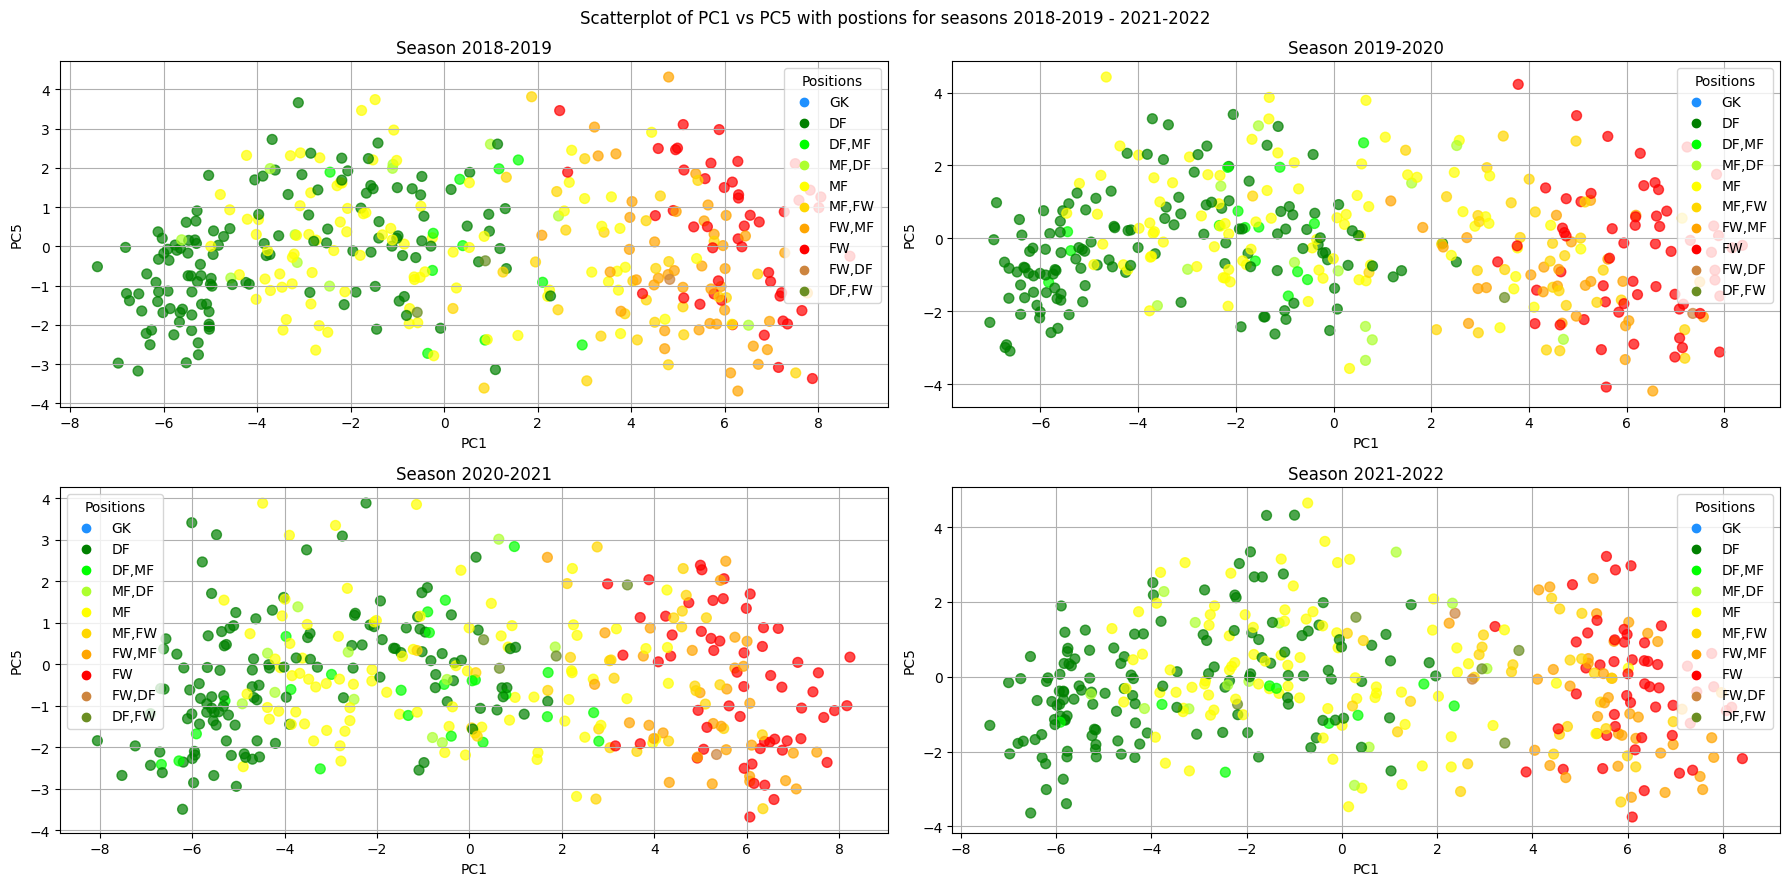

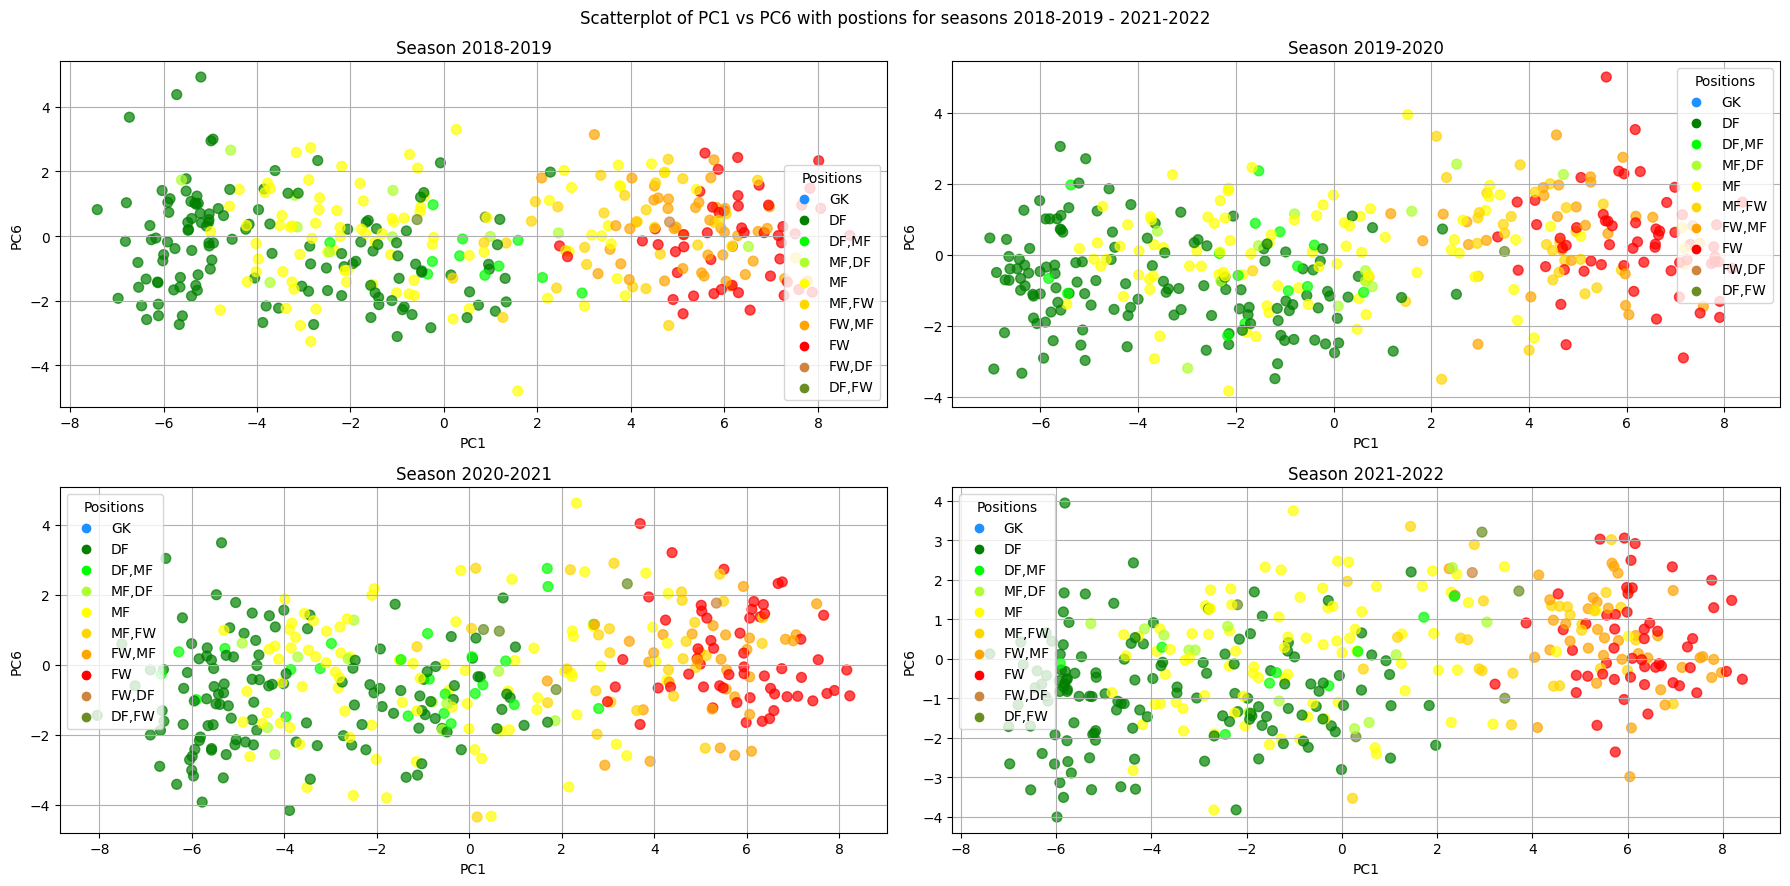

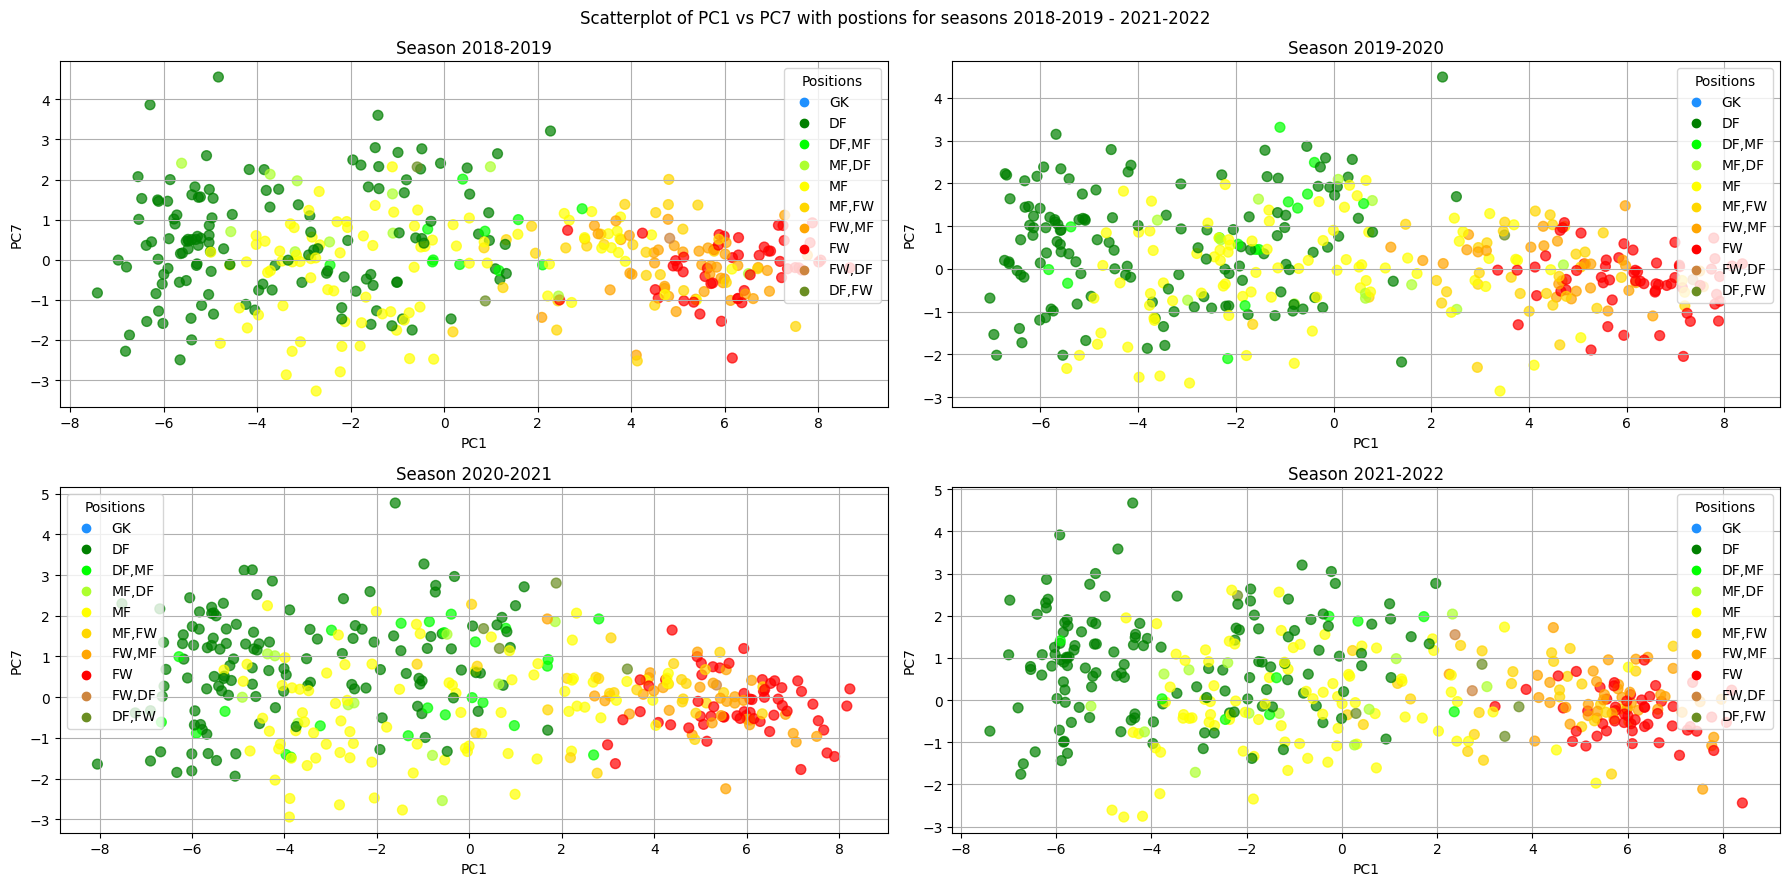

In [31]:
for pc_b in range(2, 8):
    draw_map(1, pc_b)

## Investigating anecdotal cross-seasonal variation of players

We will only focus on players that played all 5 seasons for the same club

In [32]:
from scipy.spatial.distance import cdist

def find_closest(search_space: pd.DataFrame, point: pd.Series, n_comparison_pcs: int = 52, n_closest: int = 10, return_distances=False):
    # Determining how many pcs to use for comparison
    pc_cols = [f"PC{i}" for i in range(1, n_comparison_pcs + 1)]

    # Calculate the Euclidean distances between the target point and all other points
    distances = cdist(search_space[pc_cols].values, point[pc_cols].astype(float).values.reshape(1, -1), metric='euclidean')

    # Find the indices of the 10 closest points
    closest_indices = distances.argsort(axis=0)[:n_closest, 0]

    if return_distances:
        return pd.Series(distances[closest_indices].flatten(), index=search_space.iloc[closest_indices].index)

    # Get closest points from the original DataFrame
    closest_points = search_space.iloc[closest_indices]
    return closest_points[pc_cols + ['season']]

In [33]:
data_combined = pd.concat(data.values(), axis=0)
season_counts = data_combined.groupby(level='player')[['season', 'team']].nunique()
loyal_players = season_counts[(season_counts['season'] == 5) & (season_counts['team'] == 1)]
loyal_players

season  team
player                              
Aaron Cresswell              5     1
Alexandre Lacazette          5     1
Andreas Christensen          5     1
Andrew Robertson             5     1
Angelo Ogbonna               5     1
...                        ...   ...
Trent Alexander-Arnold       5     1
Victor Lindelöf              5     1
Wilfred Ndidi                5     1
Wilfried Zaha                5     1
İlkay Gündoğan               5     1

[101 rows x 2 columns]

Let's pick TAA and see which players played most similar style each season to him in season 2017-2018

Turns out, for the next 3 seasons he played almost a copy of himself in terms of playing style.

In [34]:
point = X_train_decomposed.loc['Trent Alexander-Arnold']
for season in seasons[1:]:
    search_space = X_test_decomposed[X_test_decomposed['season'] == season]
    display(find_closest(search_space, point, n_comparison_pcs=15, n_closest=5))

PC1       PC2       PC3       PC4       PC5   
player                                                                     
Trent Alexander-Arnold -1.619737 -3.553390  2.077289 -0.241026  2.234801  \
Ashley Young           -1.779158 -2.669484  3.040408  0.247458  0.973529   
José Holebas           -0.501761 -2.353762  3.758457 -1.330750  1.310449   
Kieran Trippier        -1.414876 -3.197671  1.364673 -2.595048  2.631234   
Lucas Digne            -0.476145 -3.294291  3.123232 -1.210028  1.780086   

                             PC6       PC7       PC8       PC9      PC10   
player                                                                     
Trent Alexander-Arnold  0.483883  1.816204 -1.188316 -0.144114  0.300532  \
Ashley Young           -0.182490  2.360318 -0.284621 -0.412003  0.501592   
José Holebas            1.203560  2.262423 -0.443151  0.118625 -0.665315   
Kieran Trippier        -0.262504  3.601851  0.128129  0.002857  0.249737   
Lucas Digne            -1.076770  2.765855  0.540140  0.358024  0.192318   

                            PC11      PC12      PC13      PC14      PC15   
player                                                                     
Trent Alexander-Arnold -0.818738  0.184874  1.257974 -0.203317 -0.681040  \
Ashley Young           -0.052919  1.243597  0.701728 -0.484635 -0.233377   
José Holebas            0.321371  1.018315  1.226386 -0.745161 -0.092098   
Kieran Trippier        -1.025448 -0.339010  0.256538  0.909979 -0.887122   
Lucas Digne             0.399447  0.777246 -0.089491  0.464762 -0.186933   

                           season  
player                             
Trent Alexander-Arnold  2018-2019  
Ashley Young            2018-2019  
José Holebas            2018-2019  
Kieran Trippier         2018-2019  
Lucas Digne             2018-2019

PC1       PC2       PC3       PC4       PC5   
player                                                                     
Matt Targett           -1.097486 -2.371842  1.251669 -1.259851  1.951243  \
Trent Alexander-Arnold -1.359957 -3.428924  2.145938  1.258489  2.553928   
Kieran Tierney         -0.391686 -0.998255  2.785871 -1.528443  0.406212   
Andrew Robertson       -0.314467 -2.530702  1.516749  0.040585 -0.175403   
Enda Stevens            0.507424 -3.471690  1.448072 -0.504596  0.076410   

                             PC6       PC7       PC8       PC9      PC10   
player                                                                     
Matt Targett            0.644255  3.312740  0.013526 -0.389185  0.847135  \
Trent Alexander-Arnold  0.302222  2.159393 -0.487319  0.691180  1.057498   
Kieran Tierney          0.270684  2.491518 -0.639593  0.530834 -1.709662   
Andrew Robertson       -1.497342  1.932547  0.420947  0.256749  1.181174   
Enda Stevens           -0.610869  1.183952  1.340514  0.273054 -0.347786   

                            PC11      PC12      PC13      PC14      PC15   
player                                                                     
Matt Targett           -0.291107  0.000141  0.503303 -0.763911  0.091940  \
Trent Alexander-Arnold -1.718882  0.602573  0.754549 -1.074503 -1.216187   
Kieran Tierney          0.179952  0.628523  0.279193 -0.537962 -0.884570   
Andrew Robertson       -0.849661  0.222005  0.636444 -0.041116  0.088805   
Enda Stevens           -0.322067 -0.756204  0.779782 -0.544152 -0.822815   

                           season  
player                             
Matt Targett            2019-2020  
Trent Alexander-Arnold  2019-2020  
Kieran Tierney          2019-2020  
Andrew Robertson        2019-2020  
Enda Stevens            2019-2020

PC1       PC2       PC3       PC4       PC5   
player                                                                     
Trent Alexander-Arnold -0.910450 -3.788039  1.844127  0.979576  1.849472  \
Joël Veltman           -2.468240 -2.367535  1.381552 -1.449533  1.230367   
Matthew Lowton         -1.925221 -2.941636  1.948293  0.344399  1.528420   
Andrew Robertson       -0.589661 -1.808932  2.144234 -0.272024  0.257692   
Ezgjan Alioski         -0.546980 -2.298308  1.808357 -1.110789 -0.485099   

                             PC6       PC7       PC8       PC9      PC10   
player                                                                     
Trent Alexander-Arnold -0.195617  1.197686 -0.589189  0.411777  0.454360  \
Joël Veltman            0.128938  1.758087  0.334882  0.120508  0.284764   
Matthew Lowton          0.453511  0.677390  1.181574 -0.578677 -0.705492   
Andrew Robertson       -1.816437  1.559680  0.617070  0.304495  0.988680   
Ezgjan Alioski         -1.385771  1.586005 -0.106209 -0.609869  0.241484   

                            PC11      PC12      PC13      PC14      PC15   
player                                                                     
Trent Alexander-Arnold -1.023669  0.041449  0.700333 -0.441445 -0.942126  \
Joël Veltman            0.912899 -1.545622  0.014106 -0.324521  0.026948   
Matthew Lowton         -0.446636  1.059274  0.749104 -1.051672 -0.237950   
Andrew Robertson       -1.244292  0.069658  0.168993 -0.514959 -0.051654   
Ezgjan Alioski          0.819311 -0.289279  0.494632 -0.882240 -0.228534   

                           season  
player                             
Trent Alexander-Arnold  2020-2021  
Joël Veltman            2020-2021  
Matthew Lowton          2020-2021  
Andrew Robertson        2020-2021  
Ezgjan Alioski          2020-2021

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                       
Matty Cash     -0.283544 -2.078500  3.033560 -0.934318  0.170184  1.472128  \
Matthew Lowton -2.152050 -2.812978  1.421904 -0.189437  3.024856  0.495032   
Stuart Dallas  -1.372794 -3.015511  1.616659 -1.093673 -0.310063 -0.350283   
Cédric Soares  -2.245363 -3.373469  0.575682 -1.896121  2.182588 -0.877405   
Ben Johnson    -1.837803 -2.710762  1.761740 -0.994979  2.669040  1.690805   

                     PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                       
Matty Cash      1.753328  0.170075  0.830857 -0.311320 -0.859343  0.319370  \
Matthew Lowton  1.663848  0.157365 -0.423750  0.417498  0.194438 -0.025686   
Stuart Dallas   0.529881  0.241866 -1.253390 -0.272490 -0.832422  0.136692   
Cédric Soares   1.422070 -0.538365  0.388974 -0.684010 -0.092235 -0.675814   
Ben Johnson     2.014699  0.230187  0.590055 -1.585381  0.686290  0.867028   

                    PC13      PC14      PC15     season  
player                                                   
Matty Cash      0.323143 -0.621692  0.087384  2021-2022  
Matthew Lowton  1.409438  0.530226 -0.202690  2021-2022  
Stuart Dallas   0.328933 -0.609230  0.136464  2021-2022  
Cédric Soares   0.349825  0.426524 -0.875038  2021-2022  
Ben Johnson     0.891506 -0.260335 -0.525857  2021-2022

team pos       PC1       PC2       PC3       PC4   
player                                                                          
Trent Alexander-Arnold  Liverpool  DF -1.334357 -2.672612  1.913648 -0.516225  \
Trent Alexander-Arnold  Liverpool  DF -1.619737 -3.553390  2.077289 -0.241026   
Trent Alexander-Arnold  Liverpool  DF -1.359957 -3.428924  2.145938  1.258489   
Trent Alexander-Arnold  Liverpool  DF -0.910450 -3.788039  1.844127  0.979576   
Trent Alexander-Arnold  Liverpool  DF -0.993490 -2.465186  0.931355  1.589047   

                             PC5       PC6       PC7       PC8  ...      PC43   
player                                                          ...             
Trent Alexander-Arnold  1.167331  0.784437  2.158237 -0.620302  ...  0.125201  \
Trent Alexander-Arnold  2.234801  0.483883  1.816204 -1.188316  ...  0.038741   
Trent Alexander-Arnold  2.553928  0.302222  2.159393 -0.487319  ...  0.324519   
Trent Alexander-Arnold  1.849472 -0.195617  1.197686 -0.589189  ...  0.140751   
Trent Alexander-Arnold  4.318276  0.047353  1.649197 -0.676922  ...  0.241823   

                            PC44      PC45      PC46      PC47      PC48   
player                                                                     
Trent Alexander-Arnold  0.299734  0.010385 -0.150053  0.029305  0.179483  \
Trent Alexander-Arnold -0.029253  0.128504  0.040880 -0.186330 -0.112993   
Trent Alexander-Arnold -0.022744  0.193283 -0.113203 -0.068279  0.195321   
Trent Alexander-Arnold  0.103254  0.157546 -0.020596 -0.115183  0.171114   
Trent Alexander-Arnold  0.067402  0.171542 -0.126230 -0.087923  0.198753   

                            PC49      PC50      PC51      PC52  
player                                                          
Trent Alexander-Arnold  0.099290 -0.097607 -0.032445  0.000063  
Trent Alexander-Arnold -0.002999 -0.031860 -0.083689  0.011514  
Trent Alexander-Arnold  0.009031 -0.138487 -0.170882  0.132271  
Trent Alexander-Arnold  0.079262 -0.105287 -0.150652  0.024649  
Trent Alexander-Arnold  0.285961 -0.091324 -0.011260  0.078422  

[5 rows x 54 columns]

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('aerial_duels_won%', 'touches_mid3_per_game_vs_team', 'tackles_def3_per_games_vs_team', 'avg_pass_prg_distance', 'interceptions_per_games_vs_team', 'avg_pass_distance', 'clearences_per_games_vs_team', 'medium_pass_cmp_pct', 'touches_defpen_per_game_vs_team', 'touches_def3_per_game_vs_team')

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('carries3rd_per_carries', 'receives_per_game_vs_team', 'touches_per_game_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', '

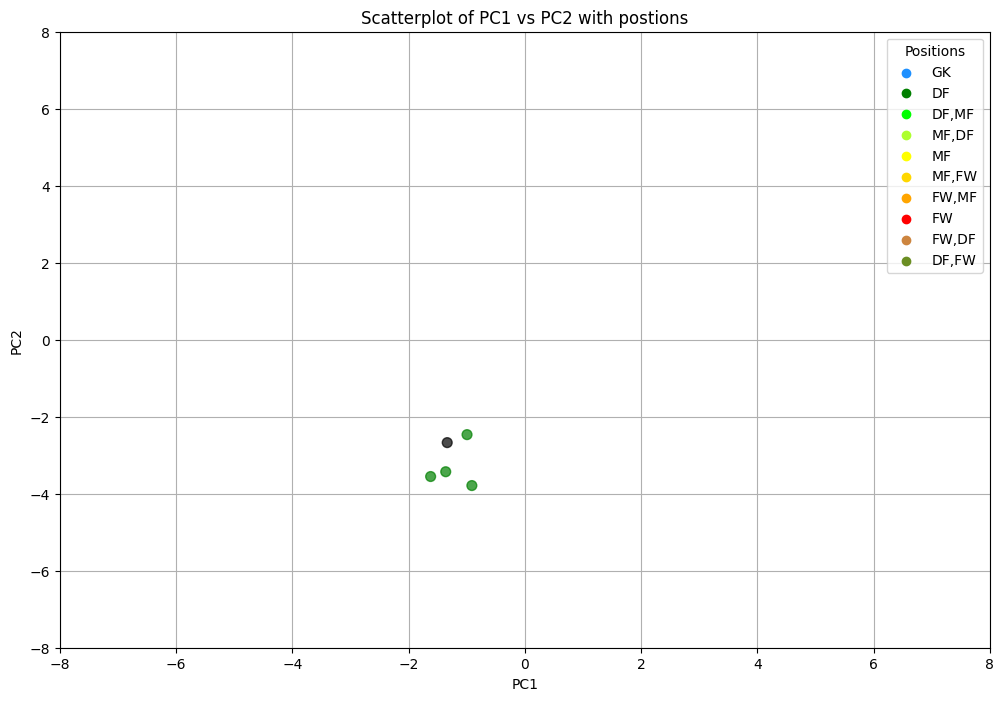

In [35]:
player = 'Trent Alexander-Arnold'
player_scatter_df = pd.merge(data['2017-2018'][['team', 'pos']], pd.concat((X_train_decomposed.loc[[player]], X_test_decomposed.loc[player].iloc[:, :-1]), axis=0), left_index=True, right_index=True)
display(player_scatter_df)
analyse_pcs(1, 2, _pc_scatter_df=player_scatter_df, lim=8, first_black=True)

One of a kind Harry Kane - playing the exact same football across seasons

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                         
Harry Kane        6.283054  3.240912 -0.023140  3.274233  2.163957  2.431868  \
Romelu Lukaku     7.829435  4.046562  0.657403  1.369681  1.431288  1.477955   
Jamie Vardy       8.015979  4.032093  1.963369  0.682912  0.985164  2.330441   
Daniel Sturridge  5.383208  2.712178 -2.272428  0.887040  1.849689  0.883386   
Callum Wilson     8.058822  4.369163  0.741324  0.142659  1.258031  0.857475   

                       PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                         
Harry Kane       -0.972081 -0.053942 -2.171808 -0.322235 -0.682525  1.407911  \
Romelu Lukaku     0.424647  0.568415 -0.860685  0.542508  0.116613  0.595894   
Jamie Vardy      -0.057444 -0.828480 -1.409867  0.638798  0.640507  0.302316   
Daniel Sturridge -0.984245 -1.079014 -2.323681 -0.581227  0.029308  1.156849   
Callum Wilson    -0.010274  0.667969 -1.314225  0.325622  0.100375 -0.210992   

                      PC13      PC14      PC15     season  
player                                                     
Harry Kane        1.007634 -1.559888  1.001423  2018-2019  
Romelu Lukaku     0.896381 -0.504230  0.948933  2018-2019  
Jamie Vardy       0.588970  0.127714  0.448864  2018-2019  
Daniel Sturridge  0.253609 -0.036842 -0.480410  2018-2019  
Callum Wilson    -0.235087 -0.246593 -0.048559  2018-2019

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                         
Harry Kane        6.278954  3.165295 -0.570980  1.499275  2.333030  2.339879  \
Raúl Jiménez      5.704659  2.172648 -0.210585  2.237322  0.264378  0.813224   
Callum Wilson     7.840590  3.934239 -0.186689 -0.222147  1.756757  0.841945   
Che Adams         6.676177  4.346543 -0.716802  1.452104  0.325957  0.665818   
Leandro Trossard  5.260129 -0.227075  0.459692  2.809478  1.041766  2.190041   

                       PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                         
Harry Kane       -0.285935  0.641600 -1.868987 -0.169185  0.671928  1.011208  \
Raúl Jiménez     -0.725178  0.606190  0.115855  0.513928 -0.267518  1.137577   
Callum Wilson    -0.594044  0.696171 -0.892506  0.035198  0.008671 -0.008654   
Che Adams        -1.558714 -0.030910  0.794838  0.399551 -1.243012  1.308754   
Leandro Trossard -0.445224 -0.617073 -0.301143 -0.310131 -0.423030 -0.699300   

                      PC13      PC14      PC15     season  
player                                                     
Harry Kane        0.431941 -0.374213  0.462103  2019-2020  
Raúl Jiménez      0.741300 -0.510522  0.757007  2019-2020  
Callum Wilson     0.369938 -0.473778 -0.157667  2019-2020  
Che Adams         1.021939 -0.397203 -0.269692  2019-2020  
Leandro Trossard -0.048856 -0.786214 -0.554605  2019-2020

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                       
Harry Kane      5.506956  1.461400 -0.060481  3.376835  2.063923  2.729680  \
Che Adams       6.360366  4.080570 -1.450496  0.284209  0.881864  1.720375   
Daniel Podence  5.124875  1.021368 -0.000197  2.661473  1.120685  0.265436   
Rodrigo         4.688803  1.426419 -1.395003  2.136585  1.663775  0.670121   
Neal Maupay     6.004602  2.952158  0.626651 -0.090224  0.555134  0.438441   

                     PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                       
Harry Kane     -0.489239  0.839792 -1.461769  0.626425 -0.008288  1.080397  \
Che Adams       0.147957 -0.174841 -1.234140  0.117103  0.056049  0.118918   
Daniel Podence -0.142986 -0.462260 -0.504791 -0.662967  0.563542  0.068579   
Rodrigo         0.337097  0.578411 -0.086498  0.125334 -0.060499 -0.100221   
Neal Maupay    -0.540654 -1.451590 -1.604181 -0.380195 -0.666439 -0.615313   

                    PC13      PC14      PC15     season  
player                                                   
Harry Kane      0.404301 -0.575487  0.745123  2020-2021  
Che Adams       0.337642  0.251862  0.432995  2020-2021  
Daniel Podence  0.576683 -0.606381  0.205317  2020-2021  
Rodrigo         1.087024  0.106390 -0.337228  2020-2021  
Neal Maupay     0.242442 -0.282369  0.466392  2020-2021

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                         
Harry Kane        6.072085  2.138206  0.669894  3.577711  2.965570  2.489897  \
Che Adams         5.990246  4.485107 -1.500516  0.051381  1.128897  1.180137   
Michail Antonio   7.767020  1.467921  1.605636  1.394219  0.621186  1.988232   
Leandro Trossard  5.173327  0.400835 -0.749651  2.437774  0.360328  1.266034   
Danny Ings        5.933770  1.984613 -0.920172 -1.240253  0.924944  3.053277   

                       PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                         
Harry Kane       -0.561022  1.060299 -1.758742  0.266628 -0.028649  0.878633  \
Che Adams        -0.215566  0.238119  0.176150  0.429734 -0.526413  1.005729   
Michail Antonio  -0.403740 -0.466485  0.745854  0.008238  0.306938  0.399402   
Leandro Trossard -0.368201 -0.277285 -0.371486 -0.551026 -0.371683  0.593820   
Danny Ings       -0.329782 -0.269153 -1.153537  1.316941 -0.956569  1.259434   

                      PC13      PC14      PC15     season  
player                                                     
Harry Kane        0.685618 -0.170373  0.598449  2021-2022  
Che Adams         0.661135 -0.165163  0.036117  2021-2022  
Michail Antonio   1.507995  0.624762  0.571650  2021-2022  
Leandro Trossard  0.852549  0.659288  0.417936  2021-2022  
Danny Ings        0.834503  0.015642  0.272545  2021-2022

team pos       PC1       PC2       PC3       PC4       PC5   
player                                                                        
Harry Kane  Tottenham  FW  6.309811  3.391472 -0.115691  2.760665  2.930569  \
Harry Kane  Tottenham  FW  6.283054  3.240912 -0.023140  3.274233  2.163957   
Harry Kane  Tottenham  FW  6.278954  3.165295 -0.570980  1.499275  2.333030   
Harry Kane  Tottenham  FW  5.506956  1.461400 -0.060481  3.376835  2.063923   
Harry Kane  Tottenham  FW  6.072085  2.138206  0.669894  3.577711  2.965570   

                 PC6       PC7       PC8  ...      PC43      PC44      PC45   
player                                    ...                                 
Harry Kane  3.250581 -0.802208 -0.984873  ... -0.020486 -0.265730  0.198103  \
Harry Kane  2.431868 -0.972081 -0.053942  ...  0.058726 -0.017037  0.078129   
Harry Kane  2.339879 -0.285935  0.641600  ... -0.078074  0.211236  0.025563   
Harry Kane  2.729680 -0.489239  0.839792  ...  0.247730  0.287869  0.026686   
Harry Kane  2.489897 -0.561022  1.060299  ...  0.042873  0.129502 -0.072391   

                PC46      PC47      PC48      PC49      PC50      PC51   
player                                                                   
Harry Kane -0.019337 -0.048965  0.063703 -0.231887  0.066374 -0.029170  \
Harry Kane -0.132898 -0.027835  0.373510 -0.125689 -0.041466 -0.099649   
Harry Kane  0.002375 -0.004389  0.282054 -0.070758  0.021068 -0.093168   
Harry Kane  0.041504 -0.048017 -0.249105 -0.056824 -0.045634 -0.069907   
Harry Kane -0.062187 -0.134339 -0.112684 -0.048753 -0.034687 -0.057397   

                PC52  
player                
Harry Kane  0.095510  
Harry Kane  0.087674  
Harry Kane -0.081189  
Harry Kane -0.041101  
Harry Kane  0.051800  

[5 rows x 54 columns]

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('aerial_duels_won%', 'touches_mid3_per_game_vs_team', 'tackles_def3_per_games_vs_team', 'avg_pass_prg_distance', 'interceptions_per_games_vs_team', 'avg_pass_distance', 'clearences_per_games_vs_team', 'medium_pass_cmp_pct', 'touches_defpen_per_game_vs_team', 'touches_def3_per_game_vs_team')

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('carries3rd_per_carries', 'receives_per_game_vs_team', 'touches_per_game_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', '

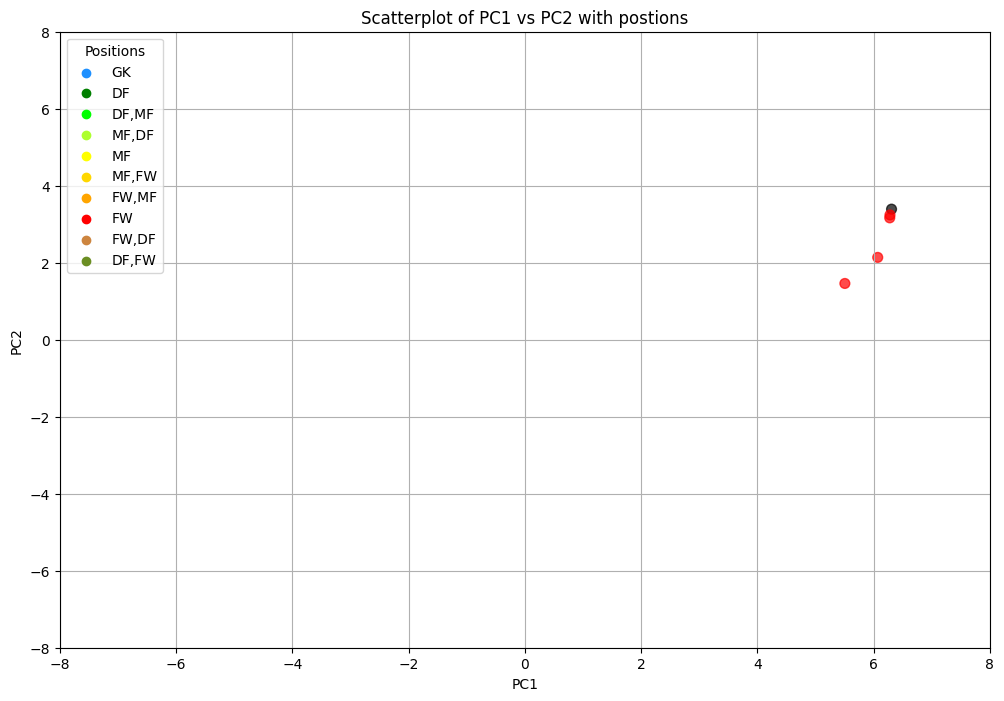

In [36]:
player = 'Harry Kane'

point = X_train_decomposed.loc[player]
for season in seasons[1:]:
    search_space = X_test_decomposed[X_test_decomposed['season'] == season]
    display(find_closest(search_space, point, n_comparison_pcs=15, n_closest=5))

player_scatter_df = pd.merge(data['2017-2018'][['team', 'pos']], pd.concat((X_train_decomposed.loc[[player]], X_test_decomposed.loc[player].iloc[:, :-1]), axis=0), left_index=True, right_index=True)
display(player_scatter_df)
analyse_pcs(1, 2, _pc_scatter_df=player_scatter_df, lim=8, first_black=True)

Let's try Gundogan

PC1       PC2       PC3       PC4       PC5   
player                                                                  
Naby Keïta           0.854704 -2.539317 -2.379726 -1.089086 -3.607884  \
İlkay Gündoğan       0.193329 -0.180856 -1.601489  1.513972 -0.145841   
Mateo Kovačić       -0.746828 -2.368727 -2.509031 -1.395511 -1.969884   
N'Golo Kanté         0.922689 -0.866553 -1.541128 -2.552143 -2.371413   
Georginio Wijnaldum -0.641032  1.633021 -2.276712 -0.522658 -0.778640   

                          PC6       PC7       PC8       PC9      PC10   
player                                                                  
Naby Keïta          -0.207177  0.297318  0.654668 -1.054618  1.021949  \
İlkay Gündoğan      -2.563783  0.874770  0.369511 -1.339460  0.052771   
Mateo Kovačić       -1.788640 -1.323461  0.564589 -0.151371  0.247556   
N'Golo Kanté         0.571017 -0.082165 -0.016004 -0.381004  0.522523   
Georginio Wijnaldum -1.367850 -0.187078 -0.639188 -1.236667  0.039150   

                         PC11      PC12      PC13      PC14      PC15   
player                                                                  
Naby Keïta          -0.829881  0.608228 -1.330922  0.554640 -0.382701  \
İlkay Gündoğan      -0.274080  0.267768  0.673816  0.067796 -0.436613   
Mateo Kovačić       -1.051514 -0.056414  1.259865 -0.986392  0.123127   
N'Golo Kanté         0.004347  0.820718 -1.228628  0.495990  0.307303   
Georginio Wijnaldum  0.901772 -0.265228  0.440091 -0.456862  0.582743   

                        season  
player                          
Naby Keïta           2018-2019  
İlkay Gündoğan       2018-2019  
Mateo Kovačić        2018-2019  
N'Golo Kanté         2018-2019  
Georginio Wijnaldum  2018-2019

PC1       PC2       PC3       PC4       PC5   
player                                                                 
Abdoulaye Doucouré  0.666538 -1.050536 -2.392916 -0.030075 -1.165009  \
İlkay Gündoğan     -1.589608 -0.387661 -2.746497 -0.311849  0.450303   
Tanguy Ndombele    -0.298219 -2.232321 -3.490254  0.275261 -0.871969   
David Silva         3.691119 -0.200011 -2.376515 -0.544346 -1.387022   
Todd Cantwell       3.128302 -0.989246 -2.096877 -1.164785 -1.353576   

                         PC6       PC7       PC8       PC9      PC10   
player                                                                 
Abdoulaye Doucouré -1.685829 -0.272007  1.445385  1.057844  1.317041  \
İlkay Gündoğan     -2.299968 -0.081837 -0.098303 -0.448748  0.142226   
Tanguy Ndombele    -0.340072  1.575545  0.864589 -0.405490 -1.344367   
David Silva        -0.981211  1.032607  0.561428 -1.568702  0.536015   
Todd Cantwell       0.403123  0.429261  0.234445  0.278143  0.082128   

                        PC11      PC12      PC13      PC14      PC15   
player                                                                 
Abdoulaye Doucouré  0.229940 -0.130972 -1.133494  0.061530  0.015543  \
İlkay Gündoğan     -0.155300 -0.277023 -0.111837  0.505048 -0.023572   
Tanguy Ndombele    -0.555745  1.749807 -0.487829  0.069559 -0.325196   
David Silva        -1.369953 -0.765936 -0.012399  0.855632  0.210095   
Todd Cantwell      -1.069661  0.104939  0.404559 -1.049909  0.211189   

                       season  
player                         
Abdoulaye Doucouré  2019-2020  
İlkay Gündoğan      2019-2020  
Tanguy Ndombele     2019-2020  
David Silva         2019-2020  
Todd Cantwell       2019-2020

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                        
Tanguy Ndombele  1.481577 -0.972363 -2.630476 -0.227869 -2.127264 -0.940307  \
Curtis Jones     0.120112 -0.978557 -2.259580 -0.675419 -1.657442 -2.421854   
Adam Lallana     1.695127 -0.291236 -2.117614 -0.902968 -0.630526 -1.082796   
İlkay Gündoğan   0.867045  0.110362 -2.191959 -0.066478 -1.347240 -1.856865   
Steven Alzate   -0.367539  0.718642 -1.389899 -0.928349 -1.026190 -1.210191   

                      PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                        
Tanguy Ndombele  0.822186  0.477742 -1.068625 -0.686097  0.093746  0.198513  \
Curtis Jones     0.642361  0.380370 -0.091320  0.099634 -0.445099 -0.106477   
Adam Lallana    -0.311823  0.401330 -0.521542 -0.106489 -0.493655 -0.669658   
İlkay Gündoğan   1.141449  0.116346 -0.377119 -0.122399  0.174797 -0.493018   
Steven Alzate    0.292851 -0.916426 -0.942310 -0.285459  1.253180 -0.817112   

                     PC13      PC14      PC15     season  
player                                                    
Tanguy Ndombele  0.184449  0.383084  0.210138  2020-2021  
Curtis Jones    -0.635961 -0.751667  0.704585  2020-2021  
Adam Lallana    -0.367280  0.084851 -0.441199  2020-2021  
İlkay Gündoğan   0.391013 -0.822221  0.357365  2020-2021  
Steven Alzate   -0.279897 -0.980669  0.013201  2020-2021

PC1       PC2       PC3       PC4       PC5   
player                                                                 
Abdoulaye Doucouré  0.005599 -1.149833 -2.658522 -1.498661 -1.299738  \
Tanguy Ndombele     2.298040 -0.875275 -2.743043 -0.775272 -1.604292   
Mateusz Klich       2.426866 -0.875201 -1.621566 -0.348123  0.119610   
Shandon Baptiste    1.329271  0.523435 -1.416387 -0.172882 -1.274876   
Manuel Lanzini      0.225010 -1.836866 -3.396909 -0.069398 -0.781654   

                         PC6       PC7       PC8       PC9      PC10   
player                                                                 
Abdoulaye Doucouré  0.154106 -0.085509  0.485344 -0.464874  0.544744  \
Tanguy Ndombele    -1.606924  0.592314  0.467102 -0.568590  0.222976   
Mateusz Klich      -0.282438 -0.035861 -0.056203 -0.707499  0.146771   
Shandon Baptiste   -0.809183 -0.401696 -0.249942 -0.694734 -1.670761   
Manuel Lanzini     -3.530058  1.175095 -0.745250 -0.250441 -0.994174   

                        PC11      PC12      PC13      PC14      PC15   
player                                                                 
Abdoulaye Doucouré  0.797821 -0.004189 -0.046785 -0.428245 -0.050338  \
Tanguy Ndombele     1.337435  0.675345  1.185582  0.487871  0.056298   
Mateusz Klich      -0.502241  0.262223  0.362498 -0.425008  0.245979   
Shandon Baptiste    0.301729 -0.294642 -1.552063 -0.627942 -0.046599   
Manuel Lanzini     -0.247148 -1.357385  0.066406  0.188364  0.214475   

                       season  
player                         
Abdoulaye Doucouré  2021-2022  
Tanguy Ndombele     2021-2022  
Mateusz Klich       2021-2022  
Shandon Baptiste    2021-2022  
Manuel Lanzini      2021-2022

team pos       PC1       PC2       PC3       PC4   
player                                                                        
İlkay Gündoğan  Manchester City  MF  0.606194 -1.206036 -2.688803 -0.760098  \
İlkay Gündoğan  Manchester City  MF  0.193329 -0.180856 -1.601489  1.513972   
İlkay Gündoğan  Manchester City  MF -1.589608 -0.387661 -2.746497 -0.311849   
İlkay Gündoğan  Manchester City  MF  0.867045  0.110362 -2.191959 -0.066478   
İlkay Gündoğan  Manchester City  MF  1.252638  0.979202 -1.049806 -0.044001   

                     PC5       PC6       PC7       PC8  ...      PC43   
player                                                  ...             
İlkay Gündoğan -1.704171 -1.649943  0.399504  0.029227  ... -0.119550  \
İlkay Gündoğan -0.145841 -2.563783  0.874770  0.369511  ...  0.272413   
İlkay Gündoğan  0.450303 -2.299968 -0.081837 -0.098303  ...  0.093948   
İlkay Gündoğan -1.347240 -1.856865  1.141449  0.116346  ...  0.108651   
İlkay Gündoğan -0.411505 -0.120235  0.500678 -0.070703  ... -0.012482   

                    PC44      PC45      PC46      PC47      PC48      PC49   
player                                                                       
İlkay Gündoğan -0.181920 -0.126930  0.029625  0.070310 -0.047653 -0.066234  \
İlkay Gündoğan -0.371694  0.026114  0.040834 -0.008738  0.009582 -0.009121   
İlkay Gündoğan -0.413539 -0.018685  0.240808  0.276357  0.076410  0.133301   
İlkay Gündoğan -0.130359  0.265803 -0.157781  0.189772 -0.036012 -0.021201   
İlkay Gündoğan -0.248832  0.001058 -0.097356  0.225375 -0.119029 -0.041474   

                    PC50      PC51      PC52  
player                                        
İlkay Gündoğan -0.046730  0.055428  0.016103  
İlkay Gündoğan -0.034902  0.017848 -0.034360  
İlkay Gündoğan -0.157776  0.063767  0.013945  
İlkay Gündoğan -0.148788  0.027176  0.005577  
İlkay Gündoğan -0.056314 -0.064426 -0.043434  

[5 rows x 54 columns]

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('aerial_duels_won%', 'touches_mid3_per_game_vs_team', 'tackles_def3_per_games_vs_team', 'avg_pass_prg_distance', 'interceptions_per_games_vs_team', 'avg_pass_distance', 'clearences_per_games_vs_team', 'medium_pass_cmp_pct', 'touches_defpen_per_game_vs_team', 'touches_def3_per_game_vs_team')

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('carries3rd_per_carries', 'receives_per_game_vs_team', 'touches_per_game_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', '

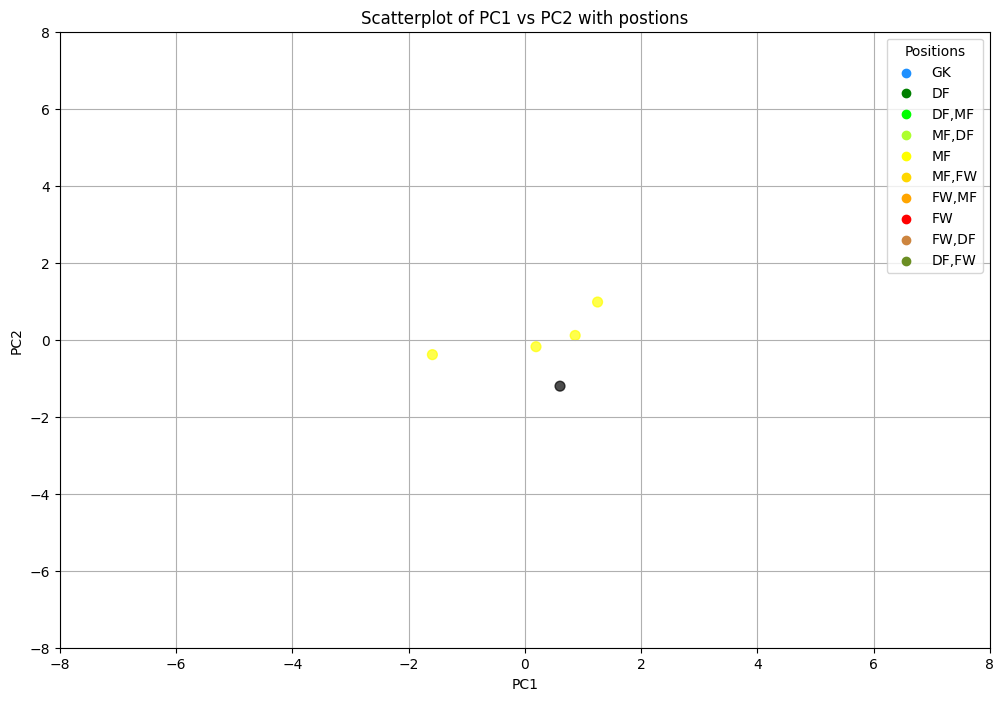

In [37]:
player = 'İlkay Gündoğan'

point = X_train_decomposed.loc[player]
for season in seasons[1:]:
    search_space = X_test_decomposed[X_test_decomposed['season'] == season]
    display(find_closest(search_space, point, n_comparison_pcs=15, n_closest=5))

player_scatter_df = pd.merge(data['2017-2018'][['team', 'pos']], pd.concat((X_train_decomposed.loc[[player]], X_test_decomposed.loc[player].iloc[:, :-1]), axis=0), left_index=True, right_index=True)
display(player_scatter_df)
analyse_pcs(1, 2, _pc_scatter_df=player_scatter_df, lim=8, first_black=True)

## Investigating cross-seasonal stability of player characteristic

The examples above are purely anecdotal, so let's think about a way in which we can generalize player variantion.

Let's consider top 15 PCs. If we pick the first season for a player, we want to know how does the euclidean distance to himself next season compare with other player next season. 

I.e. consider Gundogan in 2017-2018. One season later, he was the 2nd most similar player to himself, after Keita. The question is: if you take the average distance squared for the 5 most similar non-Gundgoan players, how does his squared distance compare to this? The answer to that question is non-obvious, since we're working with highly (15) dimensional space, so variations to less relevant principal components can add a lot of variance between seasons.

To do so, I will grab each non-GK player from 2017-2018, and investigate his squared distance to himself against other similar players next season.

In [38]:
two_season_players = list(set(X_train_decomposed.index).intersection(set(X_test_decomposed[X_test_decomposed['season'] == '2018-2019'].index)).difference(set(data['2017-2018'].query("pos == 'GK'").index)))
len(two_season_players)

243

For each player I collect:
- The distance between himself across two seasons
- The mean distance between himself and N most similar players the next season

In [39]:
same_player_dist = []
most_similar_5_dist = []
most_similar_15_dist = []
most_similar_25_dist = []

search_space = X_test_decomposed[X_test_decomposed['season'] == '2018-2019']

for i, player in enumerate(two_season_players):
    player_vector = X_train_decomposed[~X_train_decomposed.index.duplicated()].loc[player]
    distances = find_closest(search_space, point=player_vector, n_comparison_pcs = 15, n_closest=400, return_distances=True)
    other_player_distances = distances[distances.index != player].iloc[:15]
    same_player_dist.append(distances.loc[player])
    most_similar_5_dist.append(other_player_distances.iloc[:5].mean())
    most_similar_15_dist.append(other_player_distances.iloc[:15].mean())
    most_similar_25_dist.append(other_player_distances.iloc[:25].mean())
    print(f"{i+1}/{len(two_season_players)} players done", end='\r')

In [40]:
len(most_similar_5_dist)

243

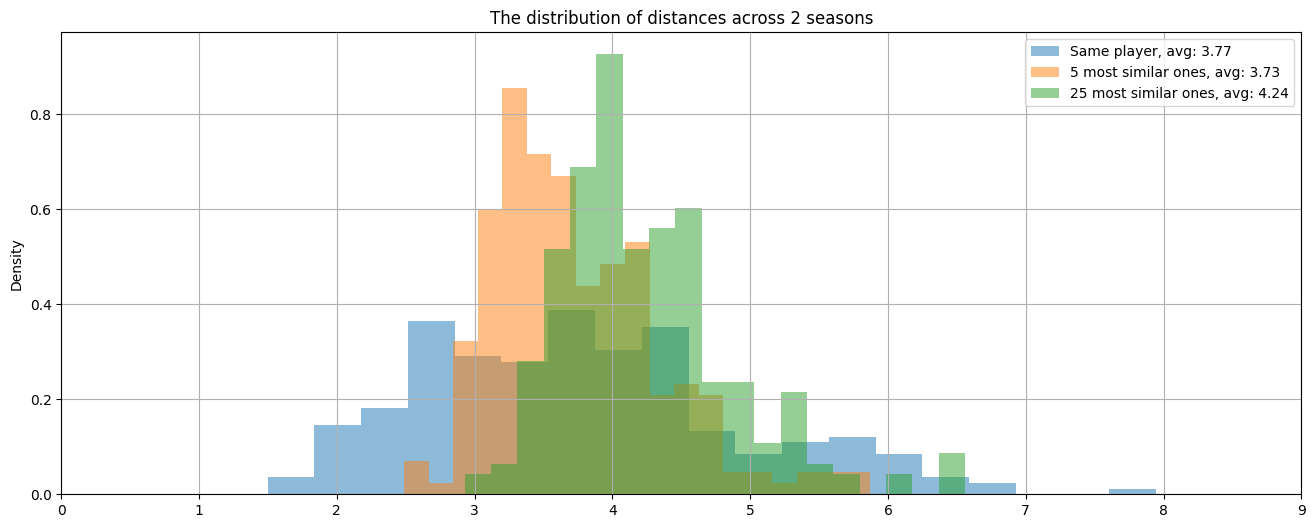

In [41]:
plt.figure(figsize=(16, 6))
plt.title("The distribution of distances across 2 seasons")
plt.hist(same_player_dist, bins=np.linspace(min(same_player_dist), max(same_player_dist), 20), alpha=0.5, label=f'Same player, avg: {np.round(np.mean(same_player_dist), 2)}', density=True)
plt.hist(most_similar_5_dist, bins=np.linspace(min(most_similar_5_dist), max(most_similar_5_dist), 20), alpha=0.5, label=f'5 most similar ones, avg: {np.round(np.mean(most_similar_5_dist), 2)}', density=True)
plt.hist(most_similar_25_dist, bins=np.linspace(min(most_similar_25_dist), max(most_similar_25_dist), 20), alpha=0.5, label=f'25 most similar ones, avg: {np.round(np.mean(most_similar_25_dist), 2)}', density=True)
plt.grid()
plt.xlim(0, 9)
plt.legend()
plt.ylabel('Density')
plt.show()

In [ ]:
from scipy.stats import wilcoxon

In [56]:
print("Two-sided Wilcoxon test self-distance vs 5 NN")
display(wilcoxon(x=same_player_dist, y=most_similar_5_dist, alternative='two-sided'))
print("One-sided Wilcoxon test self-distance vs 25 NN")
display(wilcoxon(x=same_player_dist, y=most_similar_25_dist, alternative='greater'))

Two-sided Wilcoxon test self-distance vs 5 NN


WilcoxonResult(statistic=14800.0, pvalue=0.9832706463031499)

One-sided Wilcoxon test self-distance vs 25 NN


WilcoxonResult(statistic=8109.0, pvalue=0.9999999995351347)

Looking at the outlier

Christian Kabasele


PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                        
Michael Keane   -5.475730  3.521393  0.072291  1.583301 -0.747504  0.180402  \
Craig Cathcart  -5.214079  4.592350 -0.682201 -0.443594 -0.458699  0.702451   
Ryan Bennett    -4.715950  3.256975  0.285683  0.032193  0.250214  0.633447   
Shane Duffy     -5.329969  5.557336 -0.101383  1.334649  0.163006  1.018262   
James Tarkowski -5.717088  2.190179 -0.475264  1.614623 -0.098745  4.376651   

                      PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                        
Michael Keane    0.271532  1.017400  0.277739 -1.031142  0.315638 -0.317328  \
Craig Cathcart   1.566681 -0.456540  0.336169 -1.133809  0.340350 -0.237024   
Ryan Bennett     0.273419  0.442468 -0.665463 -0.527395  0.018867  0.690976   
Shane Duffy      1.816731  0.877534  2.471120 -2.402824 -0.967105  0.937768   
James Tarkowski  1.116153  1.437033  0.430241  0.790298 -0.125857 -0.361582   

                     PC13      PC14      PC15     season  
player                                                    
Michael Keane    0.204838  0.556107 -0.123475  2018-2019  
Craig Cathcart  -0.227869  0.325599 -0.336007  2018-2019  
Ryan Bennett     0.537195 -0.636489 -0.293627  2018-2019  
Shane Duffy      0.984050  2.480407  0.363515  2018-2019  
James Tarkowski -0.057430 -0.688348  0.393465  2018-2019

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                        
Fabián Balbuena -5.212553  3.753984  0.558719  1.403480 -0.254942  2.015584  \
James Tarkowski -5.594890  3.111331 -0.895538  0.017433  0.167672  3.046456   
Ben Mee         -5.593325  4.038312 -0.466357  0.490335  0.469790  0.719737   
Angelo Ogbonna  -4.595036  5.301388 -0.129033  0.108393 -0.591501  1.855159   
Ciaran Clark    -4.148217  5.314447  0.459861 -1.585287  0.231071  1.410233   

                      PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                        
Fabián Balbuena  1.149451  1.241481  0.130116 -0.413502 -0.225193 -0.059406  \
James Tarkowski  0.575052  1.767089  1.518754 -1.049167 -1.037176 -0.111766   
Ben Mee          0.902565  0.849708  1.687264 -0.802244 -0.743655 -0.520655   
Angelo Ogbonna   0.621965  0.094939  0.465767 -1.333668  0.621156  0.100869   
Ciaran Clark     2.425096 -0.278411  0.159088 -2.223217 -1.053538 -0.605012   

                     PC13      PC14      PC15     season  
player                                                    
Fabián Balbuena  0.395441  0.706795 -0.193333  2019-2020  
James Tarkowski  1.010269  0.282773 -0.104827  2019-2020  
Ben Mee         -0.175564  0.199409 -0.158826  2019-2020  
Angelo Ogbonna  -0.745650  1.769022  0.317362  2019-2020  
Ciaran Clark    -0.358314 -0.916430  0.634216  2019-2020

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                          
Kyle Bartley      -4.325535  5.435505 -0.480182  0.259569 -0.089750  1.401430  \
Toby Alderweireld -5.844501  3.324571 -0.316846  0.903765 -0.467074  0.171633   
James Tarkowski   -5.359383  2.630727  0.004653  0.407075  0.788804  3.485112   
Semi Ajayi        -4.010952  3.182940  0.975833  1.099990 -0.067644  1.560963   
Gary Cahill       -4.339238  5.725310 -0.053745  1.174002 -0.009679 -0.601730   

                        PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                          
Kyle Bartley       1.353190  1.120241  0.367136 -2.159055 -0.523458 -0.332067  \
Toby Alderweireld  1.670599  0.404094  1.012224 -1.479511 -1.294513  0.365089   
James Tarkowski    0.156842  1.007259  1.671674 -0.355367 -0.353338 -1.052193   
Semi Ajayi         0.701126  0.907096 -0.258415  0.559467 -0.381890  0.058979   
Gary Cahill        0.653406  0.719955  0.148387 -1.770322 -0.317047  0.537111   

                       PC13      PC14      PC15     season  
player                                                      
Kyle Bartley       0.102474  1.604550  1.253663  2020-2021  
Toby Alderweireld  0.649366  1.370779 -0.772569  2020-2021  
James Tarkowski    1.135631  0.206687  0.344413  2020-2021  
Semi Ajayi        -0.648653 -0.951455  0.010794  2020-2021  
Gary Cahill       -0.311887  1.033543 -0.278524  2020-2021

PC1       PC2       PC3       PC4       PC5       PC6   
player                                                                        
Craig Dawson    -5.846737  4.762775 -0.370266  1.023867 -0.386340  1.184236  \
Michael Keane   -5.728669  2.944686 -0.986438  1.794019  0.346490  0.920252   
Ben Mee         -5.386051  3.484474 -0.459445  1.759896  1.245211  1.638846   
Nathan Collins  -4.375777  1.802679 -0.168211  0.099950 -0.049403  2.425385   
James Tarkowski -5.814805  2.361916 -0.993116  0.754675  1.188354  3.938984   

                      PC7       PC8       PC9      PC10      PC11      PC12   
player                                                                        
Craig Dawson     0.431382  1.246639  0.794589 -1.278457 -1.315231  0.292210  \
Michael Keane    1.023782  0.424943  0.822715 -1.060012  0.653896  0.329882   
Ben Mee          0.760087  0.773104  1.821864 -0.781508  0.323060 -0.483554   
Nathan Collins   1.307695  1.323261  0.535035  0.447139 -0.127501 -0.210243   
James Tarkowski  0.241462  1.267268  1.089217  0.401036 -1.137502 -0.036046   

                     PC13      PC14      PC15     season  
player                                                    
Craig Dawson    -0.076847  1.306059 -0.048191  2021-2022  
Michael Keane    0.341530 -0.027194 -0.727267  2021-2022  
Ben Mee          0.659228  0.412663 -0.324342  2021-2022  
Nathan Collins  -0.212972  0.290480 -0.393189  2021-2022  
James Tarkowski  0.730346 -0.036196  0.315007  2021-2022

team pos       PC1       PC2       PC3       PC4   
player                                                                    
Christian Kabasele  Watford  DF -5.421121  3.723049 -0.311858  0.767778  \
Christian Kabasele  Watford  DF -5.516039  5.495467  0.477061 -0.851595   
Christian Kabasele  Watford  DF -5.073221  4.856163 -0.103949 -0.385380   
Christian Kabasele  Watford  DF -5.761745  5.563056  0.903580  0.431568   

                         PC5       PC6       PC7       PC8  ...      PC43   
player                                                      ...             
Christian Kabasele -0.434252  2.766423  1.845478  1.777817  ... -0.100423  \
Christian Kabasele  0.612409  1.771850 -0.519487 -1.942381  ... -0.189313   
Christian Kabasele  0.781225  2.700135 -1.674009 -0.092745  ...  0.070271   
Christian Kabasele  0.670080 -0.777127 -1.262979 -0.766197  ... -0.172470   

                        PC44      PC45      PC46      PC47      PC48   
player                                                                 
Christian Kabasele  0.062798 -0.235779  0.080589 -0.093181 -0.049334  \
Christian Kabasele  0.122486  0.195312  0.283182  0.017723 -0.206191   
Christian Kabasele  0.077055  0.110505  0.163479  0.035756 -0.012062   
Christian Kabasele  0.162742  0.197663  0.007398  0.168589  0.038307   

                        PC49      PC50      PC51      PC52  
player                                                      
Christian Kabasele -0.012496  0.028582 -0.020269 -0.083108  
Christian Kabasele -0.022645  0.124265  0.058830 -0.123144  
Christian Kabasele  0.083361  0.001346 -0.070856 -0.076148  
Christian Kabasele -0.054013  0.285992  0.112527 -0.062308  

[4 rows x 54 columns]

Top features PC1: ('sca_pass_pct', 'prgreceives_per_game_vs_team', 'key_pass_pct', 'carries_pa_per_carries', 'touches_attpen_per_game_vs_team', 'short_pass_cmp_pct', 'touches_att3_per_game_vs_team', 'pen_pass_pct', 'blocked_pass_pct', 'prg_carry_pct')
Bottom features PC1: ('aerial_duels_won%', 'touches_mid3_per_game_vs_team', 'tackles_def3_per_games_vs_team', 'avg_pass_prg_distance', 'interceptions_per_games_vs_team', 'avg_pass_distance', 'clearences_per_games_vs_team', 'medium_pass_cmp_pct', 'touches_defpen_per_game_vs_team', 'touches_def3_per_game_vs_team')

Top features PC2: ('expected_npxg/sh', 'live_pass_pct', 'touches_attpen_per_game_vs_team', 'clearences_per_games_vs_team', 'touches_defpen_per_game_vs_team', 'aerial_duels_won%', 'standard_sot%', 'medium_pass_cmp_pct', 'succ_takeons_vs_team', 'g_xg_ratio')
Bottom features PC2: ('carries3rd_per_carries', 'receives_per_game_vs_team', 'touches_per_game_vs_team', 'challenges_won_per_games_vs_team', 'tackles_mid3_per_games_vs_team', '

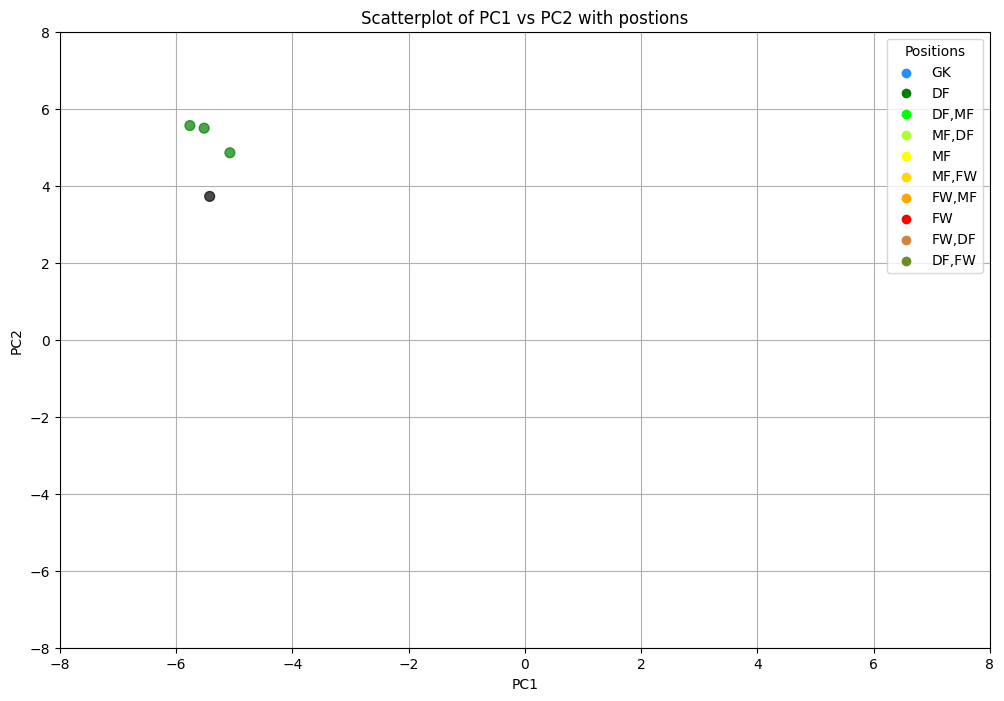

In [46]:
player = two_season_players[np.argmax(same_player_dist)]
print(player)

point = X_train_decomposed.loc[player]
for season in seasons[1:]:
    search_space = X_test_decomposed[X_test_decomposed['season'] == season]
    display(find_closest(search_space, point, n_comparison_pcs=15, n_closest=5))

player_scatter_df = pd.merge(data['2017-2018'][['team', 'pos']], pd.concat((X_train_decomposed.loc[[player]], X_test_decomposed.loc[player].iloc[:, :-1]), axis=0), left_index=True, right_index=True)
display(player_scatter_df)
analyse_pcs(1, 2, _pc_scatter_df=player_scatter_df, lim=8, first_black=True)

If the same player distance is indeed worse than the avg distance of 5 most similar ones, how bad is it?

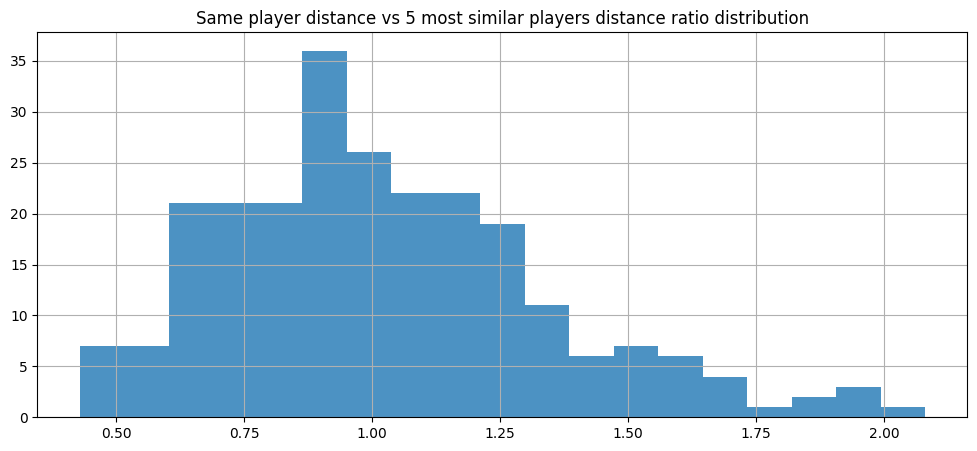

In [47]:
ratios = np.array(same_player_dist) / np.array(most_similar_5_dist)

plt.figure(figsize=(12, 5))
plt.title("Same player distance vs 5 most similar players distance ratio distribution")
plt.hist(ratios, bins=np.linspace(min(ratios), max(ratios), 20), alpha=0.8)
plt.grid()
plt.show()

For each position, we can define a position centroid in a given season (say, 2017-2018). What is the average distance of all players within that position to the centroid?

Position DF avg distance to centroid: 5.399748627617926


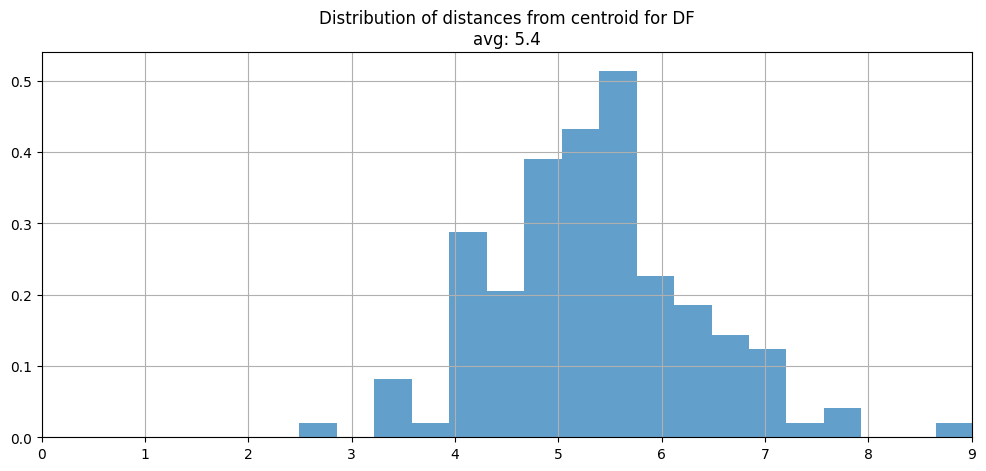

Position MF avg distance to centroid: 4.77540093008604


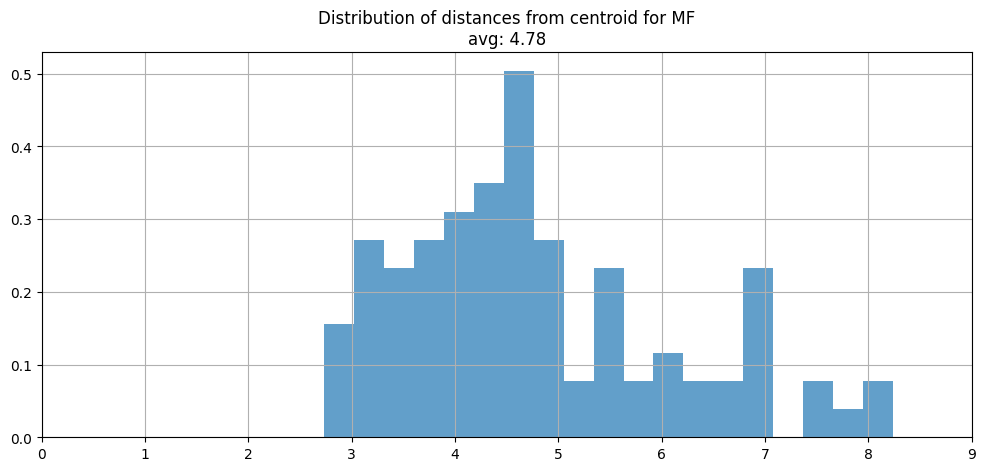

Position FW avg distance to centroid: 4.555159331332877


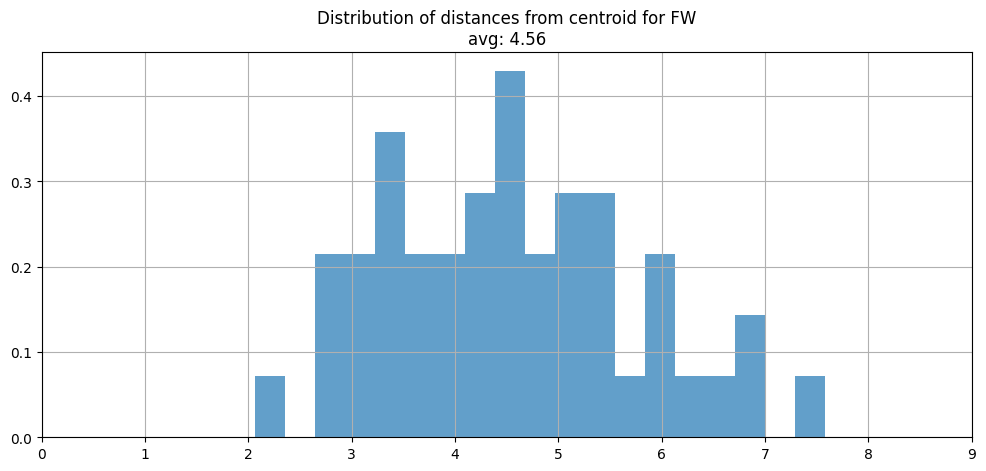

In [48]:
combined_positions = []
for position in ('DF', 'MF', 'FW'):
    pos_players = data['2017-2018'].query(f"pos == '{position}' and `90s` > 5.0").index
    pos_data = X_train_decomposed.loc[pos_players].iloc[:, :15]
    centroid = np.mean(pos_data, axis=0)
    distances_from_centroid = np.sqrt(np.sum((pos_data-centroid)**2, axis=1))
    print(f"Position {position} avg distance to centroid: {np.mean(distances_from_centroid)}")
    plt.figure(figsize=(12, 5))
    plt.title(f"Distribution of distances from centroid for {position}\navg: {np.round(np.mean(distances_from_centroid), 2)}")
    plt.hist(distances_from_centroid, bins=np.linspace(min(distances_from_centroid), max(distances_from_centroid), 20), alpha=0.7, density=True)
    if position != 'GK':
        combined_positions.extend(distances_from_centroid)
    plt.xlim(0, 9)
    plt.grid()
    plt.show()

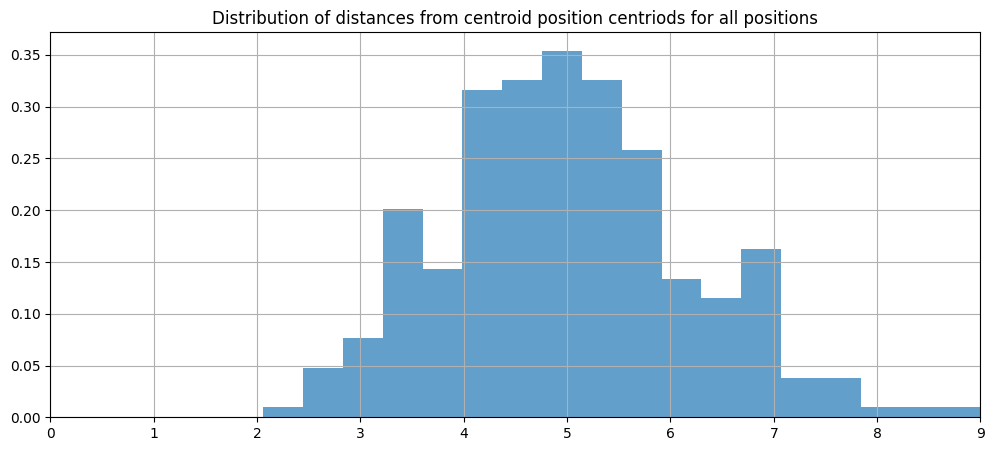

In [49]:
plt.figure(figsize=(12, 5))
plt.title(f"Distribution of distances from centroid position centriods for all positions")
plt.hist(combined_positions, bins=np.linspace(min(combined_positions), max(combined_positions), 20), alpha=0.7, density=True)
plt.xlim(0, 9)
plt.grid()
plt.show()

The distance to position centroid is much worse than picking the same player, or 5 most similar players